<a href="https://colab.research.google.com/github/allisonpg12/analitica3proyecto3/blob/main/CASO_SALUD_APG_AVRQ_MIVZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CASO DE ESTUDIO SALUD**

## **Importar librerias**

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
from sklearn import tree
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import sqlite3
from datetime import datetime

# Evitar salidas de Warnings
import warnings
warnings.filterwarnings("ignore")

## **Lectura de datos - Procesamiento de bases**

In [ ]:
#conectar el notebook al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lectura de bases de datos desde drive
df_cr = pd.read_excel('/content/drive/MyDrive/Trabajos grupo Analítica III/Trabajo 3 - Salud/RETO_df_cronicos.xlsx')
df_eg = pd.read_excel('/content/drive/MyDrive/Trabajos grupo Analítica III/Trabajo 3 - Salud/RETO_df_egresos.xlsx')
df_us = pd.read_excel('/content/drive/MyDrive/Trabajos grupo Analítica III/Trabajo 3 - Salud/RETO_df_usuarios.xlsx')

In [ ]:
# Verificar tamaño de las bases de datos
print('Tamaño de la base de crónico:',df_cr.shape)
print('Tamaño de la base de egresos:',df_eg.shape)
print('Tamaño de la base de usuarios:',df_us.shape)

Tamaño de la base de crónico: (38717, 290)
Tamaño de la base de egresos: (6376, 1)
Tamaño de la base de usuarios: (183911, 1)


In [ ]:
# Separación de columnas bases de datos de egresos y usuarios
# Usuarios
col =df_us.columns.tolist()
cols = col[0].split(',')
df_us[cols] =df_us[df_us.columns[0]].str.split(',', expand=True)
df_us.drop(columns=df_us.columns[0],inplace=True)
df_us.replace("", np.nan, inplace = True)
df_us.replace("Sin informaciÃ³n", np.nan, inplace = True)
df_us.replace("Sin Informacion", np.nan, inplace = True)
df_us.replace("Sin informacion en base de datos", np.nan, inplace = True)

# Egresos
df_eg.iloc[:,0] = df_eg.iloc[:,0].str.replace(', ', '')
col =df_eg.columns.tolist()
cols = col[0].split(',')
df_eg[cols] =df_eg[df_eg.columns[0]].str.split(',', expand=True)
df_eg.drop(columns=df_eg.columns[0],inplace=True)
df_eg.replace("", np.nan, inplace = True)
df_eg.replace("Sin informaciÃ³n", np.nan, inplace = True)
df_eg.replace("Sin Informacion", np.nan, inplace = True)
df_eg.replace("Sin informacion en base de datos", np.nan, inplace = True)
df_eg.replace("Sin informacion en Base de datos", np.nan, inplace = True)

In [ ]:
# Verificar que las bases hayan cargado de forma correcta
df_us.head()

,MES,YEAR,NRODOC,SEXO,FECHA NACIMIENTO,EDAD,DEPARTAMENTO,MUNICIPIO,BARRIO,FECHA INICIO AL PGP,FECHA PRIMERA CLASE FUNCIONAL,PRIMERA CLASE FUNCIONAL,FECHA ÃšLTIMA CLASE FUNCIONAL,ÃšLTIMA CLASE FUNCIONAL,CICLO_VITAL,QUINQUENIO
0,ABRIL,2017,306221,F,1938-09-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABRIL,2017,306222,F,1974-07-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABRIL,2017,306223,F,1930-08-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABRIL,2017,306224,F,1979-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABRIL,2017,306225,M,1943-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_eg.head()

,YEAR,MES,NRO ATENCION,NRO INGRESO,SERVICIO HABILITADO COD,SERVICIO HABILITADO,TIPO IDENTIFICACION,NRODOC,FECHA NACIMIENTO,REGIMEN AFILIACION,...,DX PRINCIPAL EGRESO CAPITULO COD,DX PRINCIPAL EGRESO CAPITULO,CAUSA BASICA MUERTE COD,CAUSA BASICA MUERTE,CAUSA BASICA CATEGORIA COD,CAUSA BASICA CATEGORIA,CAUSA BASICA CAPITULO COD,CAUSA BASICA CAPITULO,PROFESIONAL ESPECIALIDAD,PROFESIONAL ESPECIALIDAD GRD
0,2017,MAYO,3433964,1899917,-1.0,NaN,CC,308185,1937-07-18 00:00:00.000,NaN,...,J00-J99,ENFERMEDADES DEL SISTEMA RESPIRATORIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Medicina Interna
1,2017,DICIEMBRE,3720631,2018136,-1.0,NaN,CC,308185,1937-07-18 00:00:00.000,NaN,...,J00-J99,ENFERMEDADES DEL SISTEMA RESPIRATORIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Medicina Interna
2,2018,FEBRERO,3912821,2159592,501.0,Urgencias >= 24 horas,CC,308185,1937-07-18 00:00:00.000,Contributivo,...,J00-J99,ENFERMEDADES DEL SISTEMA RESPIRATORIO,NaN,NaN,NaN,NaN,NaN,NaN,Medicina Interna,Urgentologia
3,2018,MAYO,4023613,2254075,501.0,Urgencias >= 24 horas,CC,308185,1937-07-18 00:00:00.000,Contributivo,...,I00-I99,ENFERMEDADES DEL SISTEMA CIRCULATORIO,NaN,NaN,NaN,NaN,NaN,NaN,Medicina Interna,Urgentologia
4,2018,JULIO,4080166,2292863,101.0,General adultos,CC,308185,1937-07-18 00:00:00.000,Contributivo,...,I00-I99,ENFERMEDADES DEL SISTEMA CIRCULATORIO,NaN,NaN,NaN,NaN,NaN,NaN,Medicina Interna,Medicina Interna


In [ ]:
df_cr.head()

,YEAR,MES,Fecha diligenciamiento,Hora,AtenciÃ³n,Ingreso,Tipo,NRODOC,Peso,Talla,...,Diagnostico79,NombreDiagnostico79,Diagnostico80,NombreDiagnostico80,Diagnostico81,NombreDiagnostico81,Diagnostico82,NombreDiagnostico82,Diagnostico83,NombreDiagnostico83
0,2017,OCTUBRE,2017-10-02,9:00:20 a. m.,3912499,2629714,CC,311144,69.0,155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,OCTUBRE,2017-10-02,9:04:33 a. m.,3942247,2629726,CC,308418,62.0,155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,OCTUBRE,2017-10-02,9:11:43 a. m.,3898560,2629751,CC,308573,89.0,163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,OCTUBRE,2017-10-02,9:33:34 a. m.,3912599,2629828,CC,307549,88.0,163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,OCTUBRE,2017-10-02,9:43:59 a. m.,3906820,2629717,CC,307044,58.0,158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#verifciar formato de variables y datos faltantes
print(df_us.info())
print(df_eg.info())
print(df_cr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183911 entries, 0 to 183910
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   MES                            183911 non-null  object
 1   YEAR                           183911 non-null  object
 2   NRODOC                         183911 non-null  object
 3   SEXO                           183901 non-null  object
 4   FECHA NACIMIENTO               111831 non-null  object
 5   EDAD                           149755 non-null  object
 6   DEPARTAMENTO                   82284 non-null   object
 7   MUNICIPIO                      81397 non-null   object
 8   BARRIO                         115344 non-null  object
 9   FECHA INICIO AL PGP            125658 non-null  object
 10  FECHA PRIMERA CLASE FUNCIONAL  87961 non-null   object
 11  PRIMERA CLASE FUNCIONAL        89641 non-null   object
 12  FECHA ÃšLTIMA CLASE FUNCIONAL  87985 non-nul

In [ ]:
# Eliminar columnas que tienen más del 50% de los datos nulos en la BD usuarios o que no aportan información
df_us.drop(['FECHA NACIMIENTO','DEPARTAMENTO', 'MUNICIPIO', 'BARRIO','FECHA INICIO AL PGP', 'FECHA PRIMERA CLASE FUNCIONAL', 'PRIMERA CLASE FUNCIONAL', 'FECHA ÃšLTIMA CLASE FUNCIONAL', 'QUINQUENIO', 'CICLO_VITAL'], axis=1, inplace = True)

In [ ]:
# Eliminar datos faltantes de acuerdo a la clase funcional y la edad
df_us.dropna(subset=['ÃšLTIMA CLASE FUNCIONAL', 'EDAD'], inplace = True)

In [ ]:
# Cambiar nombre de columnas y tratar base final de usuarios
df_us.rename(columns={'ÃšLTIMA CLASE FUNCIONAL': 'clase_funcional'}, inplace=True)
df_us.columns = df_us.columns.str.lower()
df_us['clase_funcional'] = df_us['clase_funcional'].str.replace('CLASE FUNCIONAL ', '')
df_us['clase_funcional'] = df_us['clase_funcional'].str.replace('clase funcional ', '')
df_us['clase_funcional'] = df_us['clase_funcional'].str.replace('Clase funcional ', '')
df_us['edad'] = (df_us['edad'].astype(float)).astype(int)
df_us['year'] = df_us['year'].astype(int)
df_us['nrodoc'] = df_us['nrodoc'].astype(int)
df_us.head()

,mes,year,nrodoc,sexo,edad,clase_funcional
29233,OCTUBRE,2017,311028,M,65,3
29234,OCTUBRE,2017,310961,M,71,2B
29235,OCTUBRE,2017,310240,M,64,3
29237,OCTUBRE,2017,311235,F,81,2A
29239,OCTUBRE,2017,309710,F,86,4


In [ ]:
# Información Base de Datos Final de Usuarios
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125225 entries, 29233 to 183910
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   mes              125225 non-null  object
 1   year             125225 non-null  int64 
 2   nrodoc           125225 non-null  int64 
 3   sexo             125225 non-null  object
 4   edad             125225 non-null  int64 
 5   clase_funcional  125225 non-null  object
dtypes: int64(3), object(3)
memory usage: 6.7+ MB


In [ ]:
# Eliminar columnas que tienen más del 50% de los datos nulos en la BD egresos o que no aportan información
df_eg.drop(['NRO ATENCION', 'NRO INGRESO', 'SERVICIO HABILITADO COD', 'TIPO IDENTIFICACION', 'FECHA NACIMIENTO', 'FUENTE FINANCIACION1', 'FUENTE FINANCIACION2', 'BLOQUE ANTERIOR', 'PISO ANTERIOR',
            'SERVICIO ANTERIOR', 'NRO CAMA ANTERIOR', 'SERVICIO EGRESO', 'FECHA INGRESO SERVICIO', 'FECHA POSIBLE ALTA', 'FECHA ALTA MEDICA', 'FECHA RECAUDO', 'FECHA CAMILLERO', 'FECHA ENFERMERIA',
            'FECHA FACTURACION AUDIFARMA', 'FECHA FARMACIA', 'FECHA ASEO', 'TRANSFUSION SANGRE', 'ALTA MEDICA', 'POSIBLE ALTA', 'DXPRINCIPAL EGRESO', 'DX RELACIONADO1', 'DX RELACIONADO2', 'DX RELACIONADO3',
            'TIPO DIAGNOSTICO PRINCIPAL', 'PERTINENCIA DIAGNOSTICA', 'DX PRINCIPAL EGRESO CATEGORIA COD', 'DX PRINCIPAL EGRESO CATEGORIA', 'DX PRINCIPAL EGRESO CAPITULO', 'CAUSA BASICA MUERTE COD', 'CAUSA BASICA MUERTE',
            'CAUSA BASICA CATEGORIA COD', 'CAUSA BASICA CATEGORIA','CAUSA BASICA CAPITULO COD','CAUSA BASICA CAPITULO', 'PROFESIONAL ESPECIALIDAD GRD', 'DX RELACIONADO1 COD', 'DX RELACIONADO2 COD', 'DX RELACIONADO3 COD', 'DX PRINCIPAL EGRESO CAPITULO COD'], axis=1, inplace = True)

In [ ]:
# Eliminar datos faltantes de acuerdo a la fecha de ingreso, EPS validada, servicio admite
df_eg.dropna(subset=['FECHA INGRESO CLINICA', 'EPS VALIDADA', 'SERVICIO ADMITE'], inplace = True)

In [ ]:
# Cambiar nombre de columnas y tratar base final de egresos
df_eg.rename(columns={'DEMORA SALIDA CLINICA (DIAS)': 'DEMORA SALIDA CLINICA'}, inplace=True)
df_eg.columns = df_eg.columns.str.lower()
df_eg['servicio admite'] = df_eg['servicio admite'].str.replace('Urgencias Generales SÃ³tano','Urgencias Sotano')
df_eg['servicio admite'] = df_eg['servicio admite'].str.replace('CirugÃ­a', 'Cirugia')
df_eg['servicio admite'] = df_eg['servicio admite'].str.replace('HospitalizaciÃ³n','Hispitalizacion')
df_eg['servicio admite'] = df_eg['servicio admite'].str.replace('AtenciÃ³n Domiciliaria', 'Atencion Domiciliaria')
df_eg['servicio admite'] = df_eg['servicio admite'].str.replace('AtenciÃ³n Prioritaria', 'Atencion Prioritaria' )
df_eg['tipo egreso'] = df_eg['tipo egreso'].str.replace('Alta MÃ©dica', 'Alta Medica')
df_eg['year'] = df_eg['year'].astype(int)
df_eg['nrodoc'] = df_eg['nrodoc'].astype(int)
df_eg.head()

,year,mes,servicio habilitado,nrodoc,regimen afiliacion,eps validada,modalidad contrato,servicio admite,via ingreso,bloque,...,nro cama,tipo egreso,fecha ingreso clinica,fecha salida,demora asignacion cama,demora aplicacion medicamento,demora salida clinica,antibiotico,dxprincipal egreso cod,profesional especialidad
2,2018,FEBRERO,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,FST101,Alta Medica,2018-02-21 05:21:03.340,2018-02-22 13:21:18.000,0:00,-27:20,0.0,SI,J441,Medicina Interna
3,2018,MAYO,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,ERA109,Alta Medica,2018-05-19 15:07:11.027,2018-05-20 16:14:41.000,00:00,00:00,0.0,NO,I110,Medicina Interna
4,2018,JULIO,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,711BS,Alta Medica,2018-07-26 12:44:55.287,2018-07-31 14:40:30.000,00:00,00:00,0.0,NO,I110,Medicina Interna
5,2018,OCTUBRE,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,408AS,Alta Medica,2018-10-21 20:04:59.030,2018-10-27 14:58:20.000,00:00,00:00,0.0,NO,K573,Medicina Interna
6,2018,NOVIEMBRE,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,ERA110,Alta Medica,2018-11-20 02:01:23.783,2018-11-22 09:22:53.000,00:00,00:00,0.0,NO,J441,Cirugia General


In [ ]:
# Información Base de Datos de Egresos
df_eg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4089 entries, 2 to 6375
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   year                           4089 non-null   int64 
 1   mes                            4089 non-null   object
 2   servicio habilitado            4089 non-null   object
 3   nrodoc                         4089 non-null   int64 
 4   regimen afiliacion             4089 non-null   object
 5   eps validada                   4089 non-null   object
 6   modalidad contrato             4089 non-null   object
 7   servicio admite                4089 non-null   object
 8   via ingreso                    4089 non-null   object
 9   bloque                         4089 non-null   object
 10  unidad estrategica             4089 non-null   object
 11  piso                           4089 non-null   object
 12  nro cama                       4089 non-null   object
 13  tip

In [ ]:
# Cambiar tipos de variables de fechas y tratar variable demoras
df_eg['fecha salida']=pd.to_datetime(df_eg['fecha salida'])
df_eg['fecha ingreso clinica']=pd.to_datetime(df_eg['fecha ingreso clinica'])
df_eg['demora salida clinica'] = (df_eg['demora salida clinica'].astype(float))*24

# Demora asignación cama
demora = df_eg['demora asignacion cama'].str.split(':', expand=True)
demora.columns=['min','seg']
demora['min'] = demora['min'].astype(int)
demora['seg'] = demora['seg'].astype(int)
demora['min']=demora['min']/60
demora['seg']=demora['seg']/3600
df_eg['demora asignacion cama']=demora['min']+demora['seg']

# Demora asignación medicamento
demora = df_eg['demora aplicacion medicamento'].str.split(':', expand=True)
demora.columns=['min','seg']
demora['min'] = demora['min'].astype(int)
demora['seg'] = demora['seg'].astype(int)
demora['min']=demora['min']/60
demora['seg']=demora['seg']/3600
df_eg['demora aplicacion medicamento']=-1*(demora['min']+demora['seg'])

df_eg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4089 entries, 2 to 6375
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   year                           4089 non-null   int64         
 1   mes                            4089 non-null   object        
 2   servicio habilitado            4089 non-null   object        
 3   nrodoc                         4089 non-null   int64         
 4   regimen afiliacion             4089 non-null   object        
 5   eps validada                   4089 non-null   object        
 6   modalidad contrato             4089 non-null   object        
 7   servicio admite                4089 non-null   object        
 8   via ingreso                    4089 non-null   object        
 9   bloque                         4089 non-null   object        
 10  unidad estrategica             4089 non-null   object        
 11  piso             

In [ ]:
# Seleccionar columnas de interés de la BD crónico
df_cr = pd.DataFrame(df_cr[['YEAR', 'MES', 'NRODOC','IMC', 'SaturaciÃ³n de OxÃ­geno (%)',
                            'PresiÃ³n Arterial SistÃ³lica', 'PresiÃ³n Arterial DiastÃ³lica', 'Frecuencia CardÃ­aca en reposo',
                            'METS -Ãndice MetabÃ³lico', 'VO2 - MÃ¡xima Cantidad de OxÃ­geno','Ãndice de Fragilidad Groningen',
                            'Glicemia', 'Hemoglobina Glicada', 'Lipoproteina', 'HDL', 'Colesterol total', 'Trigliceridos',
                            'Creatinina 1 consulta', 'Tasa de FiltraciÃ³n Glomerular TFG', 'Microalbuminuria',
                            'Hormona Estimulante de la Tiroides (TSH)', 'Creatinina 2 consulta']])

In [ ]:
# Cambiar nombre de columnas y tratar base final de crónicos
df_cr.replace("", np.nan, inplace = True)
df_cr.replace("Sin informaciÃ³n", np.nan, inplace = True)
df_cr.replace("Sin Informacion", np.nan, inplace = True)
df_cr.replace("Sin informacion en base de datos", np.nan, inplace = True)
df_cr.rename(columns={'SaturaciÃ³n de OxÃ­geno (%)': 'saturacion oxigeno'}, inplace=True)
df_cr.rename(columns={'PresiÃ³n Arterial SistÃ³lica': 'presion art sistolica'}, inplace=True)
df_cr.rename(columns={'PresiÃ³n Arterial DiastÃ³lica': 'presion art diastolica'}, inplace=True)
df_cr.rename(columns={'Frecuencia CardÃ­aca en reposo': 'frec cardiaca reposo'}, inplace=True)
df_cr.rename(columns={'METS -Ãndice MetabÃ³lico': 'indice metabolico'}, inplace=True)
df_cr.rename(columns={'VO2 - MÃ¡xima Cantidad de OxÃ­geno': 'max cant oxigeno'}, inplace=True)
df_cr.rename(columns={'Ãndice de Fragilidad Groningen': 'indice de fragilidad groingen'}, inplace=True)
df_cr.rename(columns={'Tasa de FiltraciÃ³n Glomerular TFG': 'tasa filtracion glomerular tfg'}, inplace=True)
df_cr.columns = df_cr.columns.str.lower()

In [ ]:
# Eliminar datos faltantes de acuerdo a la cantidad de datos que tienen los exámenes de laboratorio completos
df_cr.dropna(subset=['hdl','indice de fragilidad groingen', 'saturacion oxigeno'], inplace=True)

In [ ]:
# Información Base de Datos Final de Crónicos
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37489 entries, 0 to 38716
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      37489 non-null  int64  
 1   mes                                       37489 non-null  object 
 2   nrodoc                                    37489 non-null  int64  
 3   imc                                       37489 non-null  float64
 4   saturacion oxigeno                        37489 non-null  float64
 5   presion art sistolica                     37489 non-null  int64  
 6   presion art diastolica                    37489 non-null  int64  
 7   frec cardiaca reposo                      37489 non-null  int64  
 8   indice metabolico                         37489 non-null  float64
 9   max cant oxigeno                          37489 non-null  float64
 10  indice de fragilidad groingen     

In [ ]:
# Calcular la diferencia entre la salida y el ingreso para obtener la estancia hospitalaria en horas
df_eg['est_hosp'] = (df_eg['fecha salida']-df_eg['fecha ingreso clinica']).dt.total_seconds() / 3600
df_eg.drop(['fecha ingreso clinica', 'fecha salida'], axis=1, inplace = True)

In [ ]:
# Visualizar estancia hospitalaria en horas
df_eg.head()

,year,mes,servicio habilitado,nrodoc,regimen afiliacion,eps validada,modalidad contrato,servicio admite,via ingreso,bloque,...,piso,nro cama,tipo egreso,demora asignacion cama,demora aplicacion medicamento,demora salida clinica,antibiotico,dxprincipal egreso cod,profesional especialidad,est_hosp
2,2018,FEBRERO,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,Urgencias,FST101,Alta Medica,0.0,0.444444,0.0,SI,J441,Medicina Interna,32.004072
3,2018,MAYO,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,Urgencias,ERA109,Alta Medica,0.0,-0.000000,0.0,NO,I110,Medicina Interna,25.124993
4,2018,JULIO,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,Piso 7,711BS,Alta Medica,0.0,-0.000000,0.0,NO,I110,Medicina Interna,121.926309
5,2018,OCTUBRE,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,Piso 4,408AS,Alta Medica,0.0,-0.000000,0.0,NO,K573,Medicina Interna,138.889158
6,2018,NOVIEMBRE,Urgencias >= 24 horas,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 3,...,Urgencias,ERA110,Alta Medica,0.0,-0.000000,0.0,NO,J441,Cirugia General,55.358116


Para la unión de las bases de datos, se toma como base de datos principal la que contiene los egresos de los pacientes. Asimismo, la variable clave para hacer la unión será 'nrodoc', para ello, es necesario verificar si cada dato contiene un código distinto o si hay códigos repetidos para varios datos.

In [ ]:
# Unión de bases de datos tomando como base principal egresos
print(len(df_eg['nrodoc'].unique()))
print(len(df_cr['nrodoc'].unique()))
print(len(df_us['nrodoc'].unique()))

print(len(df_eg['year'].unique()))
print(len(df_cr['year'].unique()))
print(len(df_us['year'].unique()))

print(len(df_eg['mes'].unique()))
print(len(df_cr['mes'].unique()))
print(len(df_us['mes'].unique()))

2418
6029
7019
3
4
4
12
12
12


Teniendo en cuenta que hay repetición de códigos nrodoc en la base de datos de egresos, se debe hacer la unión con esta variable, el año y el mes, con el fin de construir una base de datos final adecuada.

In [ ]:
# Unir las bases de datos por medio de key:
data_frames =[df_eg, df_us, df_cr]
df = reduce(lambda  left,right: pd.merge(left,right, on=['nrodoc', 'year','mes'],
                                            how='inner'), data_frames)

df.head()

,year,mes,servicio habilitado,nrodoc,regimen afiliacion,eps validada,modalidad contrato,servicio admite,via ingreso,bloque,...,hemoglobina glicada,lipoproteina,hdl,colesterol total,trigliceridos,creatinina 1 consulta,tasa filtracion glomerular tfg,microalbuminuria,hormona estimulante de la tiroides (tsh),creatinina 2 consulta
0,2018,JULIO,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,5.40,100.0,53.0,176.0,111.0,1.00,40.40,9.90,2.81,0.00
1,2018,OCTUBRE,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,5.40,100.0,53.0,176.0,111.0,1.00,39.01,9.90,2.81,0.00
2,2018,OCTUBRE,General adultos,308738,Contributivo,NUEVA EPS S.A. PGP,PGP,Urgencias Sotano,Urgencias,Bloque 1,...,6.50,55.2,33.2,116.0,138.0,1.12,38.26,0.00,1286.00,0.96
3,2018,DICIEMBRE,General adultos,308418,Contributivo,NUEVA EPS S.A. PGP,PGP,Hispitalizacion,Remitido,Bloque 1,...,6.08,86.0,44.0,153.0,110.0,1.00,54.58,8.30,4.65,1.00
4,2018,OCTUBRE,General adultos,311433,Contributivo,NUEVA EPS S.A. PGP,PGP,Hispitalizacion,Remitido,Bloque 1,...,5.80,100.0,35.5,188.0,262.0,1.00,81.60,3.17,0.00,0.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 776
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      777 non-null    int64  
 1   mes                                       777 non-null    object 
 2   servicio habilitado                       777 non-null    object 
 3   nrodoc                                    777 non-null    int64  
 4   regimen afiliacion                        777 non-null    object 
 5   eps validada                              777 non-null    object 
 6   modalidad contrato                        777 non-null    object 
 7   servicio admite                           777 non-null    object 
 8   via ingreso                               777 non-null    object 
 9   bloque                                    777 non-null    object 
 10  unidad estrategica                    

In [ ]:
# Seleccionar la modalidad de contrato PGP
df = df.loc[df['modalidad contrato']=='PGP']
df.drop(['modalidad contrato'], axis=1, inplace = True)
df.year = df['year'].astype(str)
df.nrodoc = df['nrodoc'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 0 to 776
Data columns (total 42 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      758 non-null    object 
 1   mes                                       758 non-null    object 
 2   servicio habilitado                       758 non-null    object 
 3   nrodoc                                    758 non-null    object 
 4   regimen afiliacion                        758 non-null    object 
 5   eps validada                              758 non-null    object 
 6   servicio admite                           758 non-null    object 
 7   via ingreso                               758 non-null    object 
 8   bloque                                    758 non-null    object 
 9   unidad estrategica                        758 non-null    object 
 10  piso                                  

## **Análisis Exploratorio**

In [ ]:
# Separación de variables numéricas y categóricas
dfnum = df.select_dtypes(include=['float64','int64'])
dfcat = df.select_dtypes(include=['object'])

In [ ]:
dfnum.head()

,demora asignacion cama,demora aplicacion medicamento,demora salida clinica,est_hosp,edad,imc,saturacion oxigeno,presion art sistolica,presion art diastolica,frec cardiaca reposo,...,hemoglobina glicada,lipoproteina,hdl,colesterol total,trigliceridos,creatinina 1 consulta,tasa filtracion glomerular tfg,microalbuminuria,hormona estimulante de la tiroides (tsh),creatinina 2 consulta
0,0.0,-0.0,0.0,121.926309,79,25.78,63.0,110,63,101,...,5.40,100.0,53.0,176.0,111.0,1.00,40.40,9.90,2.81,0.00
1,0.0,-0.0,0.0,138.889158,79,24.89,67.0,134,52,80,...,5.40,100.0,53.0,176.0,111.0,1.00,39.01,9.90,2.81,0.00
2,0.0,-0.0,0.0,230.177294,73,24.44,86.0,140,80,98,...,6.50,55.2,33.2,116.0,138.0,1.12,38.26,0.00,1286.00,0.96
3,0.0,-0.0,0.0,119.694106,71,29.09,97.0,113,53,79,...,6.08,86.0,44.0,153.0,110.0,1.00,54.58,8.30,4.65,1.00
4,0.0,-0.0,0.0,70.581827,67,35.69,93.0,136,83,70,...,5.80,100.0,35.5,188.0,262.0,1.00,81.60,3.17,0.00,0.00


In [ ]:
dfcat.head()

,year,mes,servicio habilitado,nrodoc,regimen afiliacion,eps validada,servicio admite,via ingreso,bloque,unidad estrategica,piso,nro cama,tipo egreso,antibiotico,dxprincipal egreso cod,profesional especialidad,sexo,clase_funcional
0,2018,JULIO,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,Urgencias Sotano,Urgencias,Bloque 1,Hospitalizacion Adultos,Piso 7,711BS,Alta Medica,NO,I110,Medicina Interna,F,2A
1,2018,OCTUBRE,General adultos,308185,Contributivo,NUEVA EPS S.A. PGP,Urgencias Sotano,Urgencias,Bloque 1,Hospitalizacion Adultos,Piso 4,408AS,Alta Medica,NO,K573,Medicina Interna,F,2A
2,2018,OCTUBRE,General adultos,308738,Contributivo,NUEVA EPS S.A. PGP,Urgencias Sotano,Urgencias,Bloque 1,Hospitalizacion Adultos,Piso 4,413BS,Alta Medica,NO,K260,Medicina Interna,F,2A
3,2018,DICIEMBRE,General adultos,308418,Contributivo,NUEVA EPS S.A. PGP,Hispitalizacion,Remitido,Bloque 1,Hospitalizacion Adultos,Piso 7,731AN,Alta Medica,NO,J441,Medicina Interna,F,3
4,2018,OCTUBRE,General adultos,311433,Contributivo,NUEVA EPS S.A. PGP,Hispitalizacion,Remitido,Bloque 1,Hospitalizacion Adultos,Piso 4,419AS,Alta Medica,SI,L031,Medicina Interna,M,2B


In [ ]:
# Descripción estadística de las variables numéricas
# Cantidad de datos, promedio, desviación estándar, mínimo, máximo y percentiles
dfnum.describe().T

,count,mean,std,min,25%,50%,75%,max
demora asignacion cama,758.0,0.126881,0.313708,0.000000e+00,0.000000,0.000000,0.072847,4.186111
demora aplicacion medicamento,758.0,1.883263,2.662531,-3.388889e-02,0.000000,1.000417,2.600347,22.080000
demora salida clinica,758.0,0.126649,4.271475,-9.600000e+01,0.000000,0.000000,0.000000,24.000000
est_hosp,758.0,157.987071,159.723046,4.968639e-01,56.738346,115.952402,194.103301,1395.667092
edad,758.0,74.348285,12.335472,2.000000e+01,67.250000,75.000000,83.000000,100.000000
imc,758.0,27.510079,13.120610,1.240000e+01,23.440000,26.560000,30.220000,355.030000
saturacion oxigeno,758.0,93.649077,4.872571,5.400000e+01,92.000000,95.000000,96.000000,100.000000
presion art sistolica,758.0,125.048813,21.031435,7.000000e+01,110.000000,121.000000,134.000000,230.000000
presion art diastolica,758.0,70.874670,10.925054,3.900000e+01,63.000000,70.000000,80.000000,150.000000
frec cardiaca reposo,758.0,79.529024,14.538922,4.000000e+01,70.000000,78.000000,88.000000,150.000000


In [ ]:
# Descripción estadística de las variables categóricas
# Cantidad de datos únicos, moda, frecuencia
dfcat.describe(include = 'all').T

,count,unique,top,freq
year,758,3,2021,487
mes,758,12,MARZO,101
servicio habilitado,758,5,General adultos,572
nrodoc,758,619,312415,5
regimen afiliacion,758,2,Contributivo,757
eps validada,758,1,NUEVA EPS S.A. PGP,758
servicio admite,758,6,Urgencias Sotano,449
via ingreso,758,3,Urgencias,516
bloque,758,2,Bloque 1,533
unidad estrategica,758,5,Hospitalizacion Adultos,571


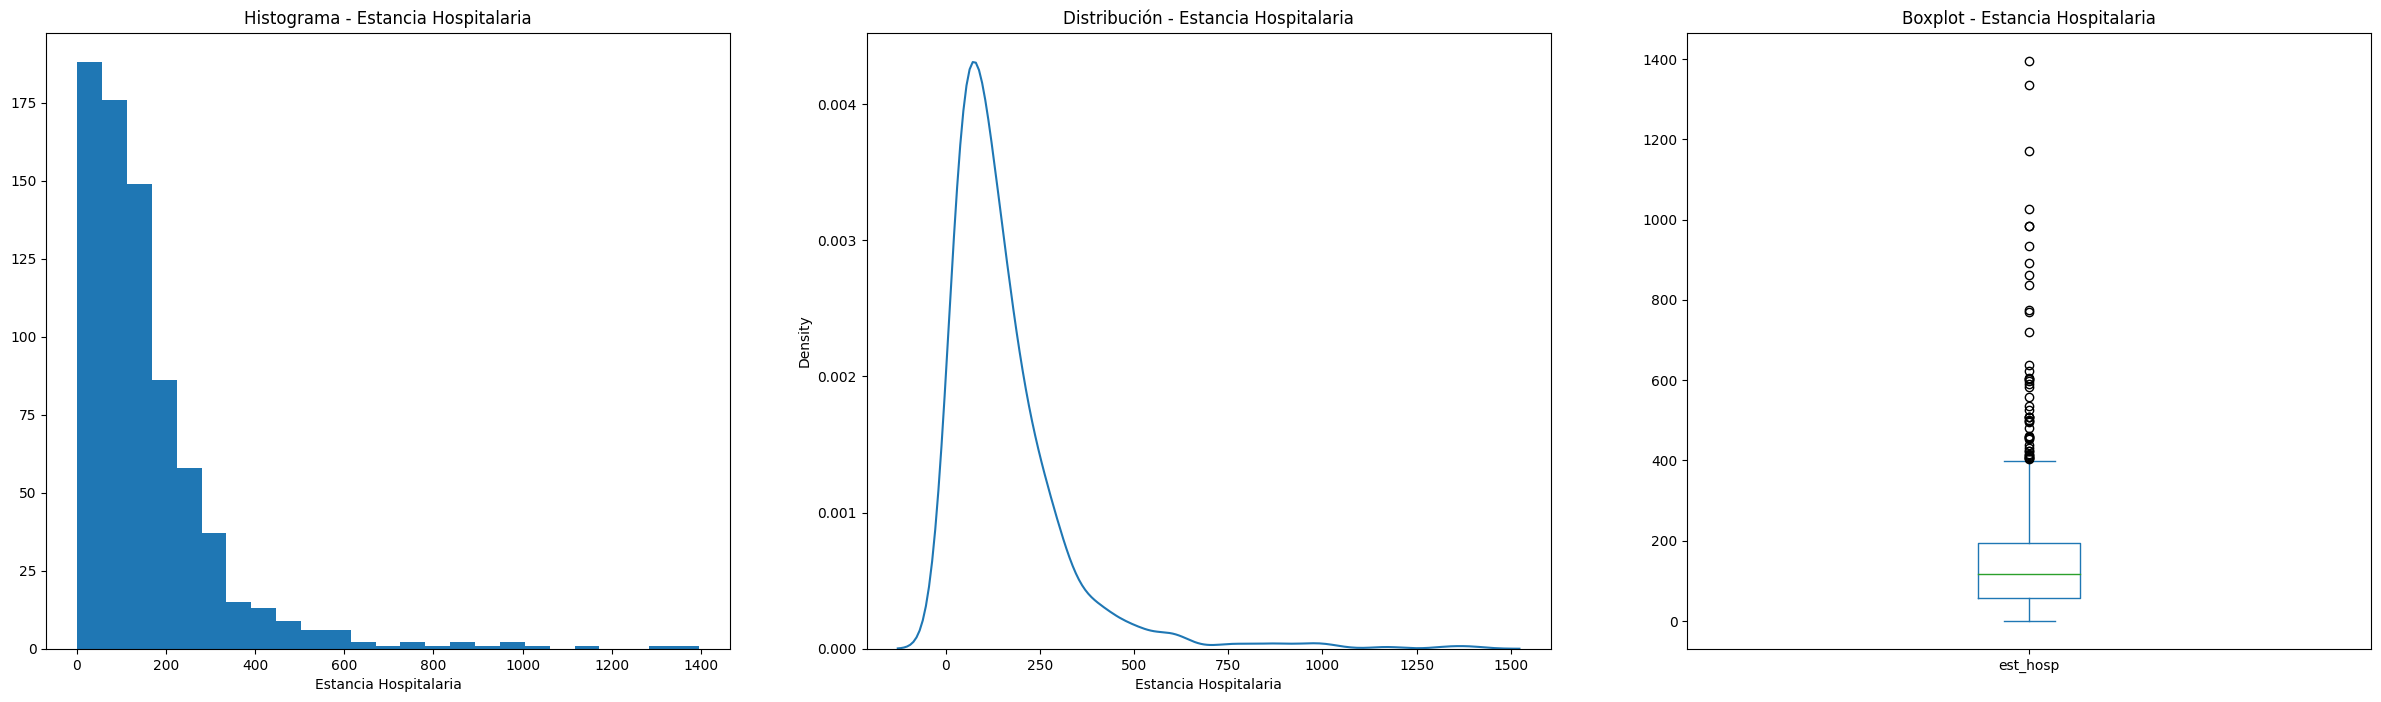

In [ ]:
# Análisis de la variable objetivo
# Estancia hospitalaria
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum.est_hosp,25)
plt.xlabel('Estancia Hospitalaria')
plt.title('Histograma - Estancia Hospitalaria')

plt.subplot(1,3,2)
sns.kdeplot(x = "est_hosp", data = dfnum)
plt.xlabel('Estancia Hospitalaria')
plt.title('Distribución - Estancia Hospitalaria')

plt.subplot(1,3,3)
dfnum['est_hosp'].plot(kind='box')
plt.title('Boxplot - Estancia Hospitalaria')
plt.show()

Al analizar la estancia hospitalaria de cada uno de los registros de la base de datos, vemos entonces que la mayoria de las estancias hospitalarias se encuentran por debajo de las 200 horas y solo en algunos casos estas una estancia hospitalaria puede llegar a durarar mas de 400 horas.
Sin embargo, este analisis es de mayor valor, al realizarlo de forma diferenciada, ya sea por rangos de edad, tipo de enfermedad u otra caracteristica que no se vea alterada por la gran variedad de registros.

**Análisis de Variables Numéricas**

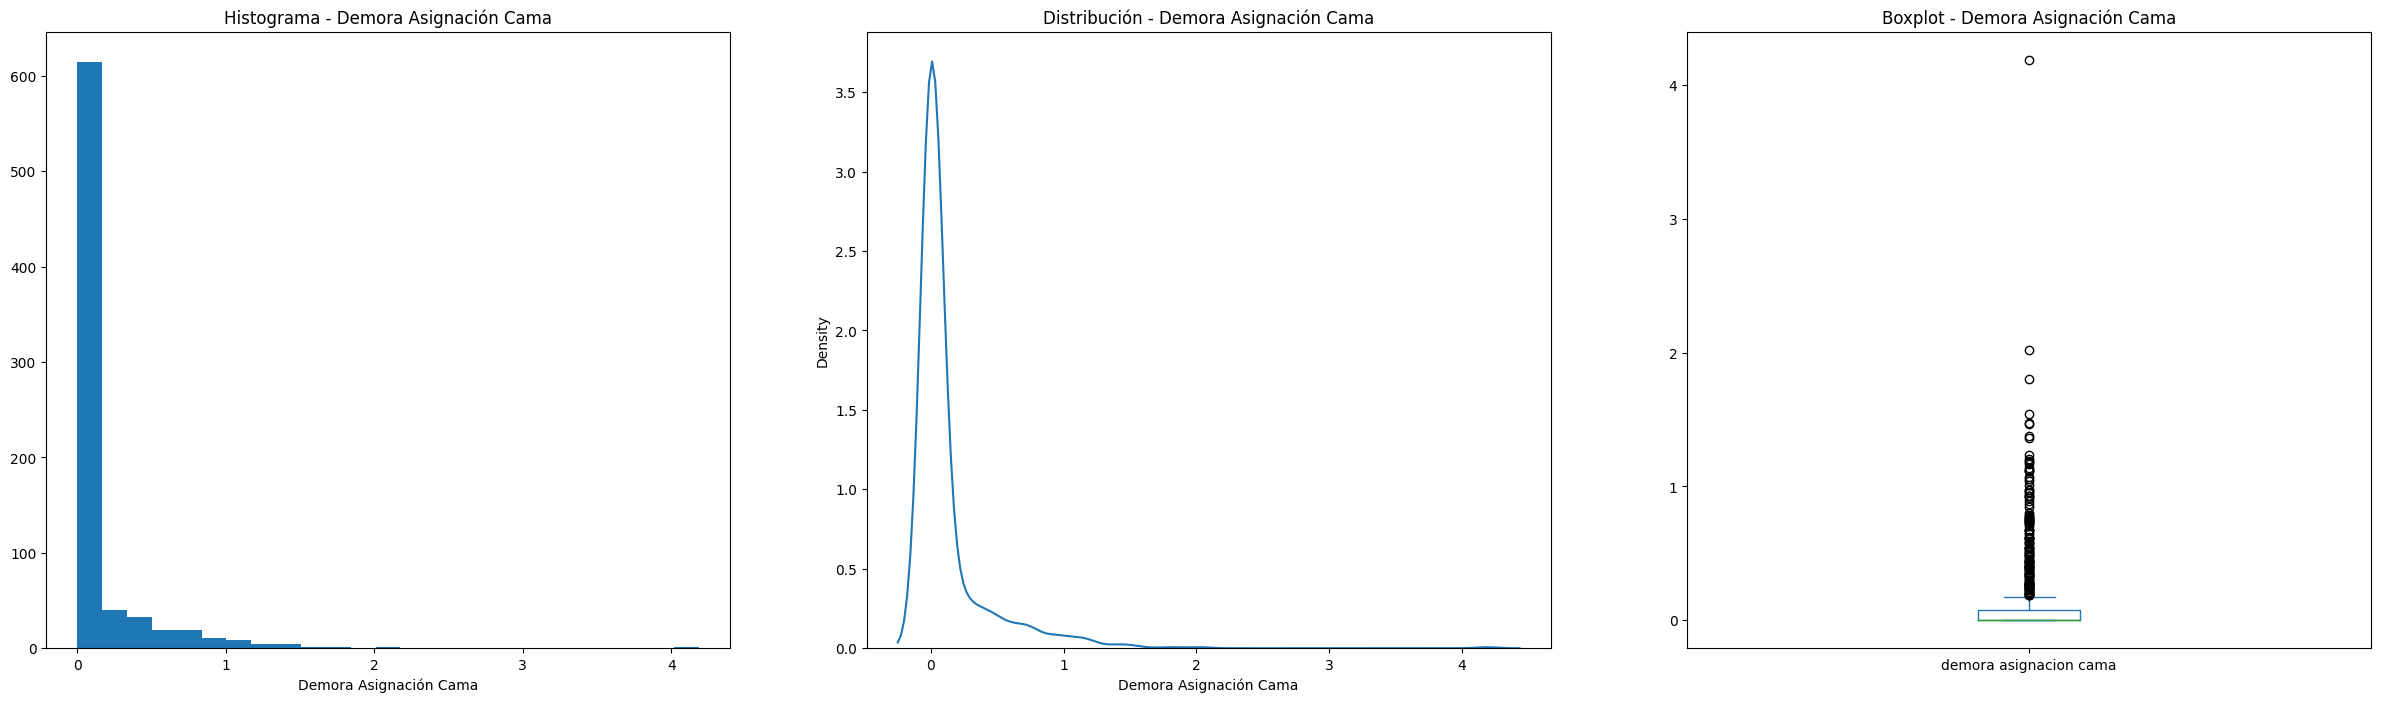

In [ ]:
# Demora en asignación de cama
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['demora asignacion cama'],25)
plt.xlabel('Demora Asignación Cama')
plt.title('Histograma - Demora Asignación Cama')

plt.subplot(1,3,2)
sns.kdeplot(x = "demora asignacion cama", data = dfnum)
plt.xlabel('Demora Asignación Cama')
plt.title('Distribución - Demora Asignación Cama')

plt.subplot(1,3,3)
dfnum['demora asignacion cama'].plot(kind='box')
plt.title('Boxplot - Demora Asignación Cama')
plt.show()

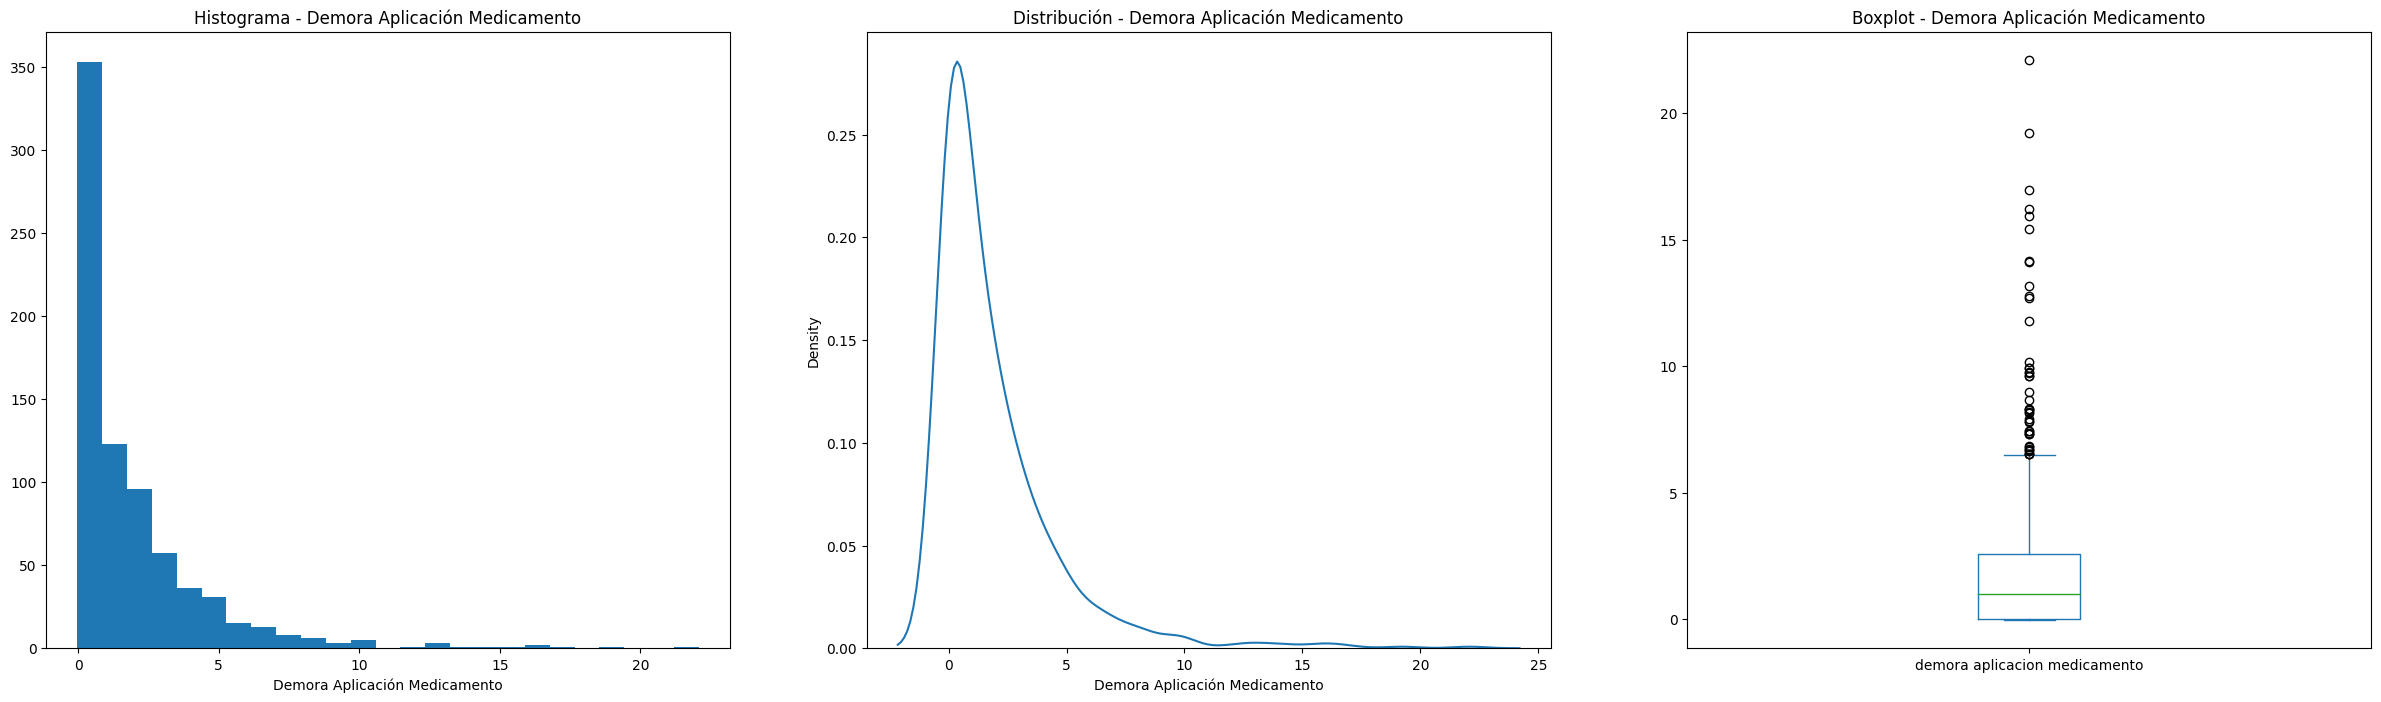

In [ ]:
# Demora en aplicación medicamento
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['demora aplicacion medicamento'],25)
plt.xlabel('Demora Aplicación Medicamento')
plt.title('Histograma - Demora Aplicación Medicamento')

plt.subplot(1,3,2)
sns.kdeplot(x = "demora aplicacion medicamento", data = dfnum)
plt.xlabel('Demora Aplicación Medicamento')
plt.title('Distribución - Demora Aplicación Medicamento')

plt.subplot(1,3,3)
dfnum['demora aplicacion medicamento'].plot(kind='box')
plt.title('Boxplot - Demora Aplicación Medicamento')
plt.show()

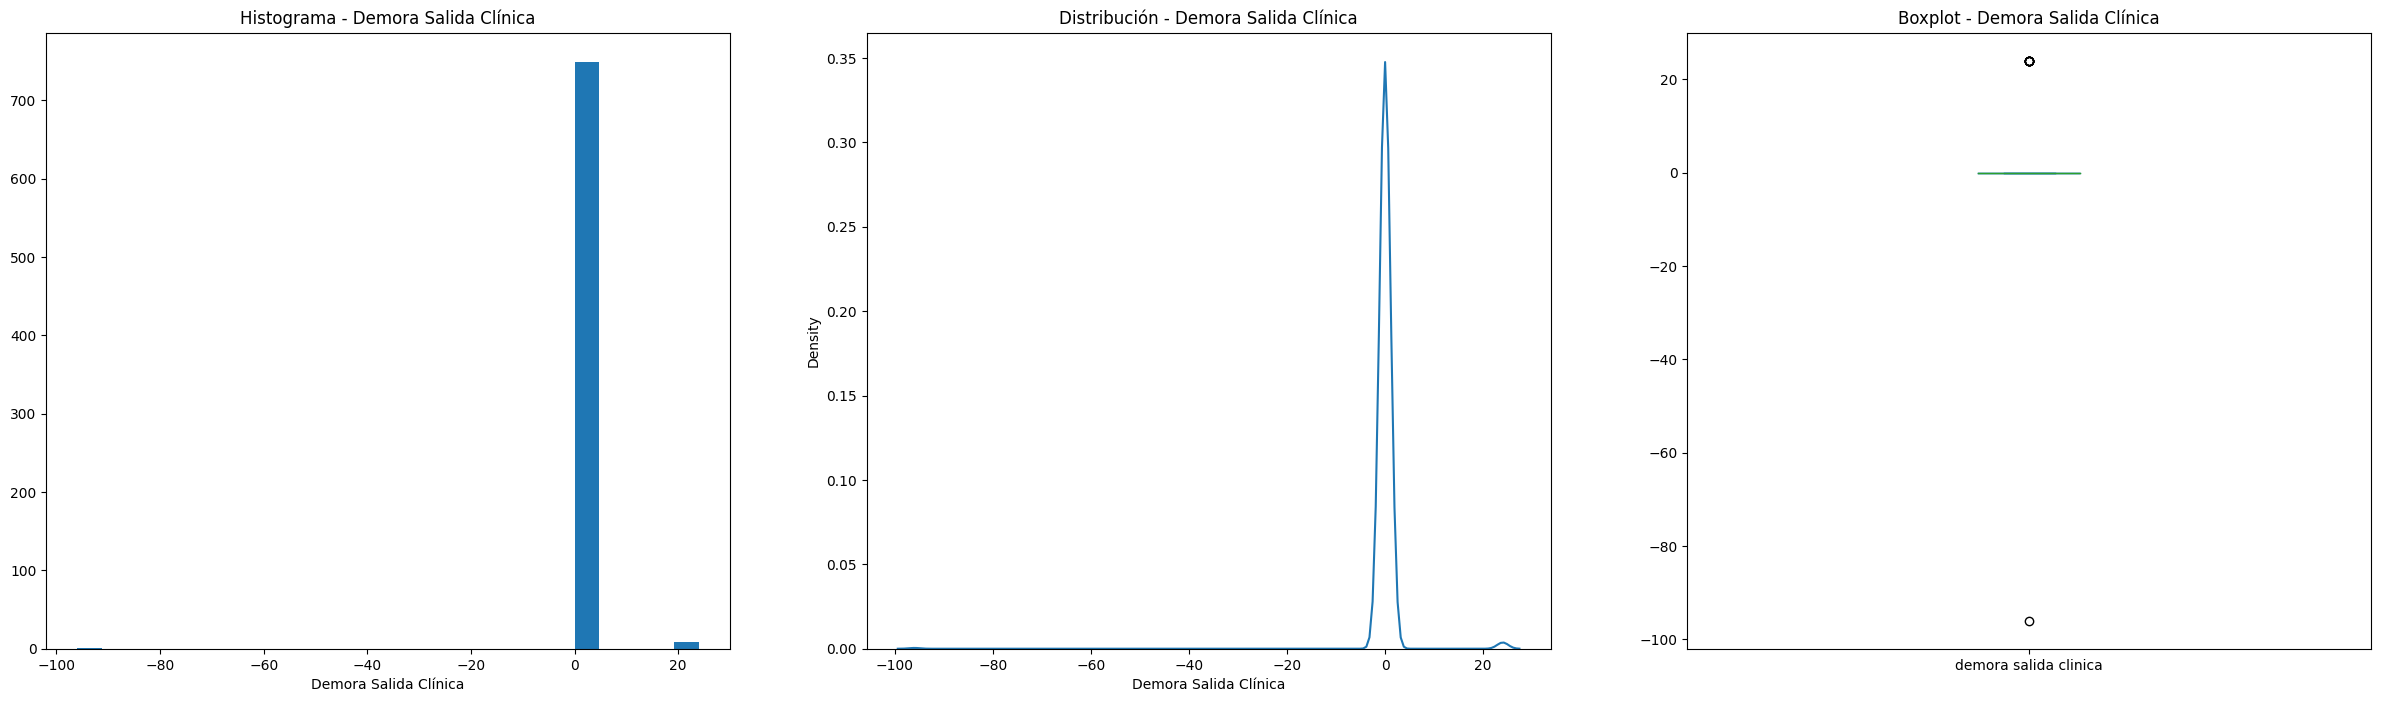

In [ ]:
# Demora en salida de la clínica
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['demora salida clinica'],25)
plt.xlabel('Demora Salida Clínica')
plt.title('Histograma - Demora Salida Clínica')

plt.subplot(1,3,2)
sns.kdeplot(x = "demora salida clinica", data = dfnum)
plt.xlabel('Demora Salida Clínica')
plt.title('Distribución - Demora Salida Clínica')

plt.subplot(1,3,3)
dfnum['demora salida clinica'].plot(kind='box')
plt.title('Boxplot - Demora Salida Clínica')
plt.show()

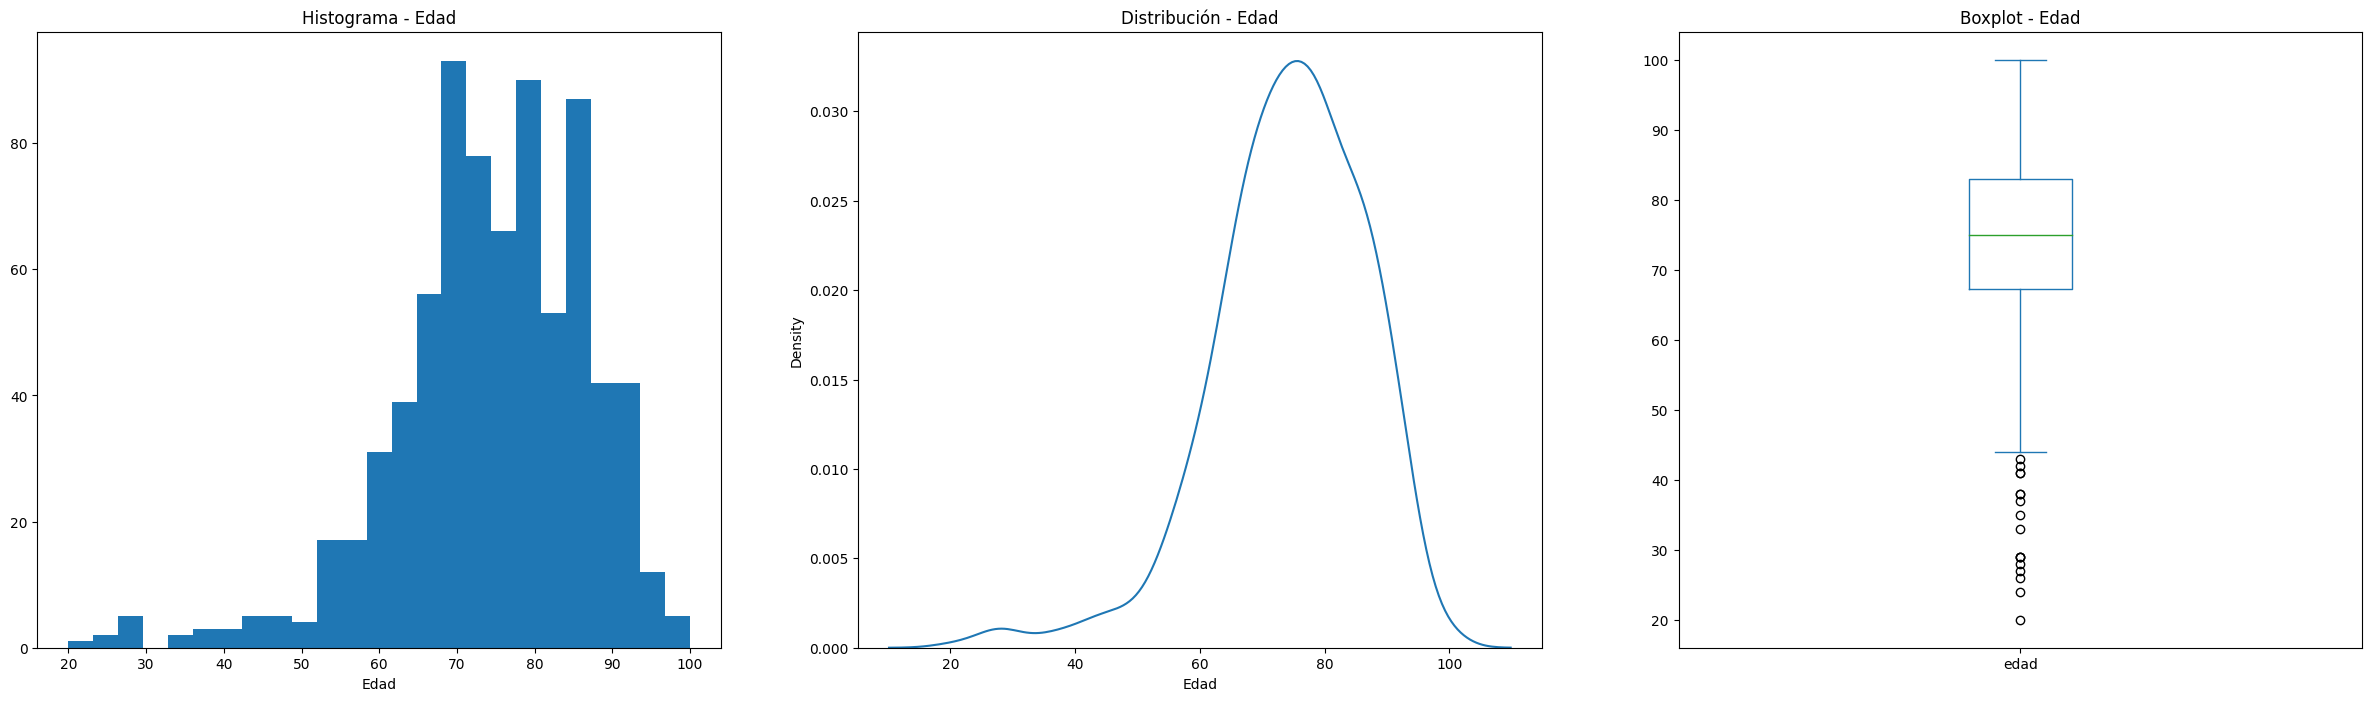

In [ ]:
# Edad
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['edad'],25)
plt.xlabel('Edad')
plt.title('Histograma - Edad')

plt.subplot(1,3,2)
sns.kdeplot(x = "edad", data = dfnum)
plt.xlabel('Edad')
plt.title('Distribución - Edad')

plt.subplot(1,3,3)
dfnum['edad'].plot(kind='box')
plt.title('Boxplot - Edad')
plt.show()

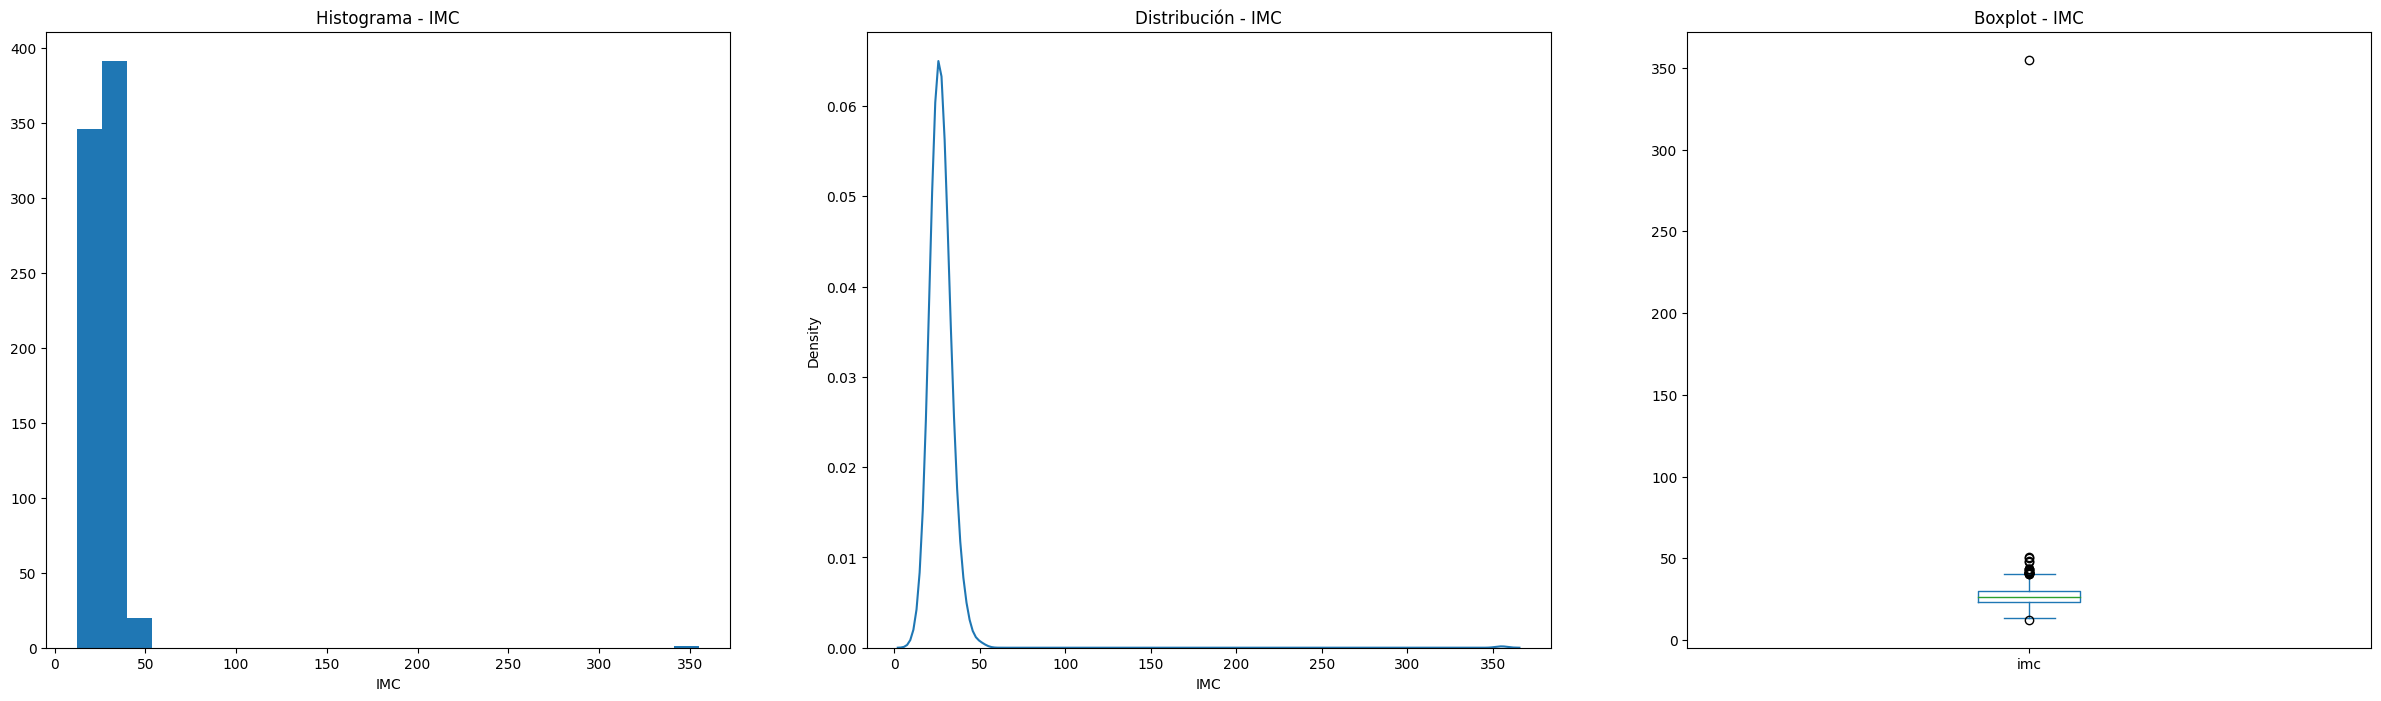

In [ ]:
# IMC
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['imc'],25)
plt.xlabel('IMC')
plt.title('Histograma - IMC')

plt.subplot(1,3,2)
sns.kdeplot(x = "imc", data = dfnum)
plt.xlabel('IMC')
plt.title('Distribución - IMC')

plt.subplot(1,3,3)
dfnum['imc'].plot(kind='box')
plt.title('Boxplot - IMC')
plt.show()

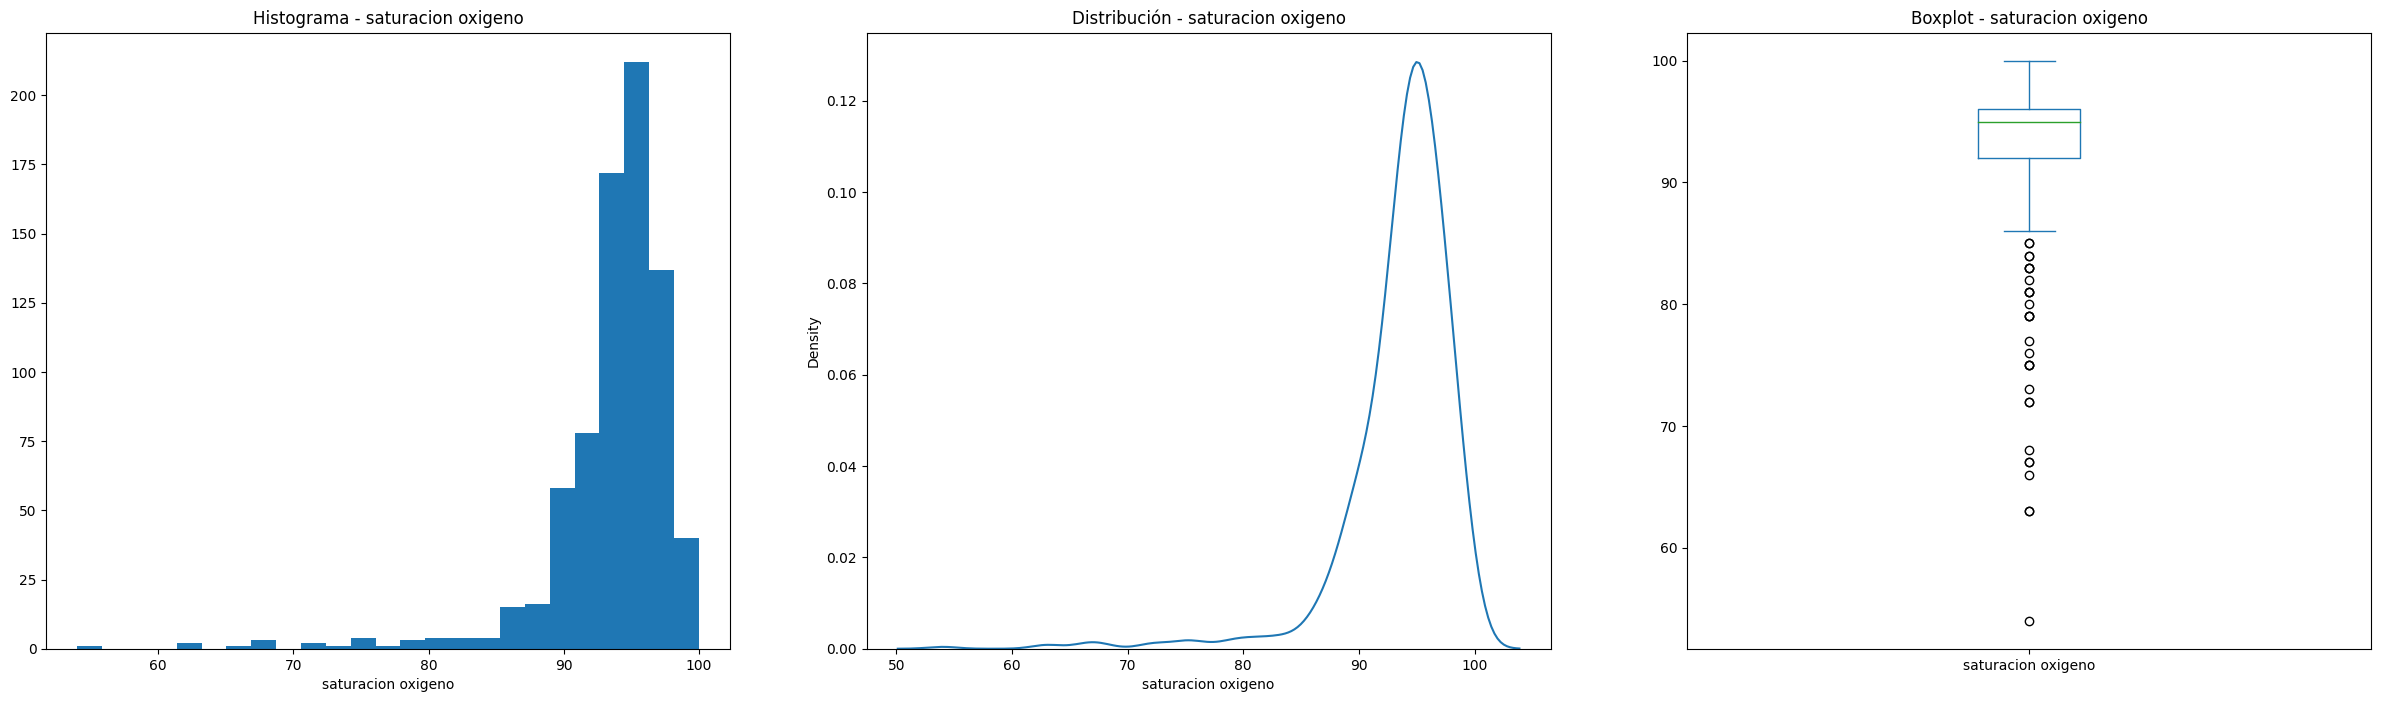

In [ ]:
#saturacion oxigeno
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['saturacion oxigeno'],25)
plt.xlabel('saturacion oxigeno')
plt.title('Histograma - saturacion oxigeno')

plt.subplot(1,3,2)
sns.kdeplot(x = "saturacion oxigeno", data = dfnum)
plt.xlabel('saturacion oxigeno')
plt.title('Distribución - saturacion oxigeno')

plt.subplot(1,3,3)
dfnum['saturacion oxigeno'].plot(kind='box')
plt.title('Boxplot - saturacion oxigeno')
plt.show()

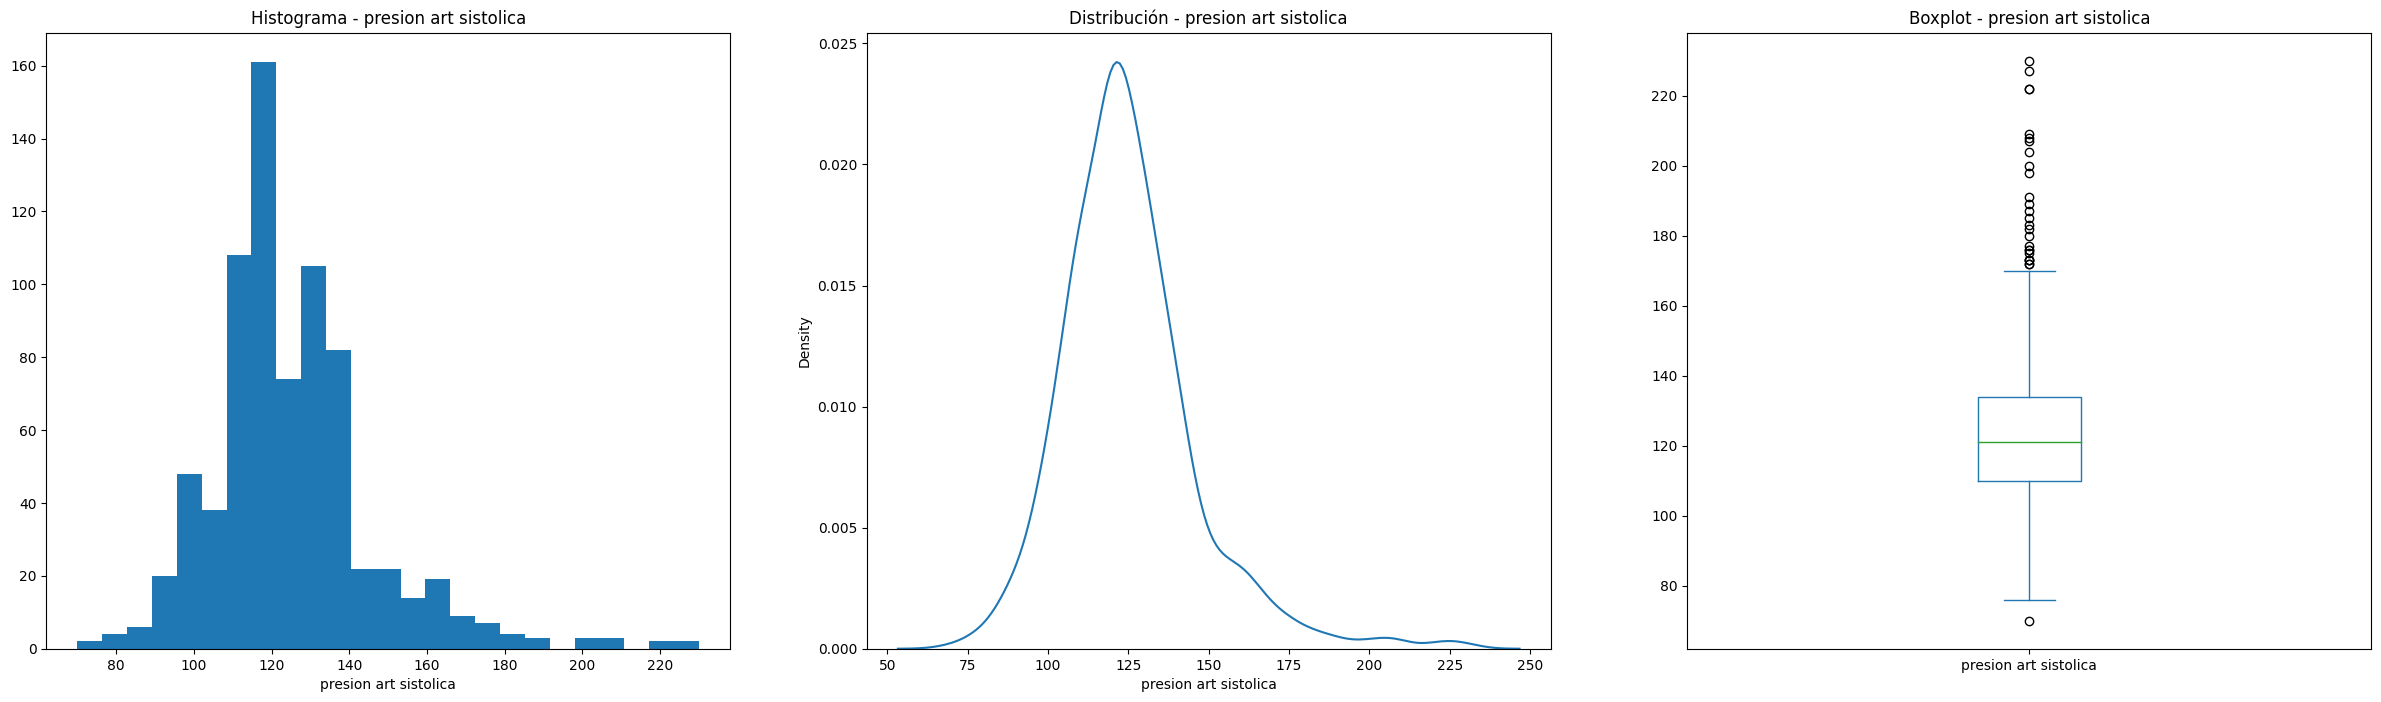

In [ ]:
#presion arterial sistolica
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['presion art sistolica'],25)
plt.xlabel('presion art sistolica')
plt.title('Histograma - presion art sistolica')

plt.subplot(1,3,2)
sns.kdeplot(x = "presion art sistolica", data = dfnum)
plt.xlabel('presion art sistolica')
plt.title('Distribución - presion art sistolica')

plt.subplot(1,3,3)
dfnum['presion art sistolica'].plot(kind='box')
plt.title('Boxplot - presion art sistolica')
plt.show()

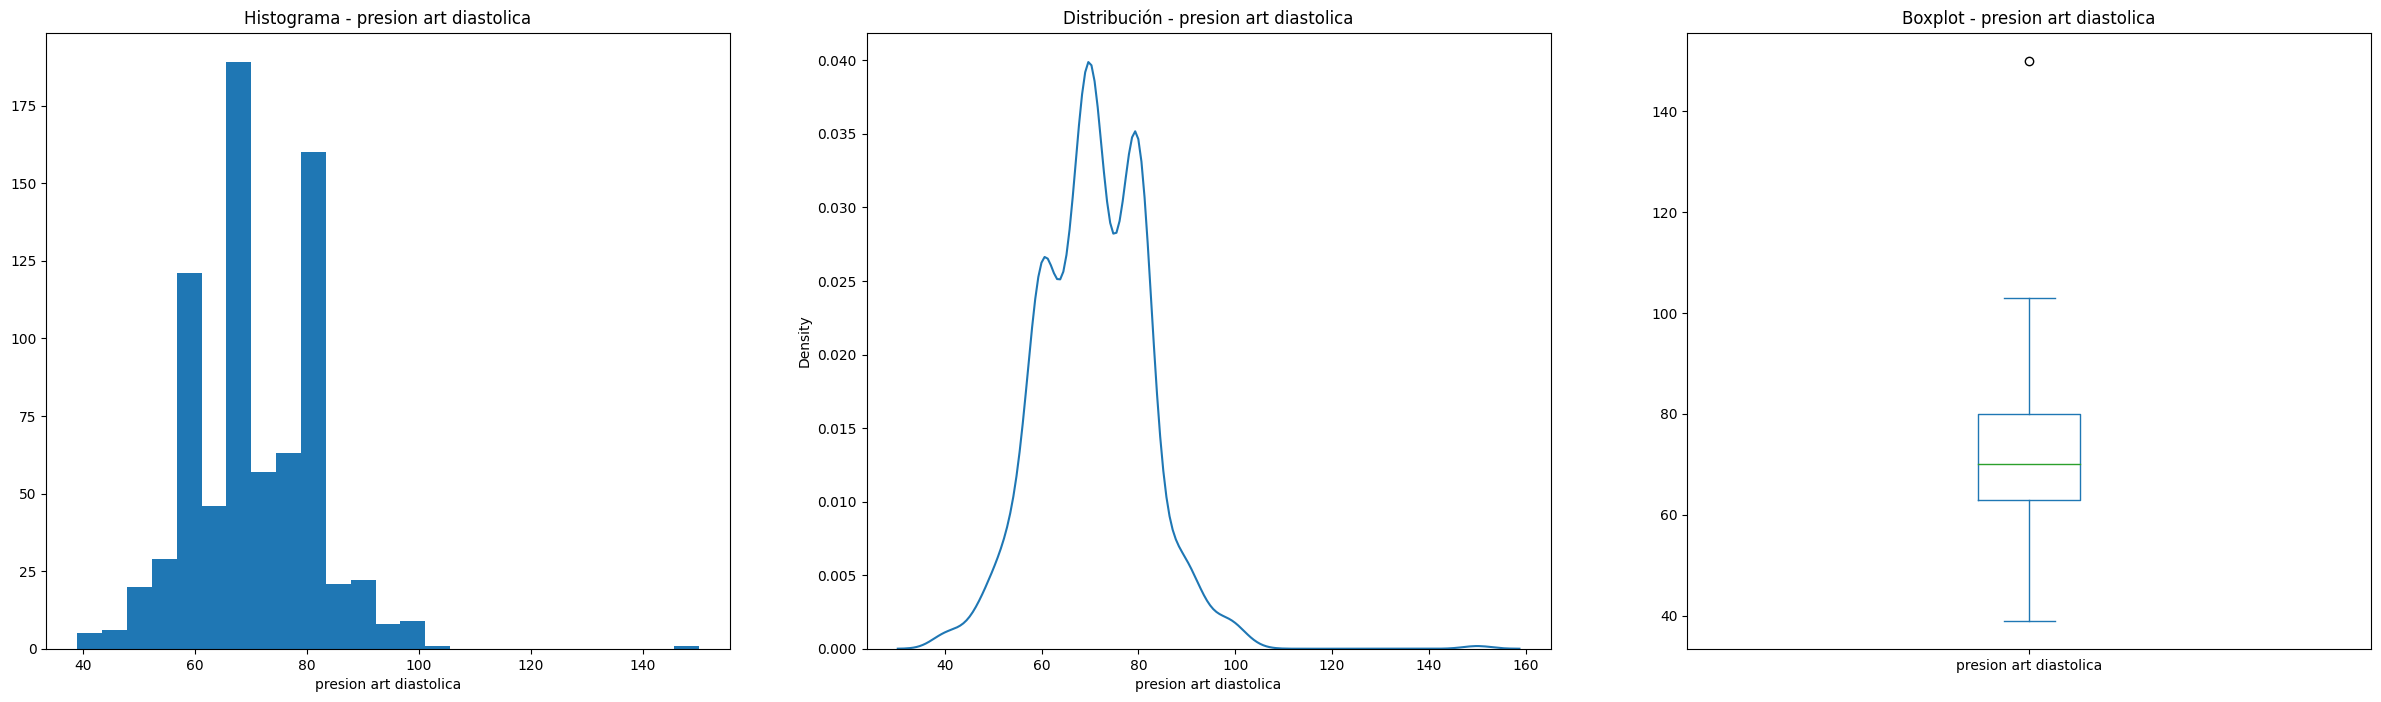

In [ ]:
#presion arterial diastolica
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['presion art diastolica'],25)
plt.xlabel('presion art diastolica')
plt.title('Histograma - presion art diastolica')

plt.subplot(1,3,2)
sns.kdeplot(x = "presion art diastolica", data = dfnum)
plt.xlabel('presion art diastolica')
plt.title('Distribución - presion art diastolica')

plt.subplot(1,3,3)
dfnum['presion art diastolica'].plot(kind='box')
plt.title('Boxplot - presion art diastolica')
plt.show()

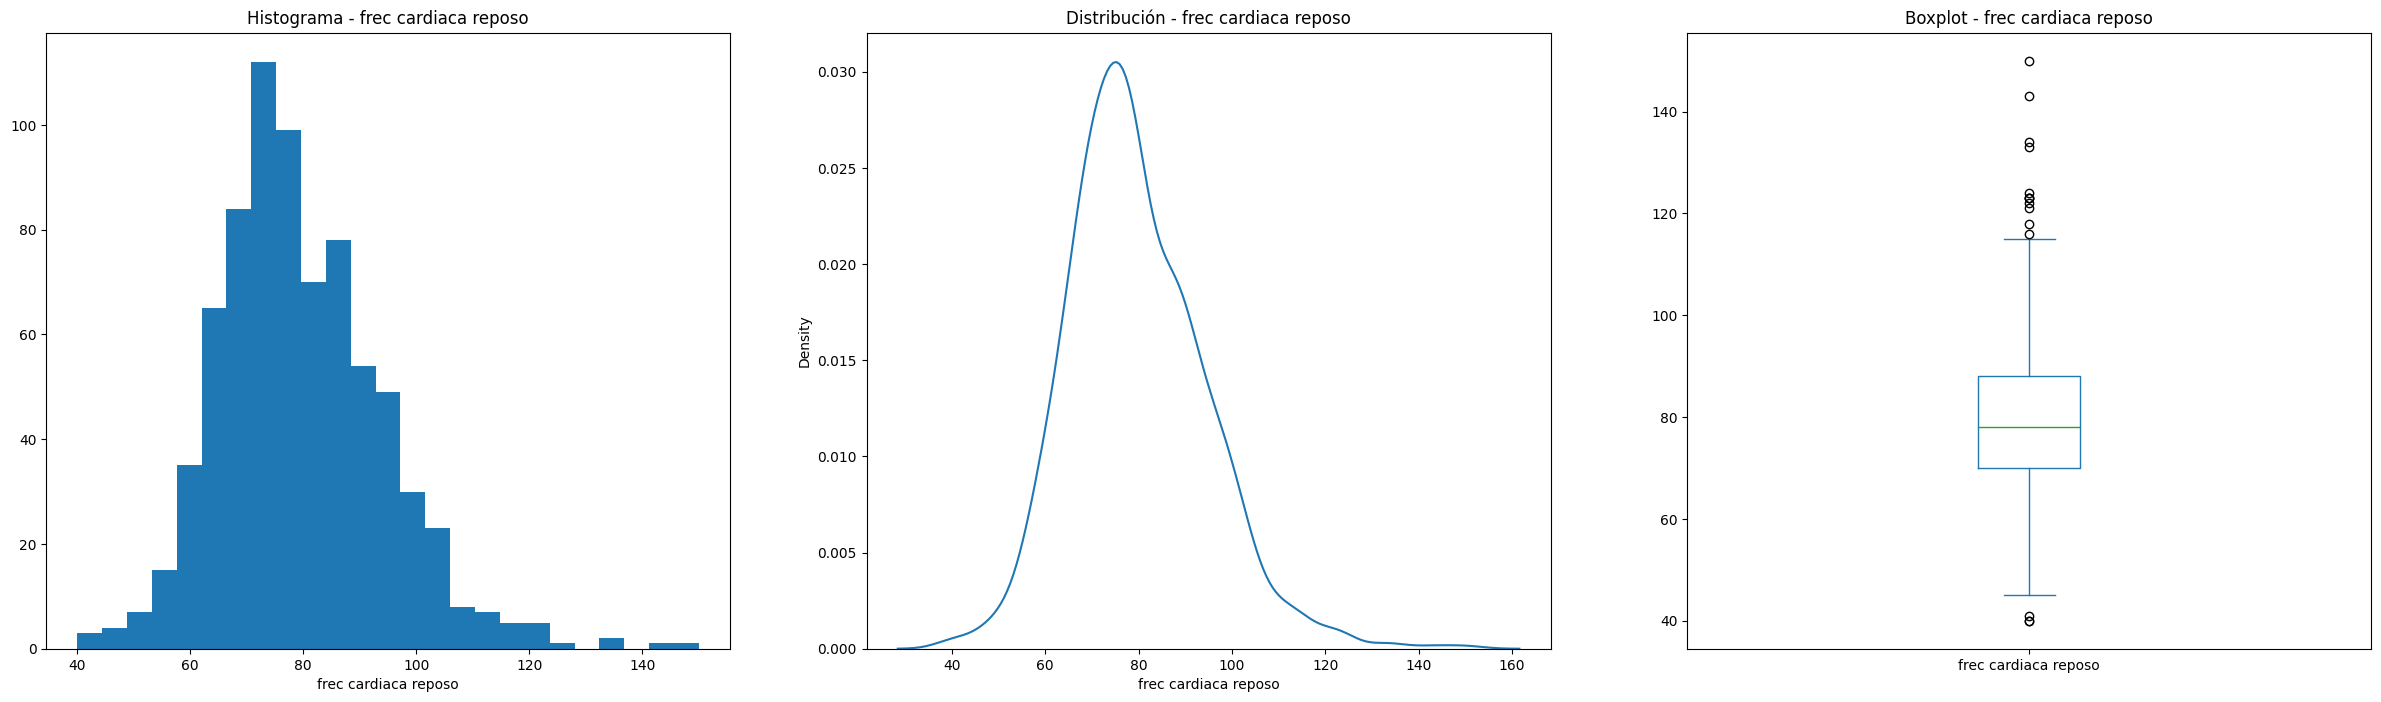

In [ ]:
#frecuecia cardiaca en reposo
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['frec cardiaca reposo'],25)
plt.xlabel('frec cardiaca reposo')
plt.title('Histograma - frec cardiaca reposo')

plt.subplot(1,3,2)
sns.kdeplot(x = "frec cardiaca reposo", data = dfnum)
plt.xlabel('frec cardiaca reposo')
plt.title('Distribución - frec cardiaca reposo')

plt.subplot(1,3,3)
dfnum['frec cardiaca reposo'].plot(kind='box')
plt.title('Boxplot - frec cardiaca reposo')
plt.show()

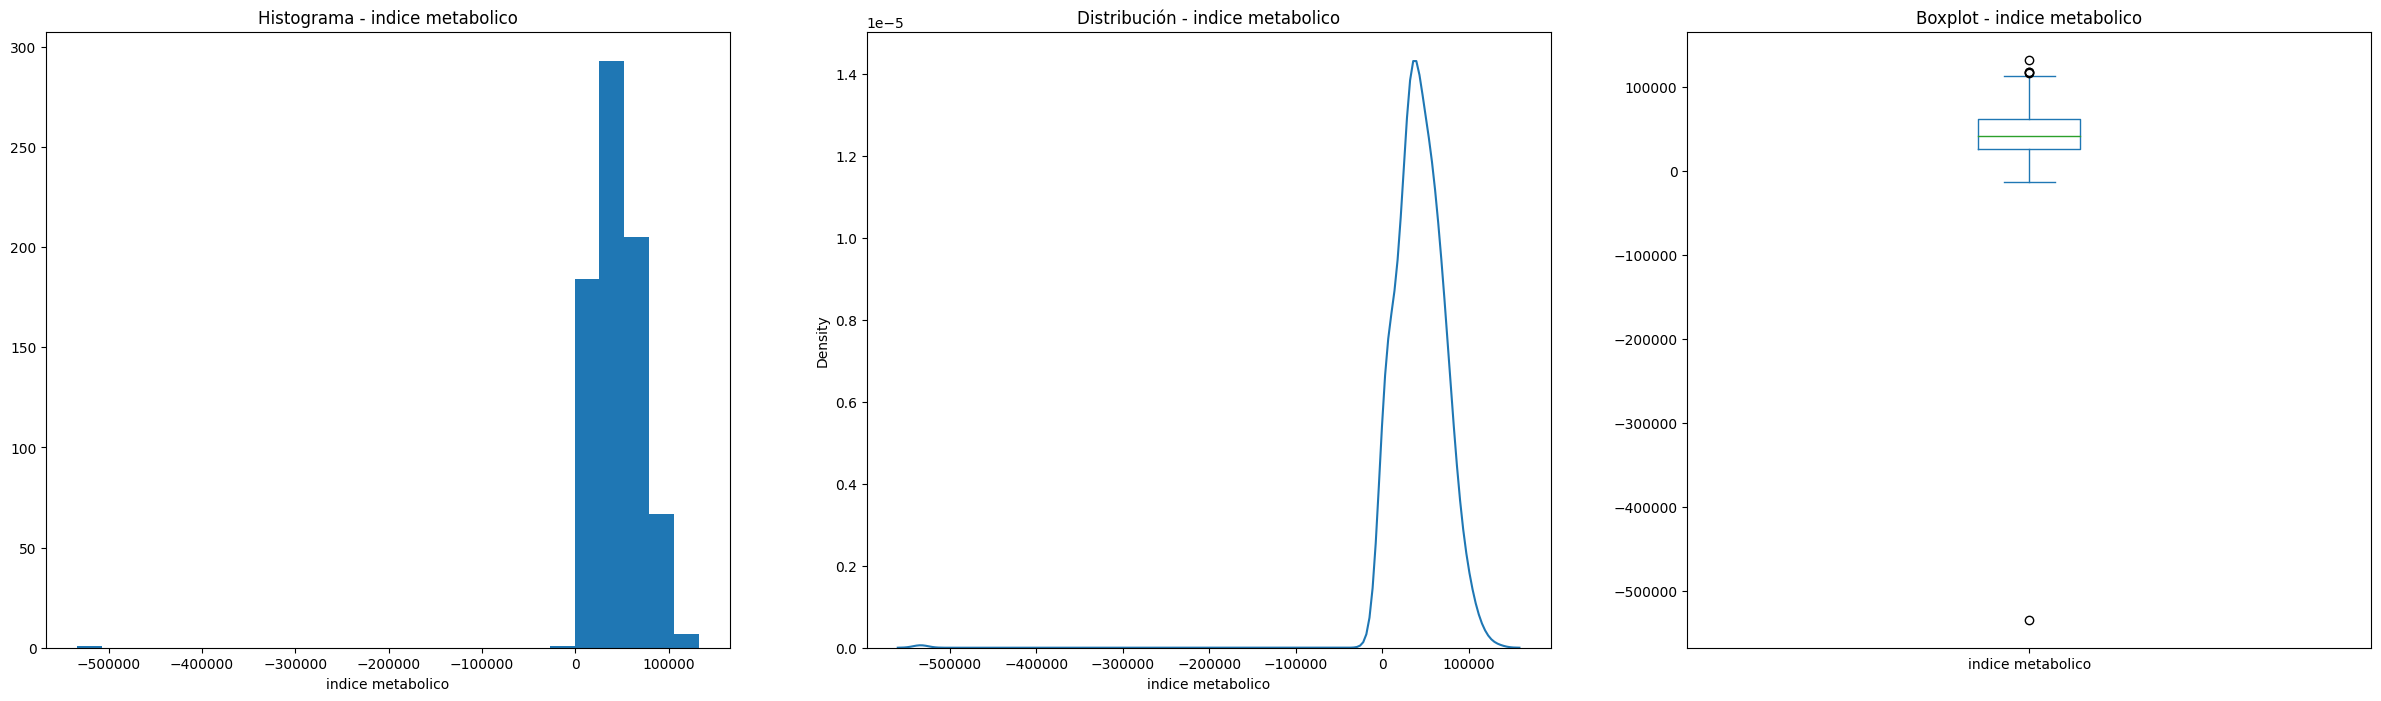

In [ ]:
#indice metabolico

plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['indice metabolico'],25)
plt.xlabel('indice metabolico')
plt.title('Histograma - indice metabolico')

plt.subplot(1,3,2)
sns.kdeplot(x = "indice metabolico", data = dfnum)
plt.xlabel('indice metabolico')
plt.title('Distribución - indice metabolico')

plt.subplot(1,3,3)
dfnum['indice metabolico'].plot(kind='box')
plt.title('Boxplot - indice metabolico')
plt.show()

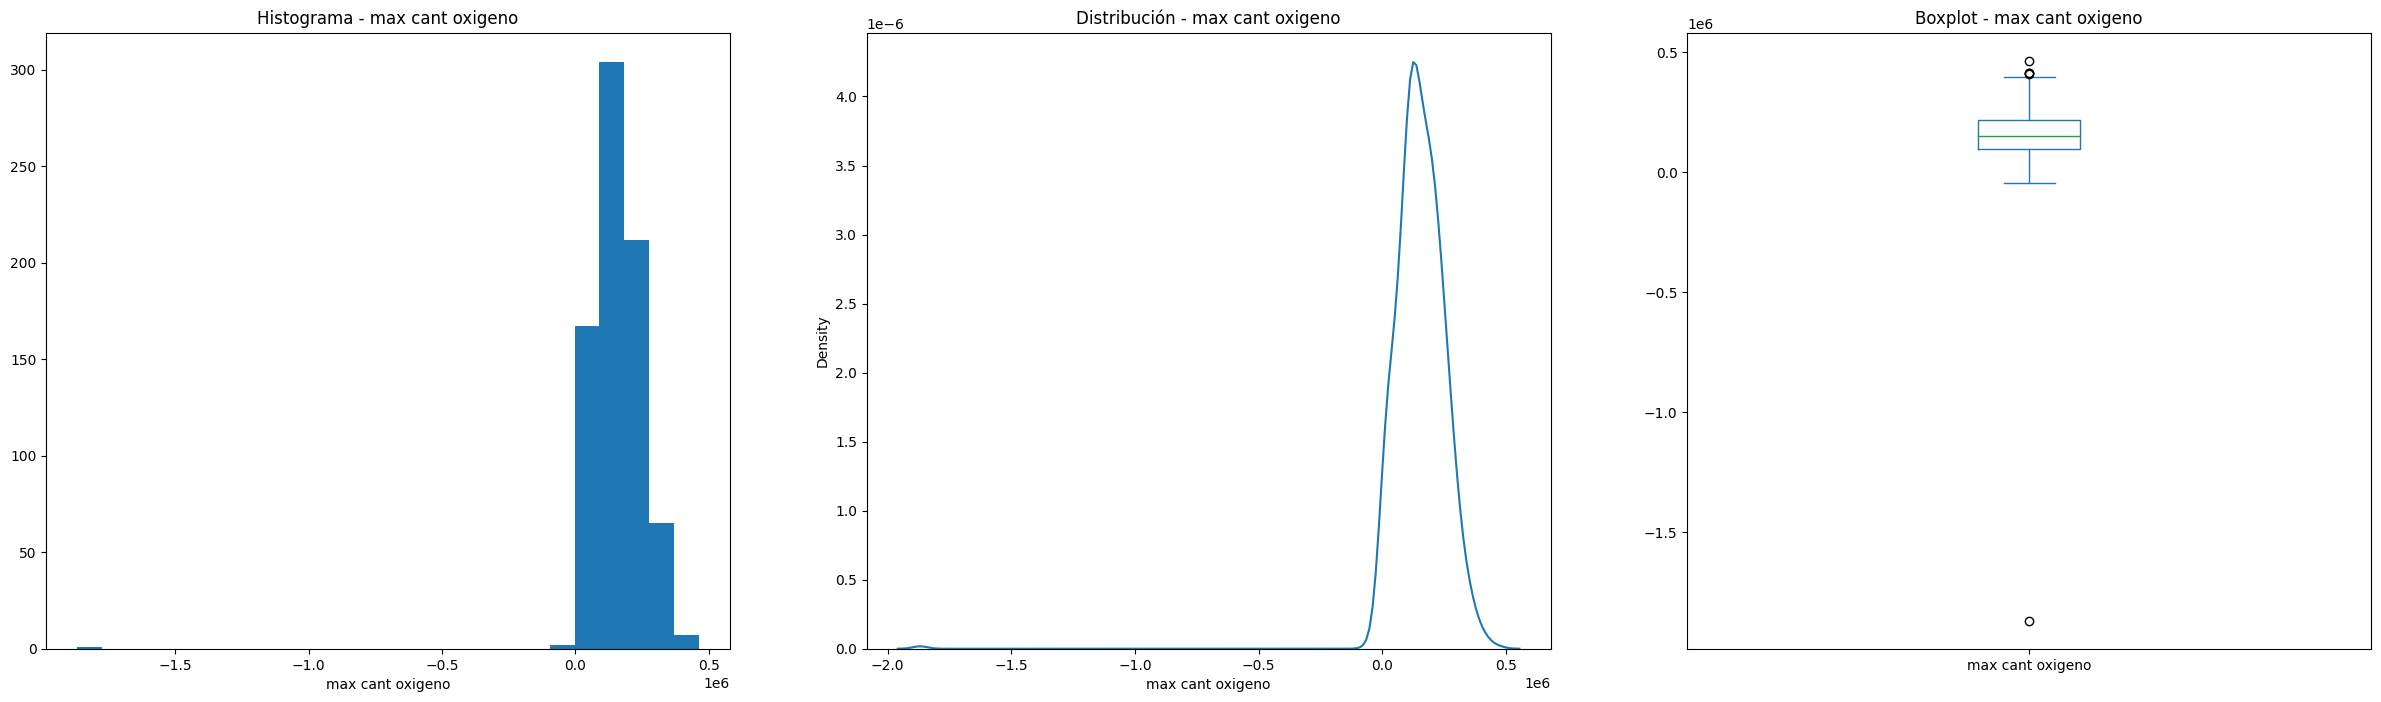

In [ ]:
#cant max oxigen
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['max cant oxigeno'],25)
plt.xlabel('max cant oxigeno')
plt.title('Histograma - max cant oxigeno')

plt.subplot(1,3,2)
sns.kdeplot(x = "max cant oxigeno", data = dfnum)
plt.xlabel('max cant oxigeno')
plt.title('Distribución - max cant oxigeno')

plt.subplot(1,3,3)
dfnum['max cant oxigeno'].plot(kind='box')
plt.title('Boxplot - max cant oxigeno')
plt.show()

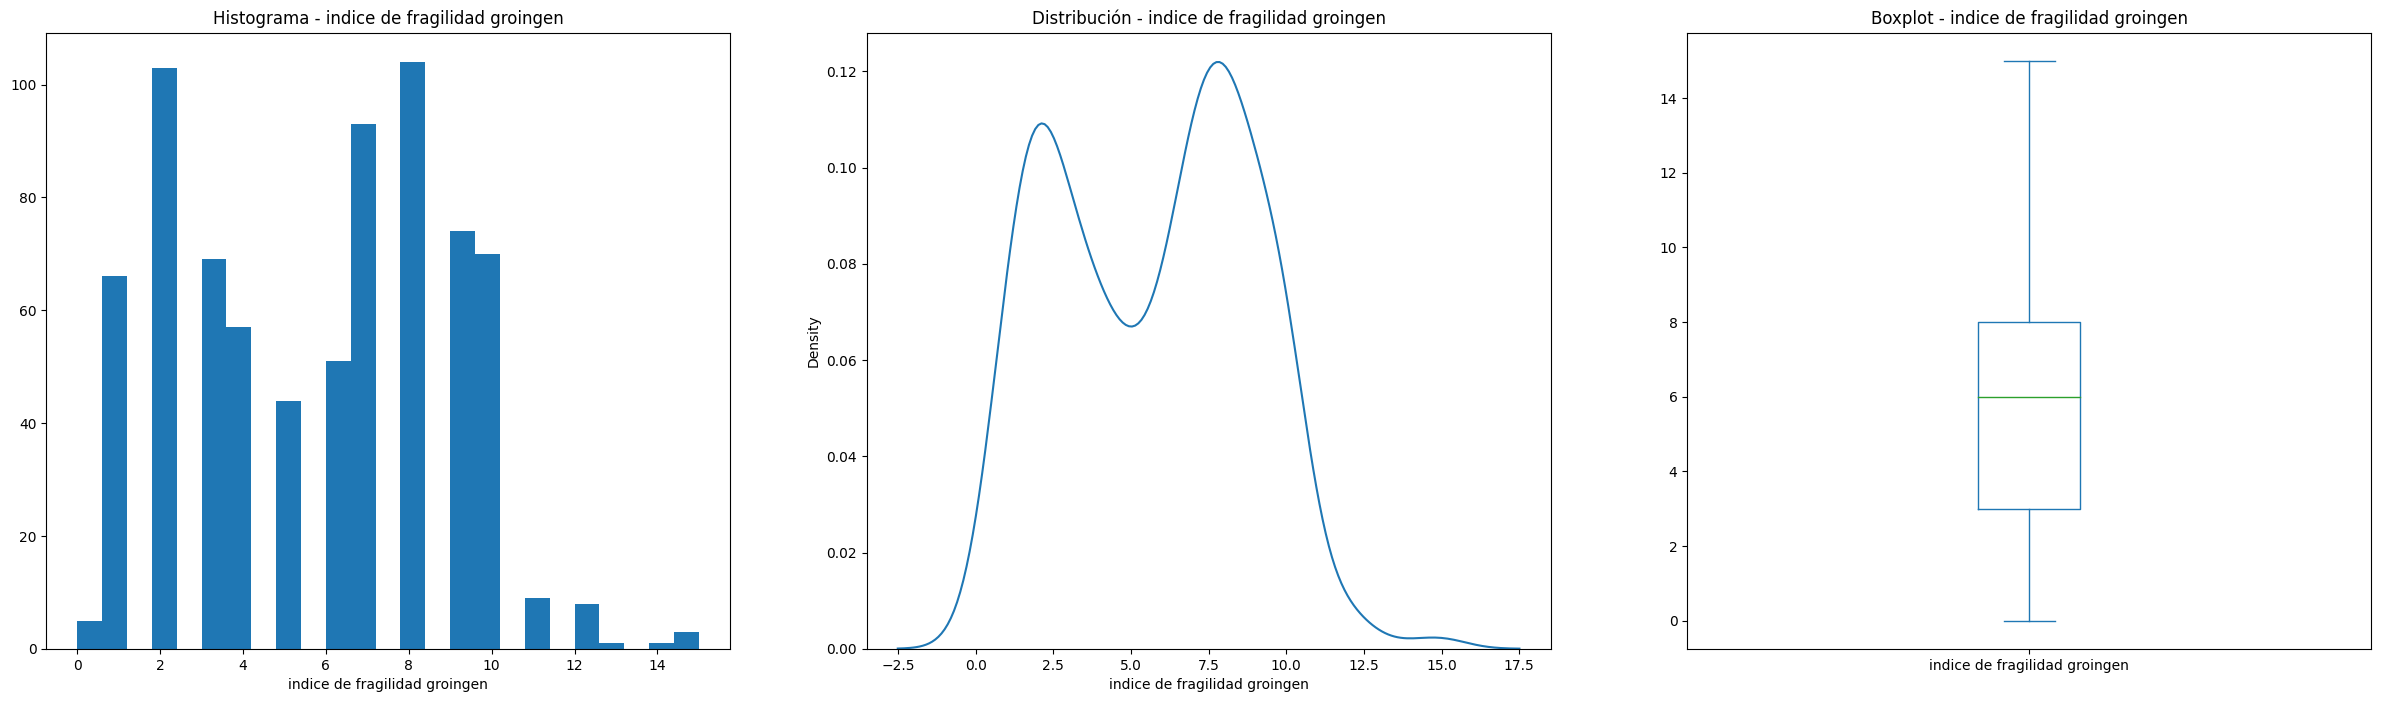

In [ ]:
#indice de fragilidad groingen
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['indice de fragilidad groingen'],25)
plt.xlabel('indice de fragilidad groingen')
plt.title('Histograma - indice de fragilidad groingen')

plt.subplot(1,3,2)
sns.kdeplot(x = "indice de fragilidad groingen", data = dfnum)
plt.xlabel('indice de fragilidad groingen')
plt.title('Distribución - indice de fragilidad groingen')

plt.subplot(1,3,3)
dfnum['indice de fragilidad groingen'].plot(kind='box')
plt.title('Boxplot - indice de fragilidad groingen')
plt.show()

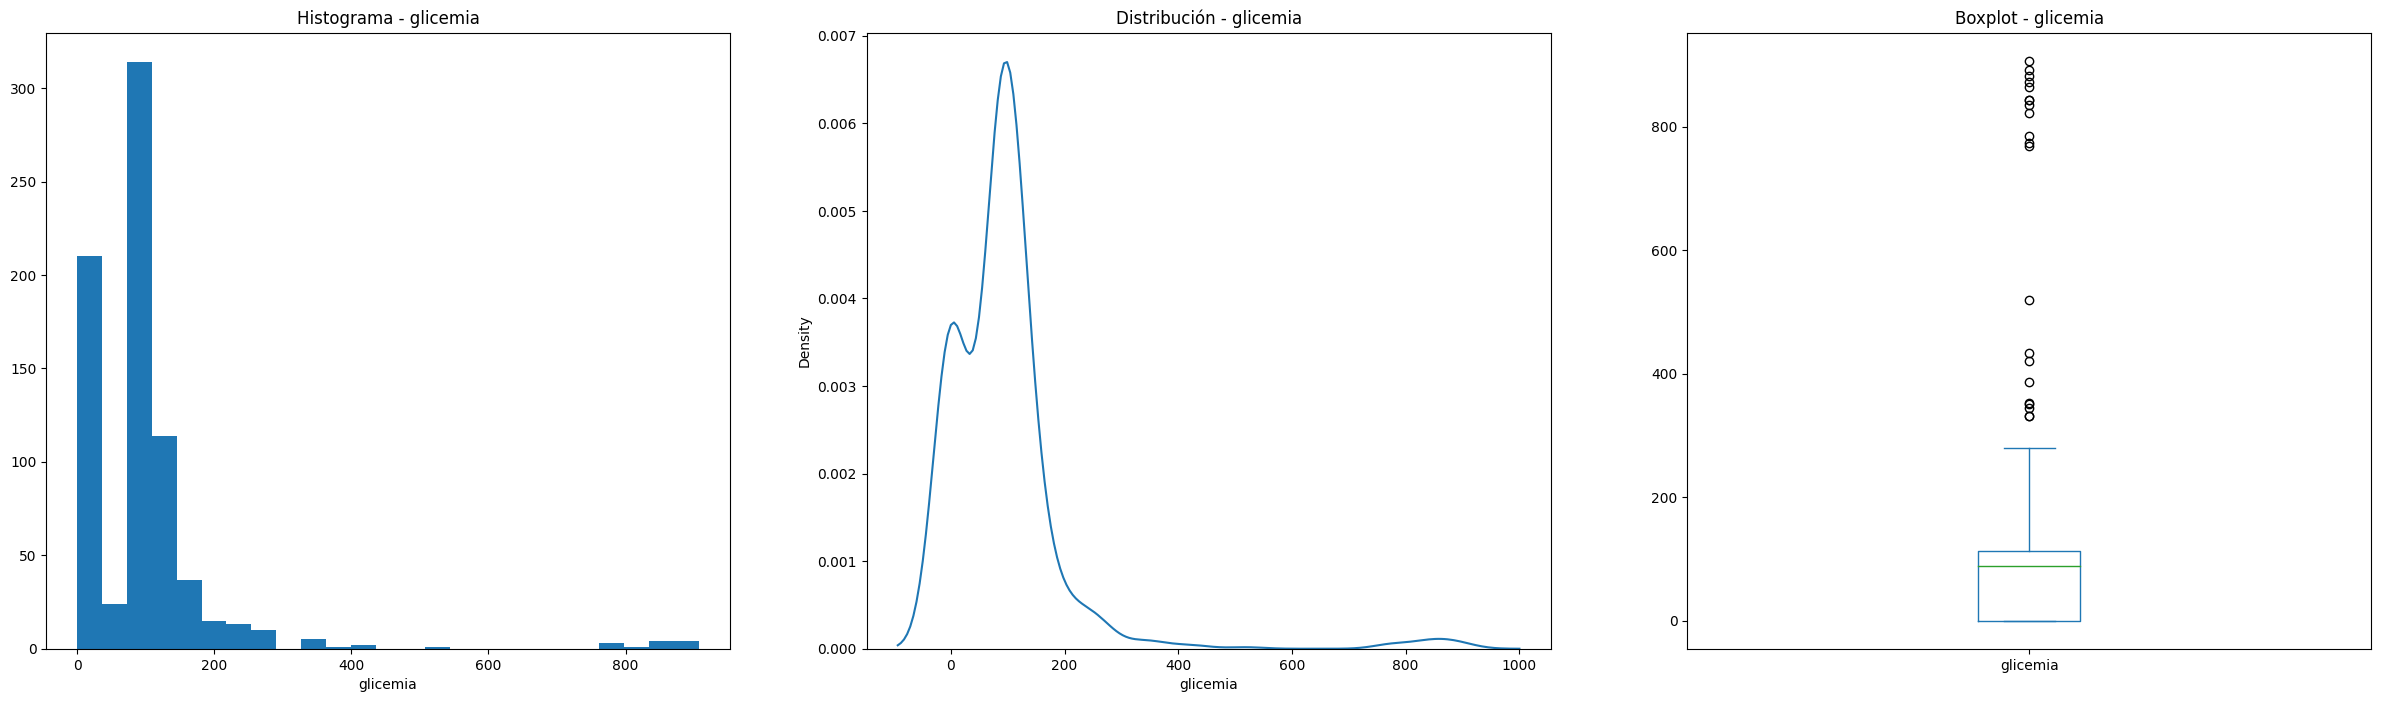

In [ ]:
#glicemia
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['glicemia'],25)
plt.xlabel('glicemia')
plt.title('Histograma - glicemia')

plt.subplot(1,3,2)
sns.kdeplot(x = "glicemia", data = dfnum)
plt.xlabel('glicemia')
plt.title('Distribución - glicemia')

plt.subplot(1,3,3)
dfnum['glicemia'].plot(kind='box')
plt.title('Boxplot - glicemia')
plt.show()

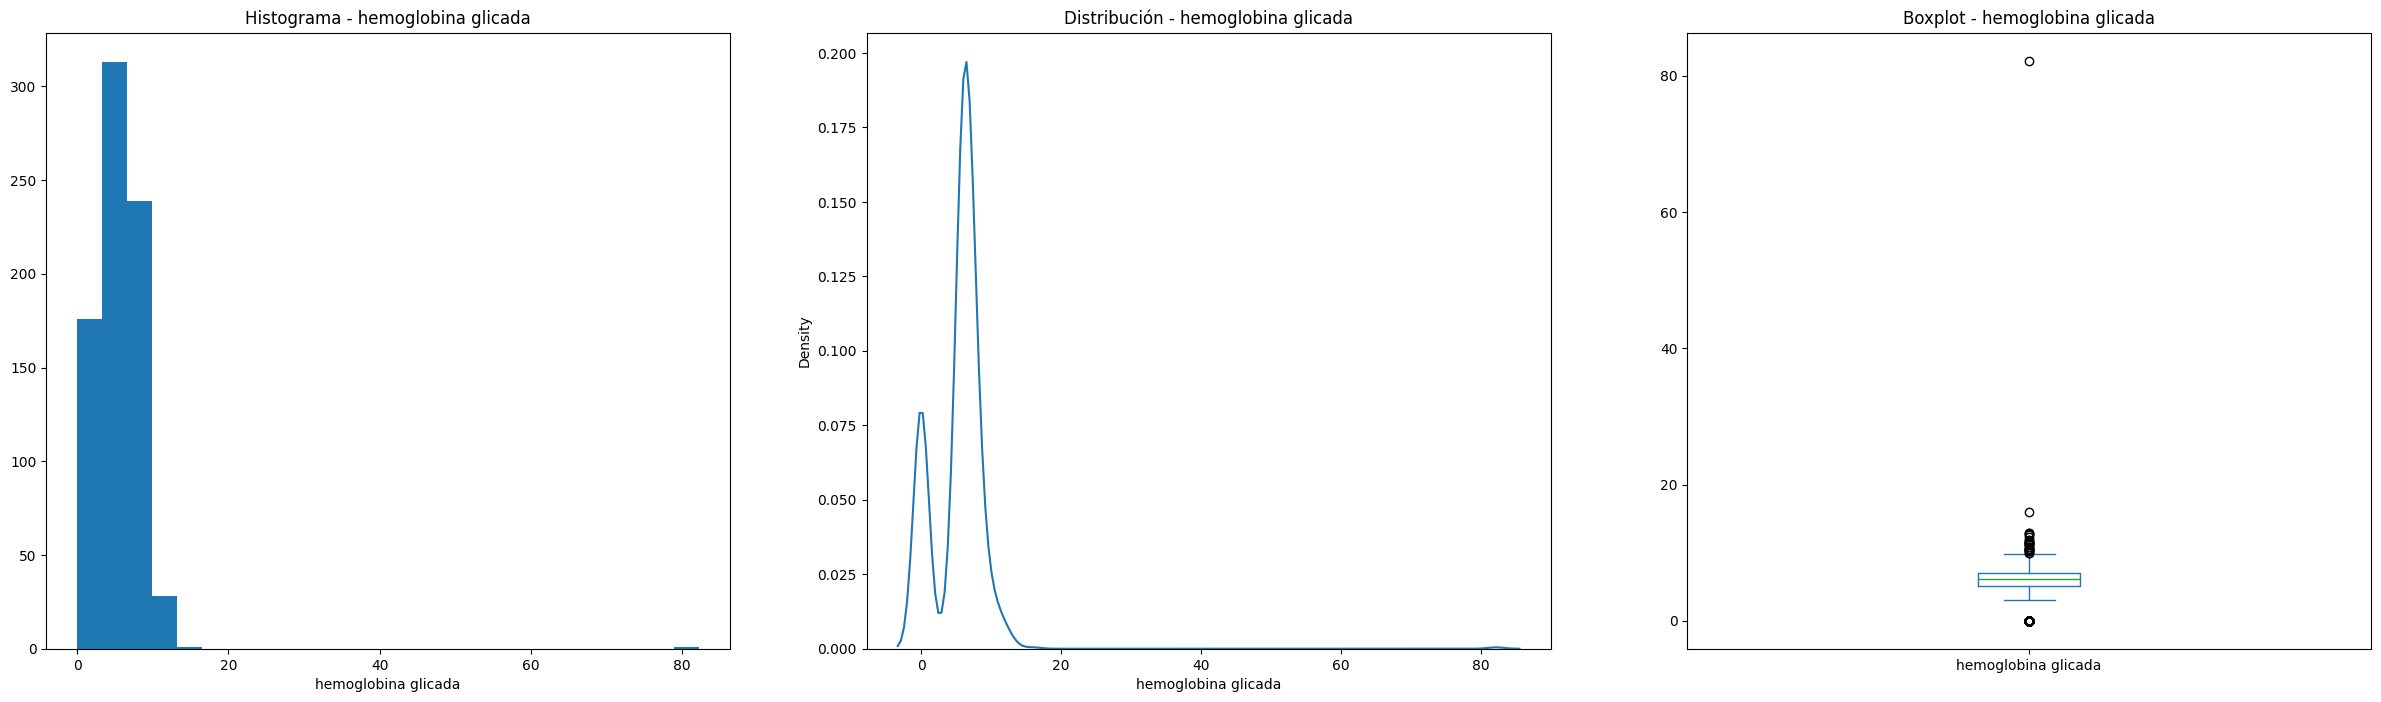

In [ ]:
#hemoglobina glicada
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['hemoglobina glicada'],25)
plt.xlabel('hemoglobina glicada')
plt.title('Histograma - hemoglobina glicada')

plt.subplot(1,3,2)
sns.kdeplot(x = "hemoglobina glicada", data = dfnum)
plt.xlabel('hemoglobina glicada')
plt.title('Distribución - hemoglobina glicada')

plt.subplot(1,3,3)
dfnum['hemoglobina glicada'].plot(kind='box')
plt.title('Boxplot - hemoglobina glicada')
plt.show()

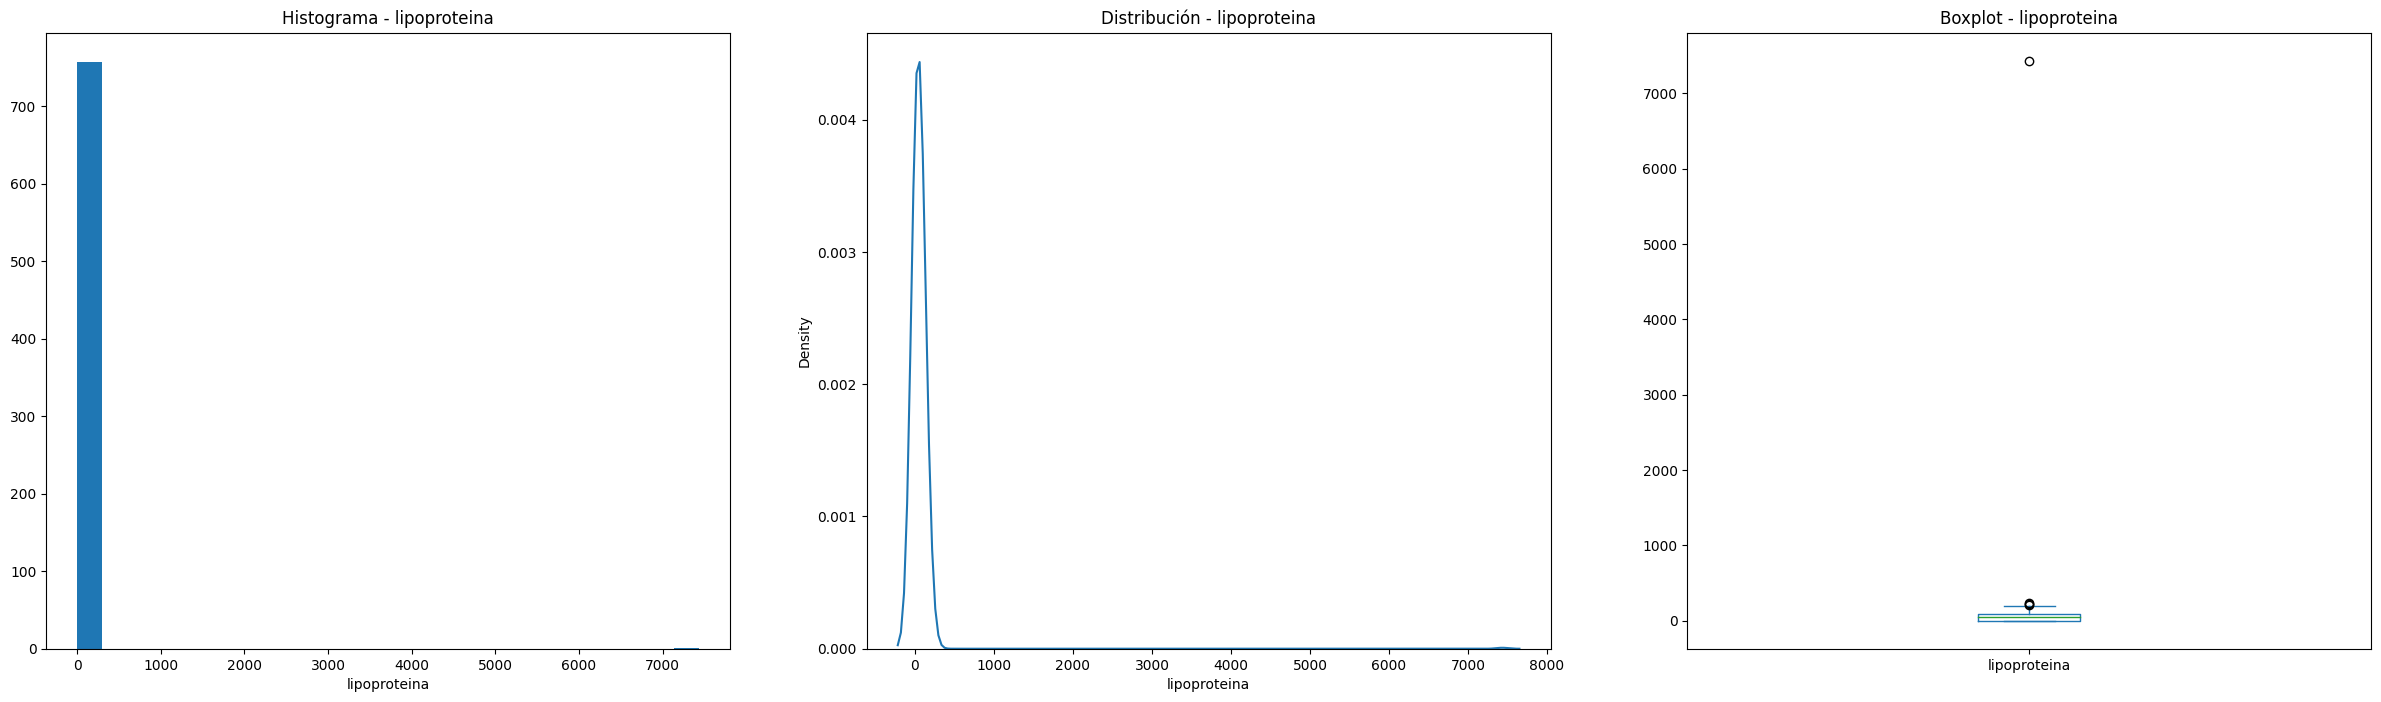

In [ ]:
#lipoproteina
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['lipoproteina'],25)
plt.xlabel('lipoproteina')
plt.title('Histograma - lipoproteina')

plt.subplot(1,3,2)
sns.kdeplot(x = "lipoproteina", data = dfnum)
plt.xlabel('lipoproteina')
plt.title('Distribución - lipoproteina')

plt.subplot(1,3,3)
dfnum['lipoproteina'].plot(kind='box')
plt.title('Boxplot - lipoproteina')
plt.show()

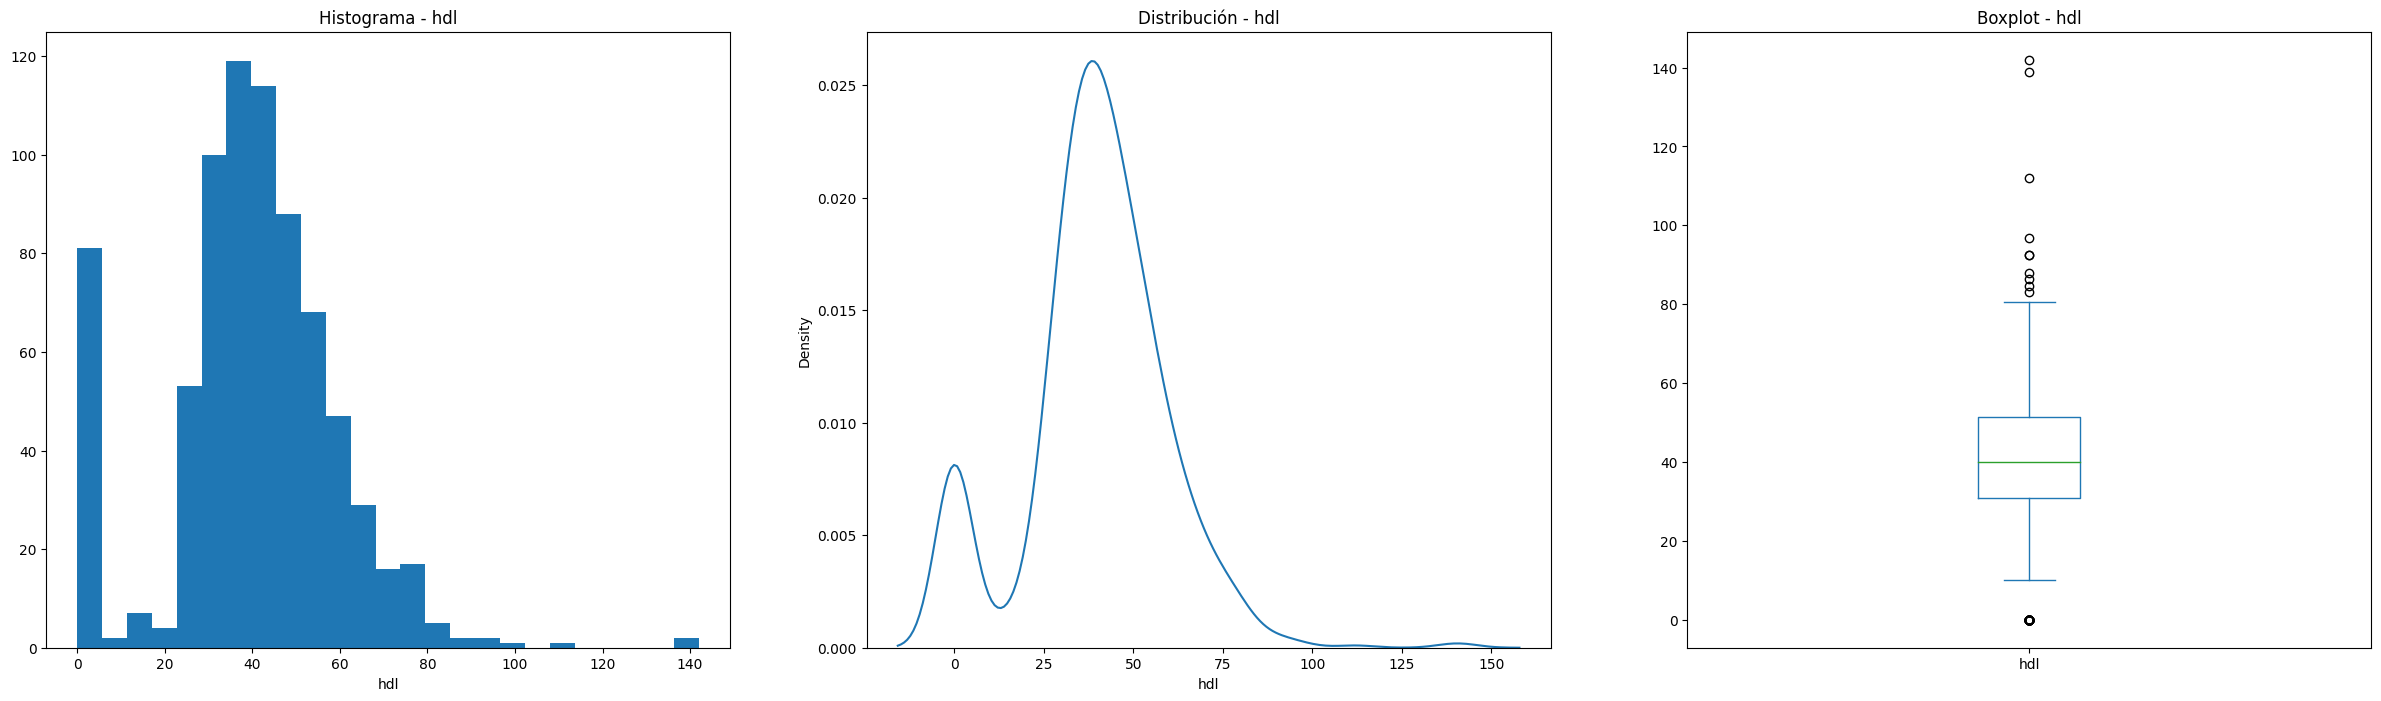

In [ ]:
#hdl
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['hdl'],25)
plt.xlabel('hdl')
plt.title('Histograma - hdl')

plt.subplot(1,3,2)
sns.kdeplot(x = "hdl", data = dfnum)
plt.xlabel('hdl')
plt.title('Distribución - hdl')

plt.subplot(1,3,3)
dfnum['hdl'].plot(kind='box')
plt.title('Boxplot - hdl')
plt.show()

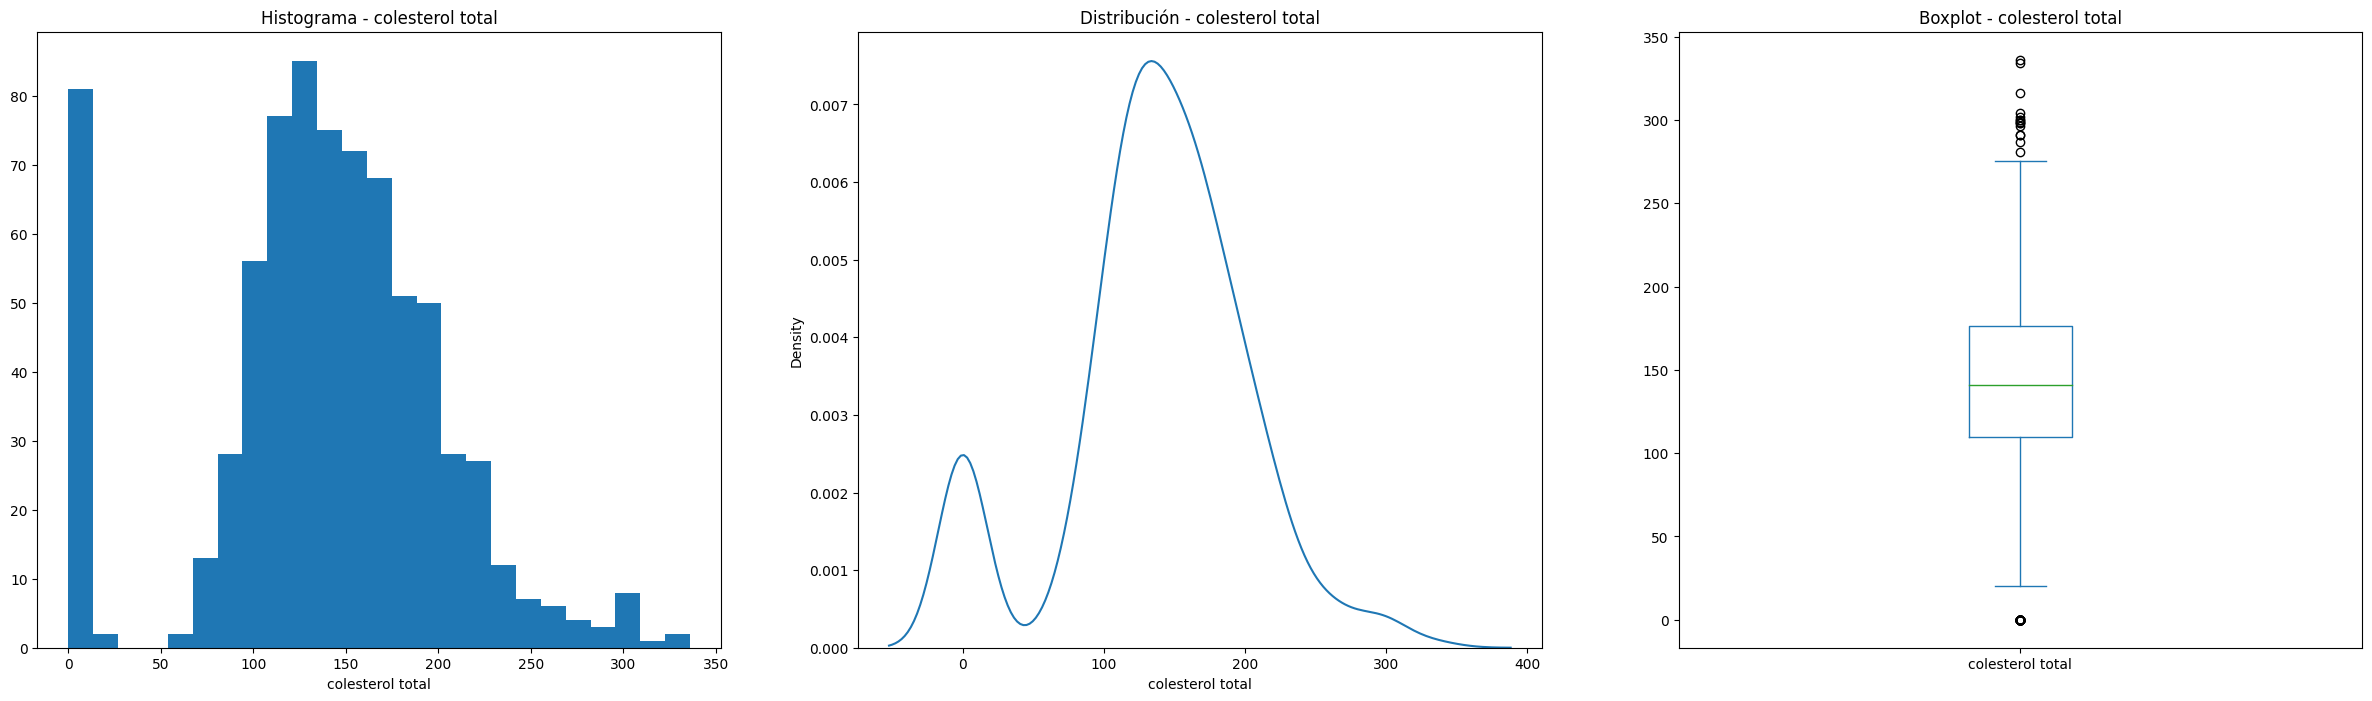

In [ ]:
#colesterol total
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['colesterol total'],25)
plt.xlabel('colesterol total')
plt.title('Histograma - colesterol total')

plt.subplot(1,3,2)
sns.kdeplot(x = "colesterol total", data = dfnum)
plt.xlabel('colesterol total')
plt.title('Distribución - colesterol total')

plt.subplot(1,3,3)
dfnum['colesterol total'].plot(kind='box')
plt.title('Boxplot - colesterol total')
plt.show()

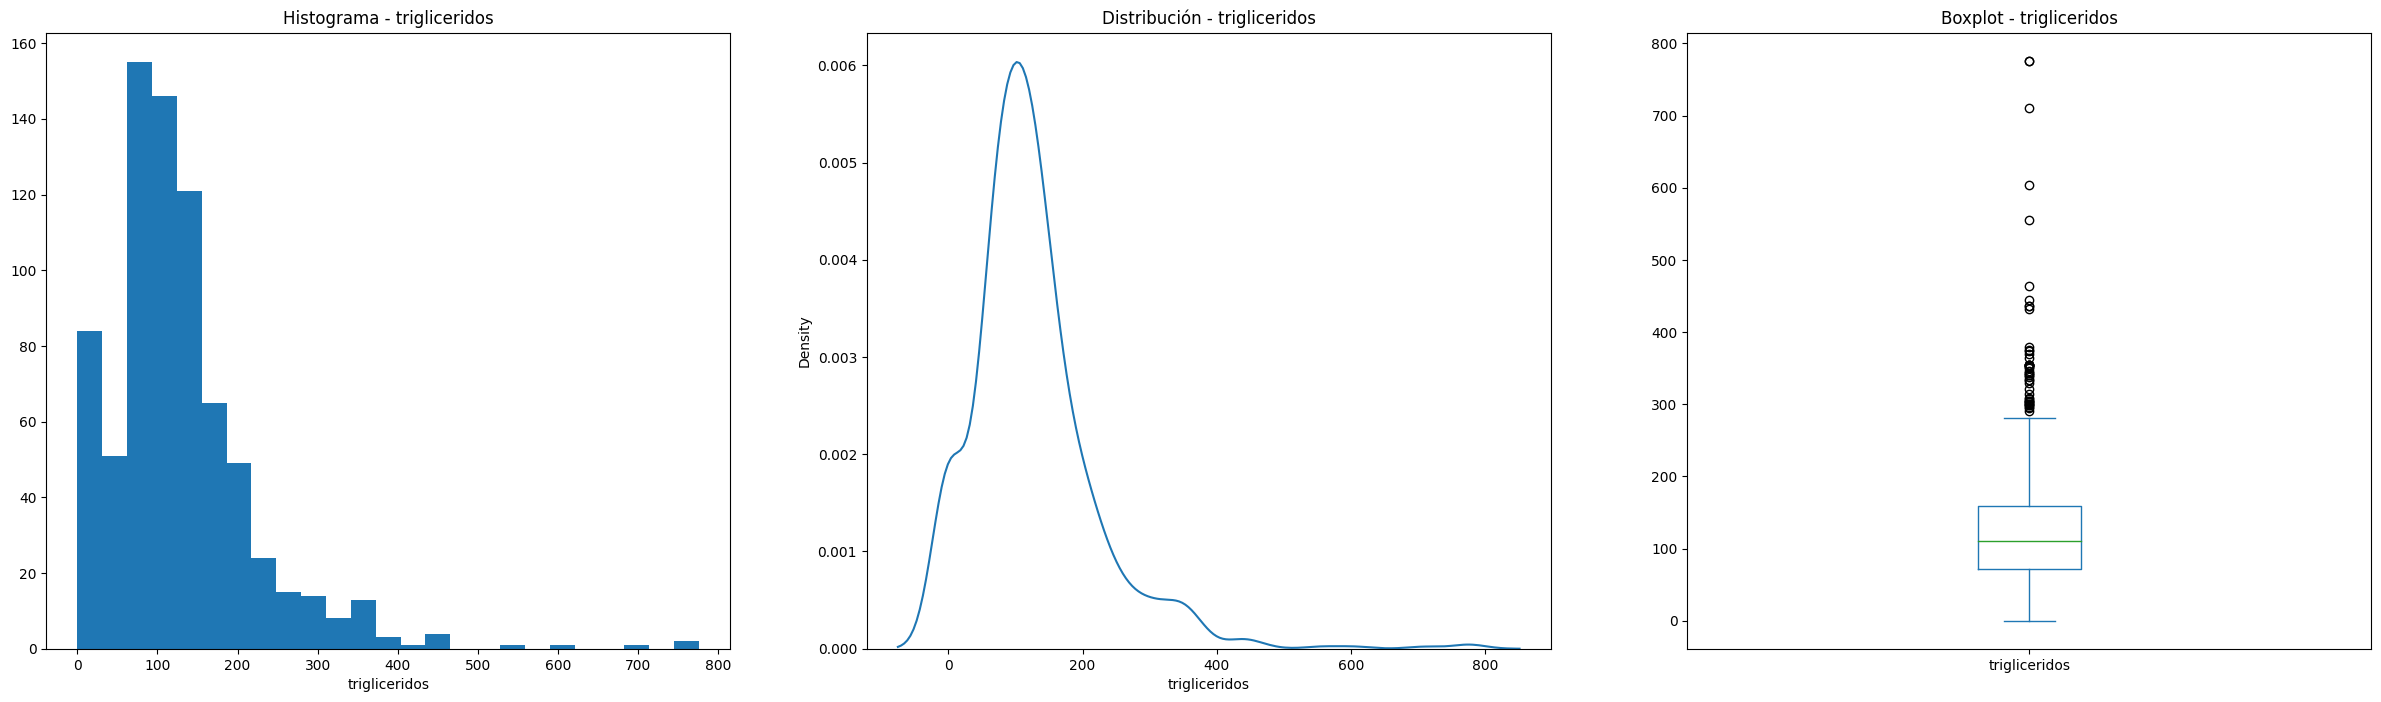

In [ ]:
#trigliceridos
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['trigliceridos'],25)
plt.xlabel('trigliceridos')
plt.title('Histograma - trigliceridos')

plt.subplot(1,3,2)
sns.kdeplot(x = "trigliceridos", data = dfnum)
plt.xlabel('trigliceridos')
plt.title('Distribución - trigliceridos')

plt.subplot(1,3,3)
dfnum['trigliceridos'].plot(kind='box')
plt.title('Boxplot - trigliceridos')
plt.show()

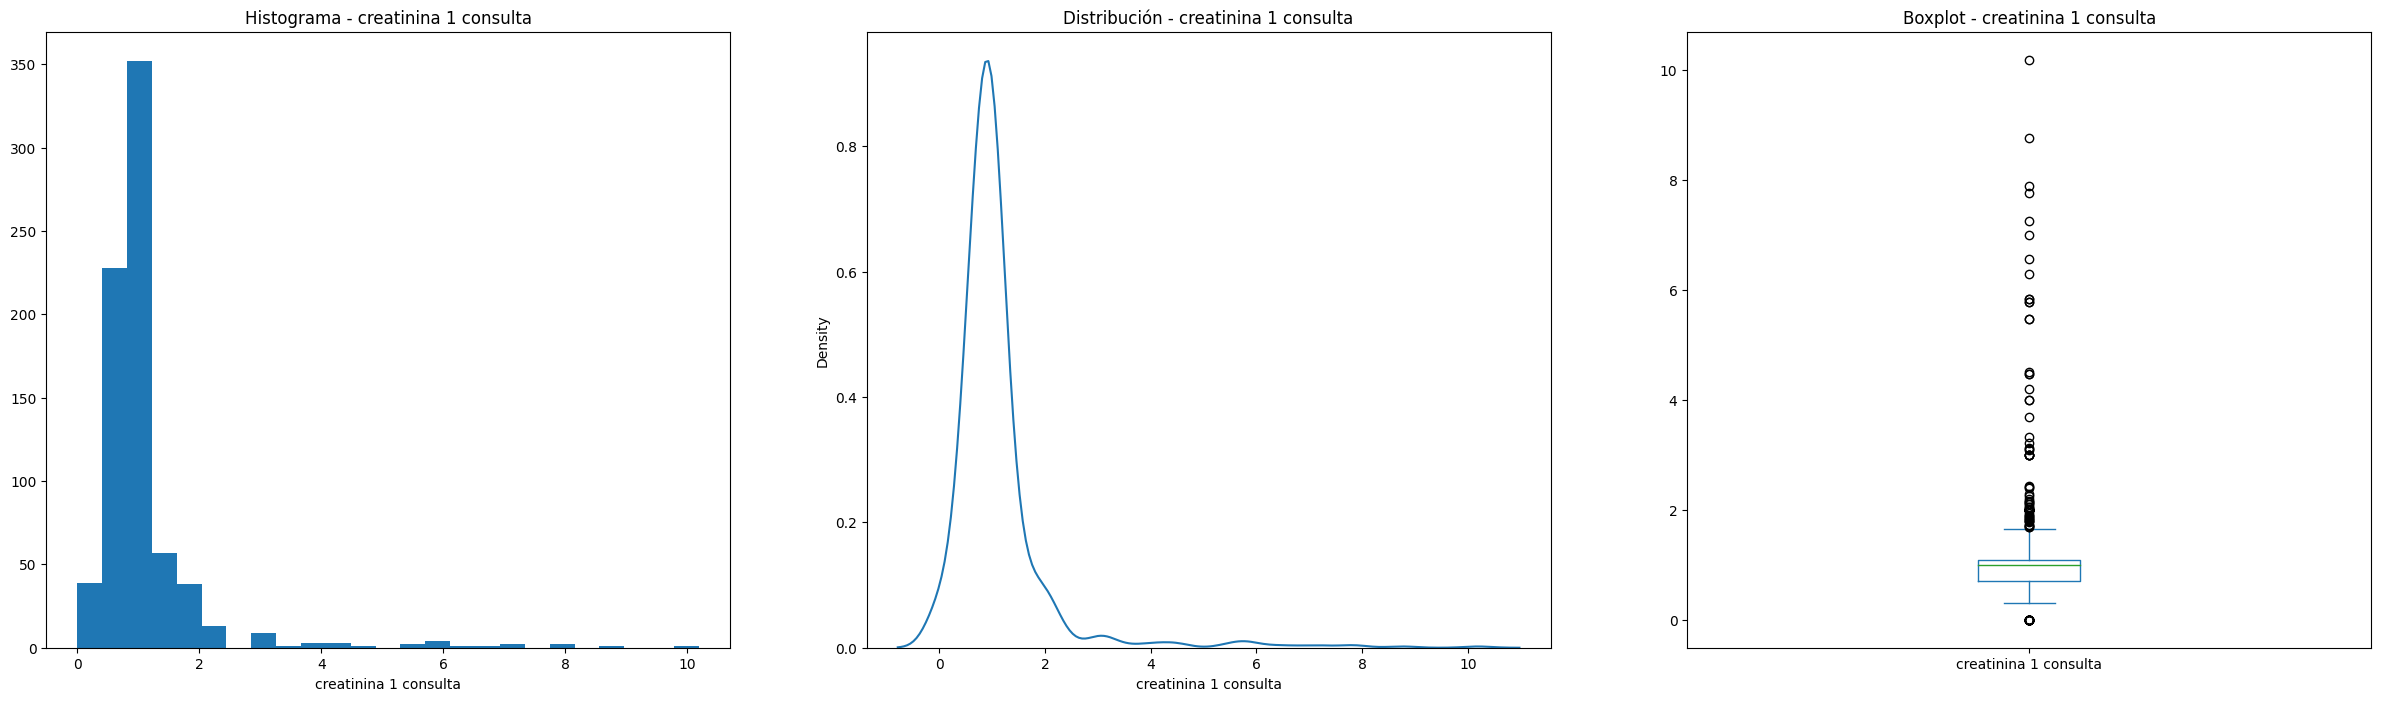

In [ ]:
#creatinina 1 consulta
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['creatinina 1 consulta'],25)
plt.xlabel('creatinina 1 consulta')
plt.title('Histograma - creatinina 1 consulta')

plt.subplot(1,3,2)
sns.kdeplot(x = "creatinina 1 consulta", data = dfnum)
plt.xlabel('creatinina 1 consulta')
plt.title('Distribución - creatinina 1 consulta')

plt.subplot(1,3,3)
dfnum['creatinina 1 consulta'].plot(kind='box')
plt.title('Boxplot - creatinina 1 consulta')
plt.show()

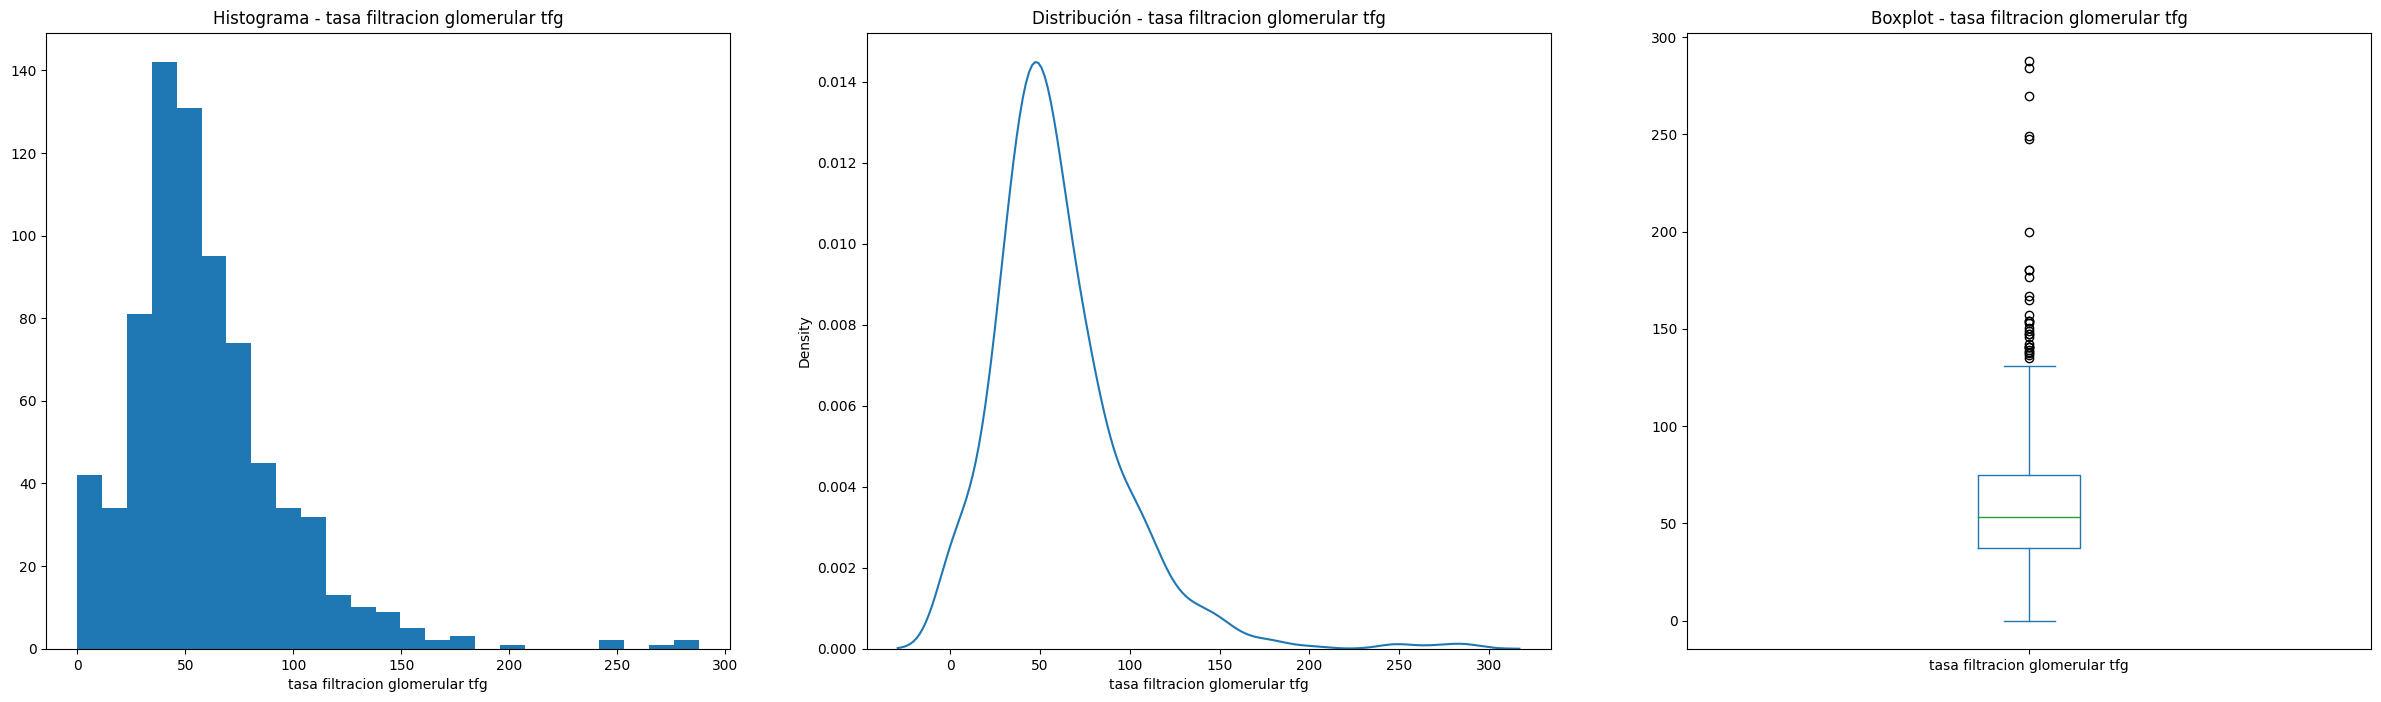

In [ ]:
#filtracion glomerular tfg
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['tasa filtracion glomerular tfg'],25)
plt.xlabel('tasa filtracion glomerular tfg')
plt.title('Histograma - tasa filtracion glomerular tfg')

plt.subplot(1,3,2)
sns.kdeplot(x = "tasa filtracion glomerular tfg", data = dfnum)
plt.xlabel('tasa filtracion glomerular tfg')
plt.title('Distribución - tasa filtracion glomerular tfg')

plt.subplot(1,3,3)
dfnum['tasa filtracion glomerular tfg'].plot(kind='box')
plt.title('Boxplot - tasa filtracion glomerular tfg')
plt.show()

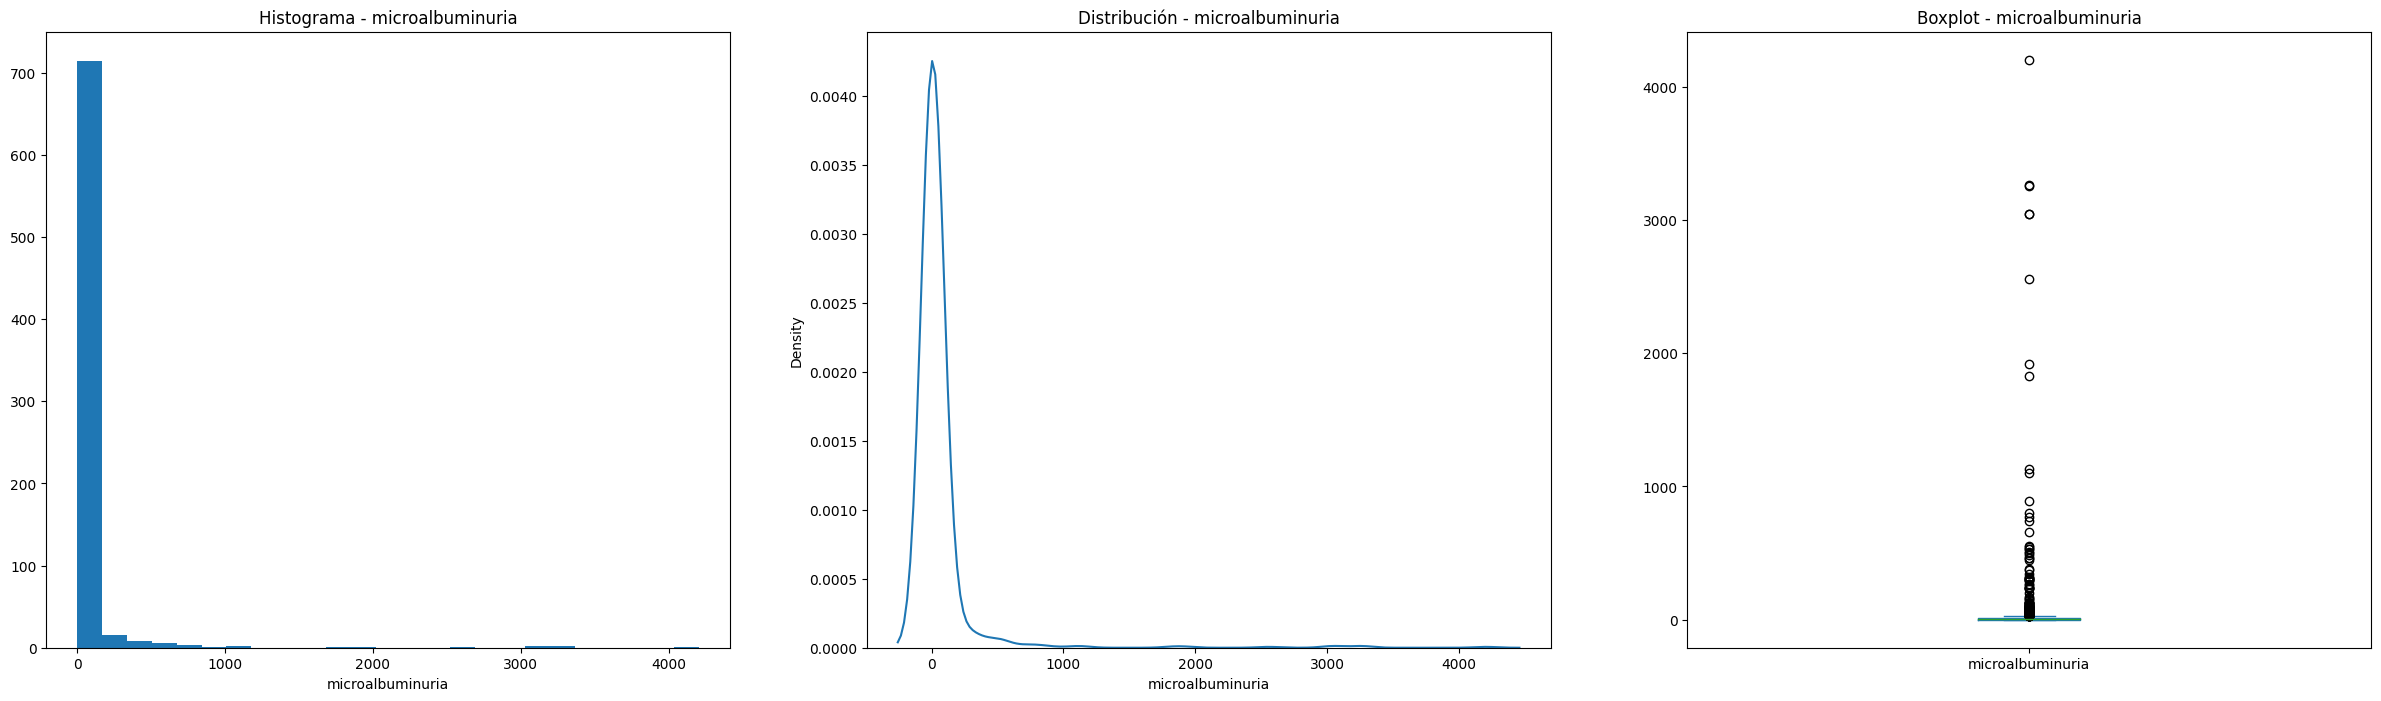

In [ ]:
#microalbuminuria
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['microalbuminuria'],25)
plt.xlabel('microalbuminuria')
plt.title('Histograma - microalbuminuria')

plt.subplot(1,3,2)
sns.kdeplot(x = "microalbuminuria", data = dfnum)
plt.xlabel('microalbuminuria')
plt.title('Distribución - microalbuminuria')

plt.subplot(1,3,3)
dfnum['microalbuminuria'].plot(kind='box')
plt.title('Boxplot - microalbuminuria')
plt.show()

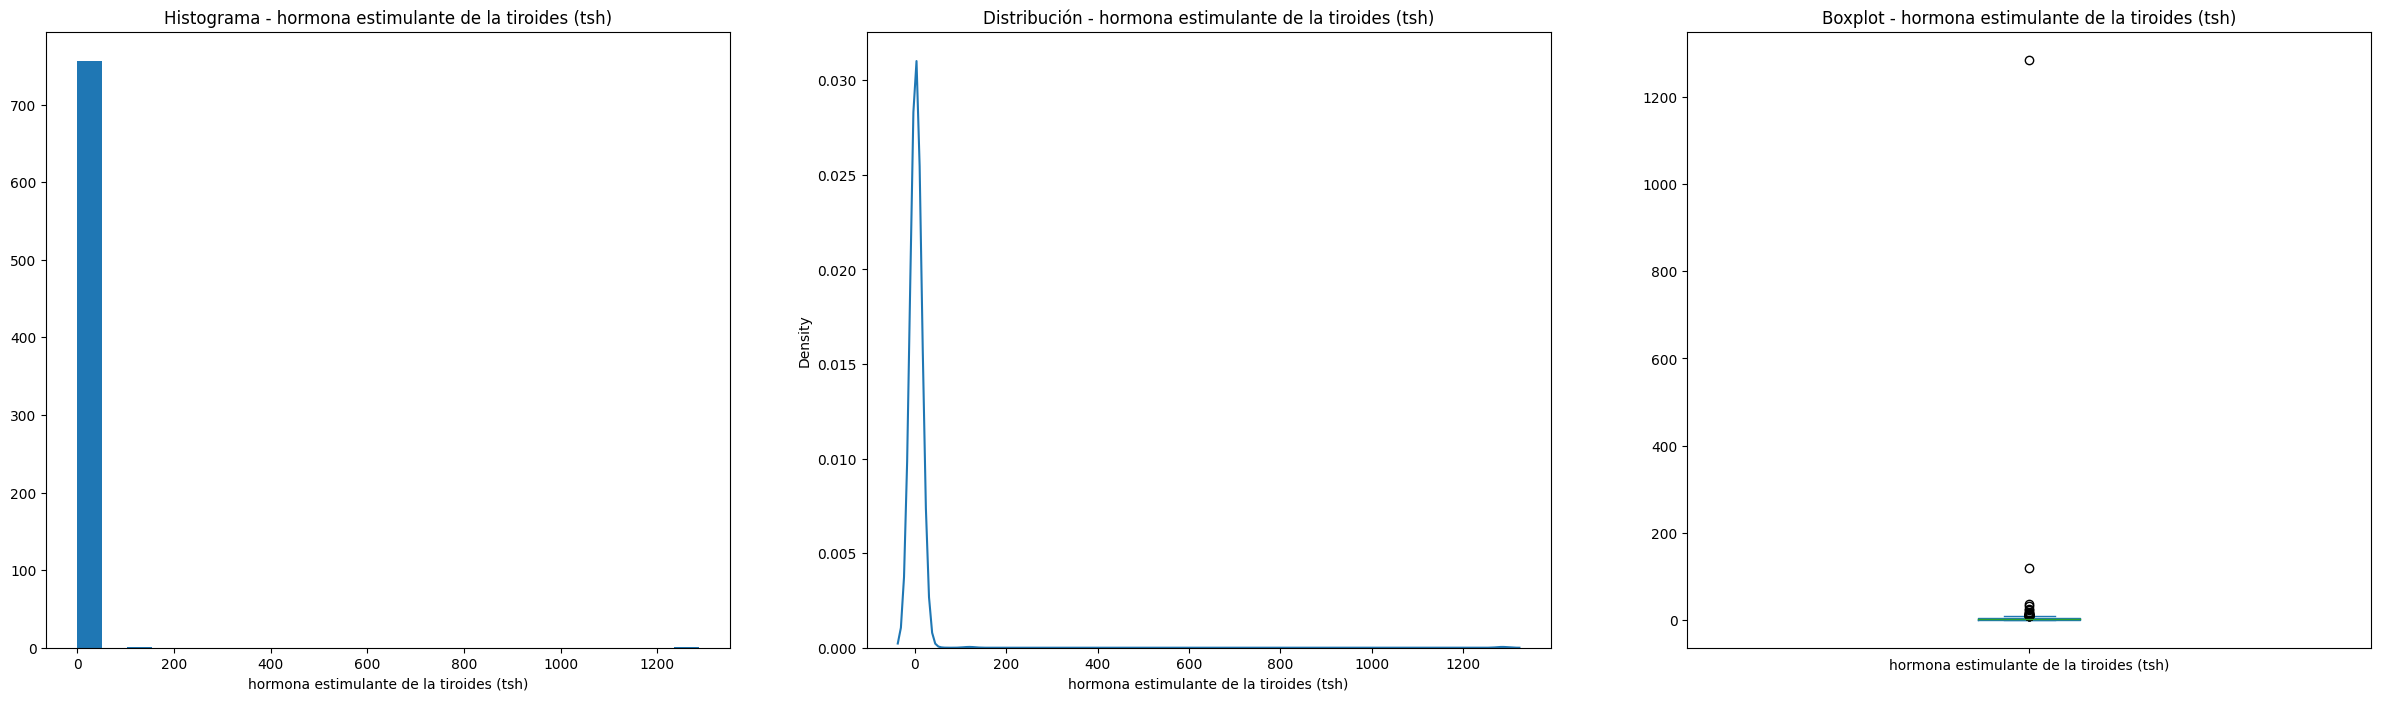

In [ ]:
#hormona estimulante de la tiroides (tsh)
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['hormona estimulante de la tiroides (tsh)'],25)
plt.xlabel('hormona estimulante de la tiroides (tsh)')
plt.title('Histograma - hormona estimulante de la tiroides (tsh)')

plt.subplot(1,3,2)
sns.kdeplot(x = "hormona estimulante de la tiroides (tsh)", data = dfnum)
plt.xlabel('hormona estimulante de la tiroides (tsh)')
plt.title('Distribución - hormona estimulante de la tiroides (tsh)')

plt.subplot(1,3,3)
dfnum['hormona estimulante de la tiroides (tsh)'].plot(kind='box')
plt.title('Boxplot - hormona estimulante de la tiroides (tsh)')
plt.show()

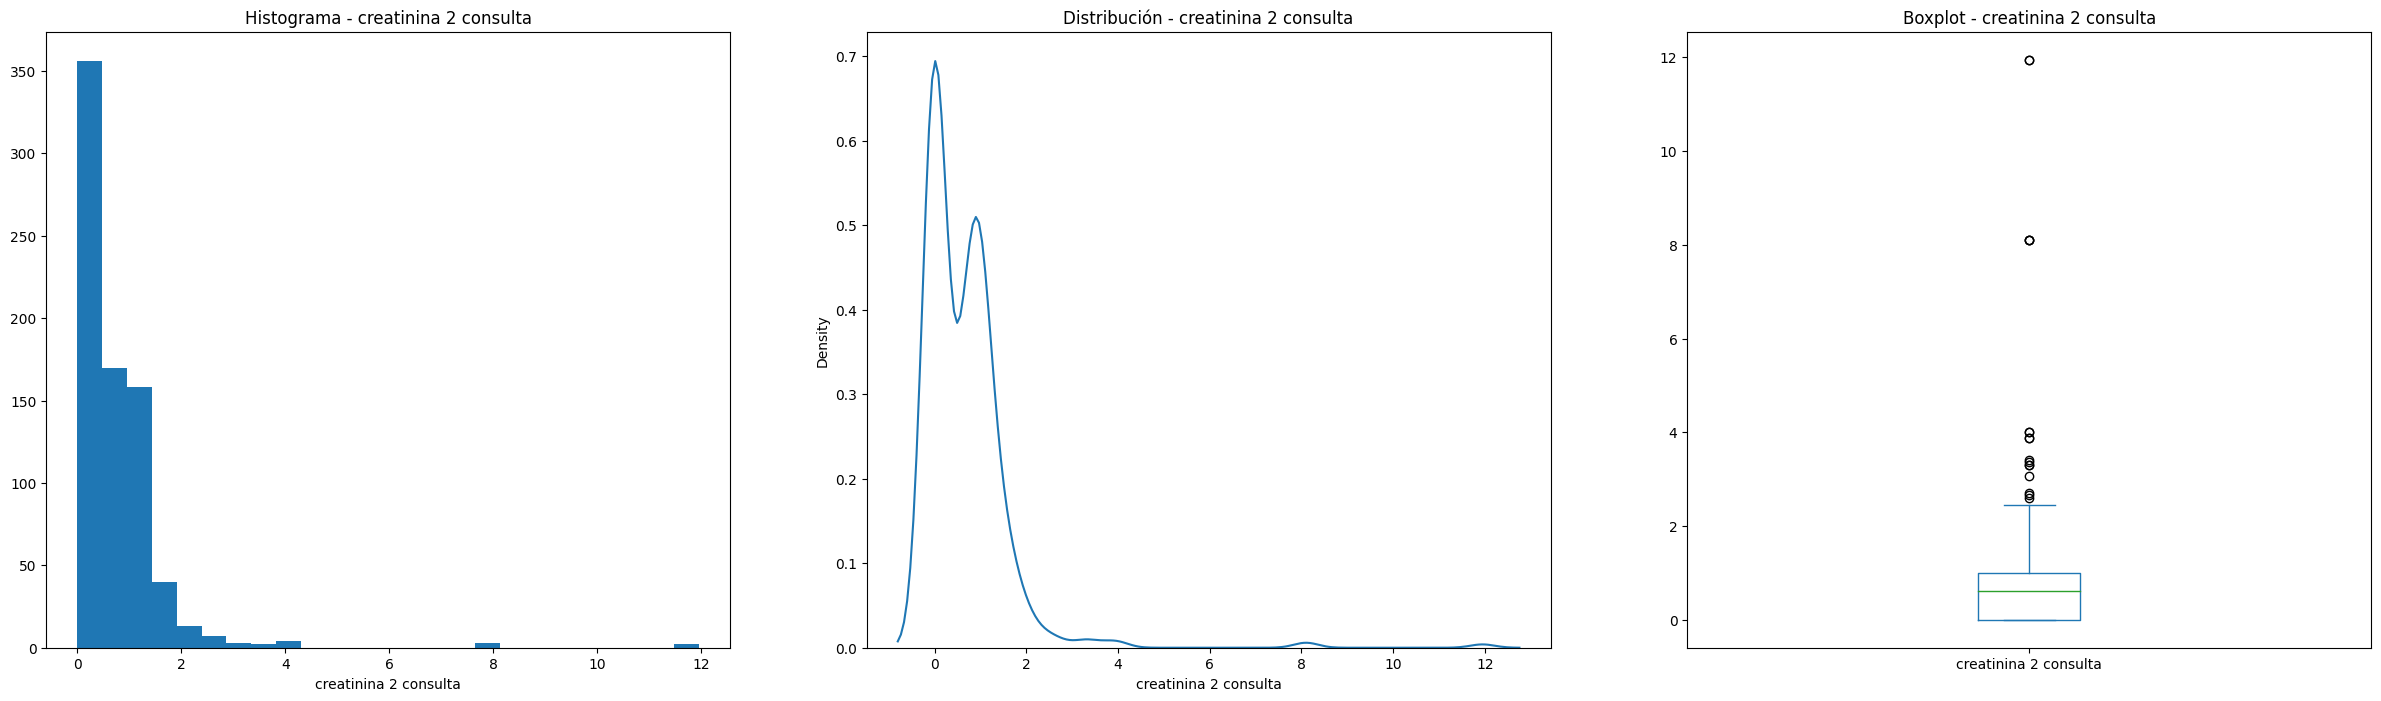

In [ ]:
#creatinina 2 consulta
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
plt.hist(dfnum['creatinina 2 consulta'],25)
plt.xlabel('creatinina 2 consulta')
plt.title('Histograma - creatinina 2 consulta')

plt.subplot(1,3,2)
sns.kdeplot(x = "creatinina 2 consulta", data = dfnum)
plt.xlabel('creatinina 2 consulta')
plt.title('Distribución - creatinina 2 consulta')

plt.subplot(1,3,3)
dfnum['creatinina 2 consulta'].plot(kind='box')
plt.title('Boxplot - creatinina 2 consulta')
plt.show()

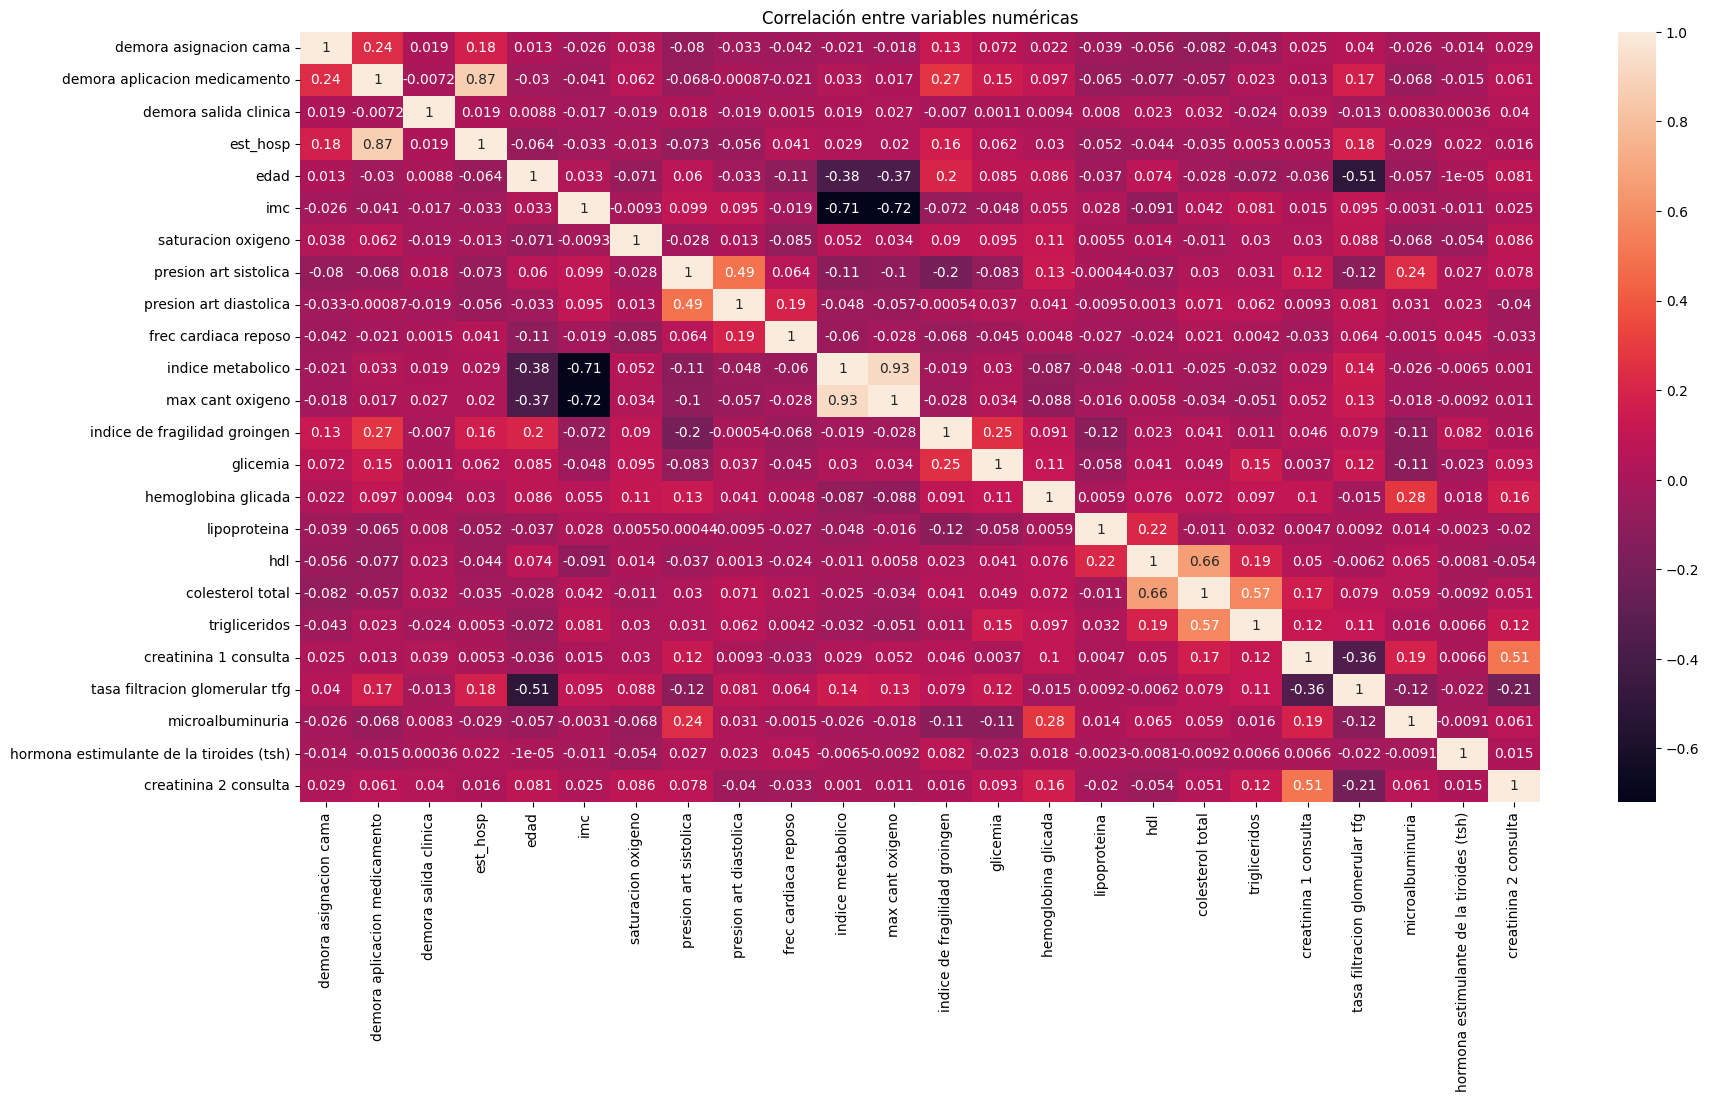

In [ ]:
# Análisis de colinealidad - Correlación entre variables numéricas
# Obtener matriz de correlación (coeficiente de correlación de pearson) para las variables numéricas
corr_df = dfnum.corr(method='pearson')

plt.figure(figsize=(20, 10))
sns.heatmap(corr_df, annot=True)
plt.title("Correlación entre variables numéricas")
plt.show()

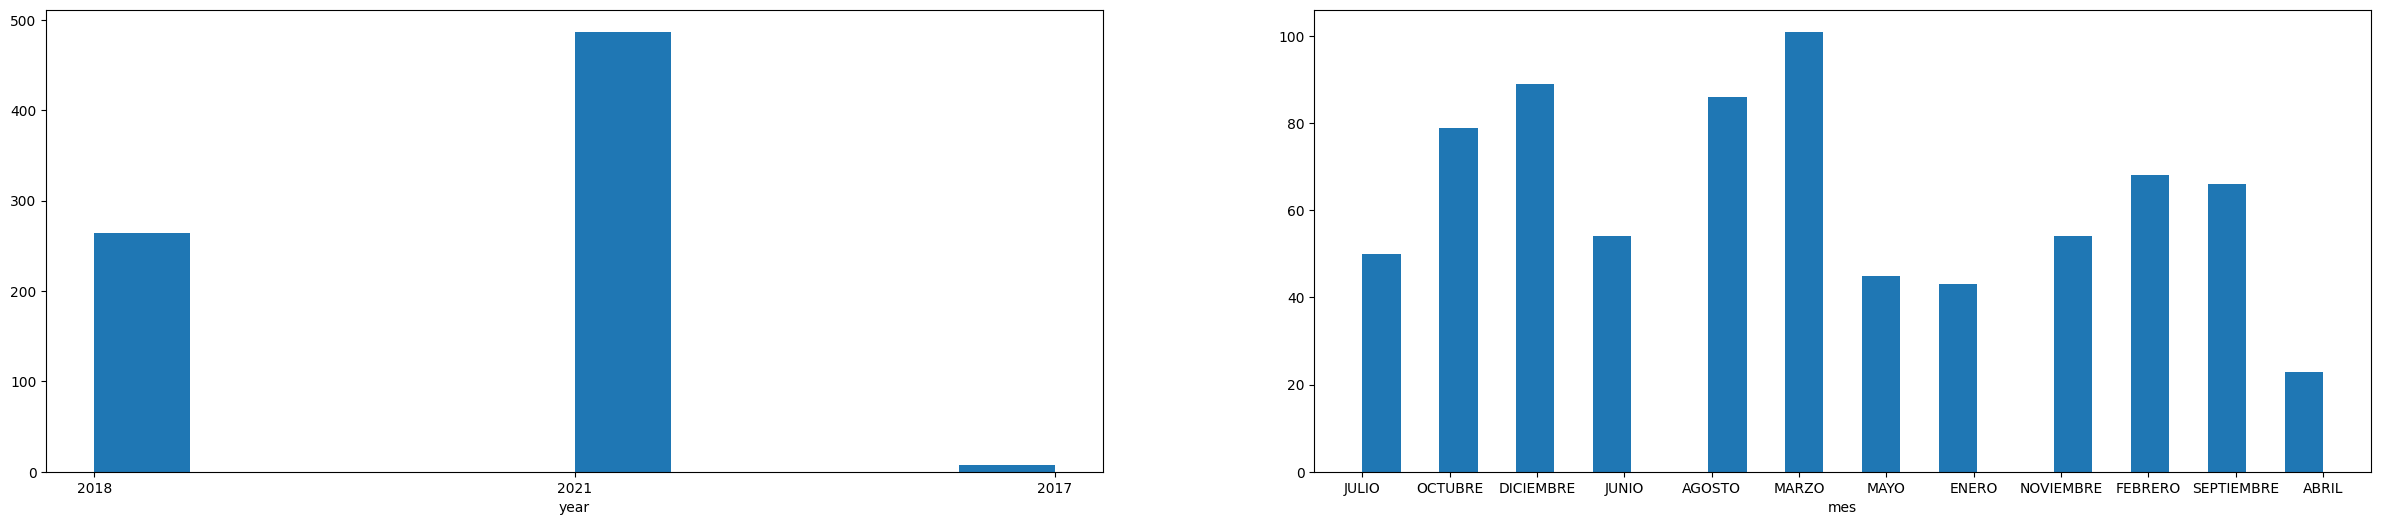

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['year'],10)
plt.xlabel('year')

plt.subplot(1,2,2)
plt.hist(dfcat['mes'],25)
plt.xlabel('mes')


plt.show()

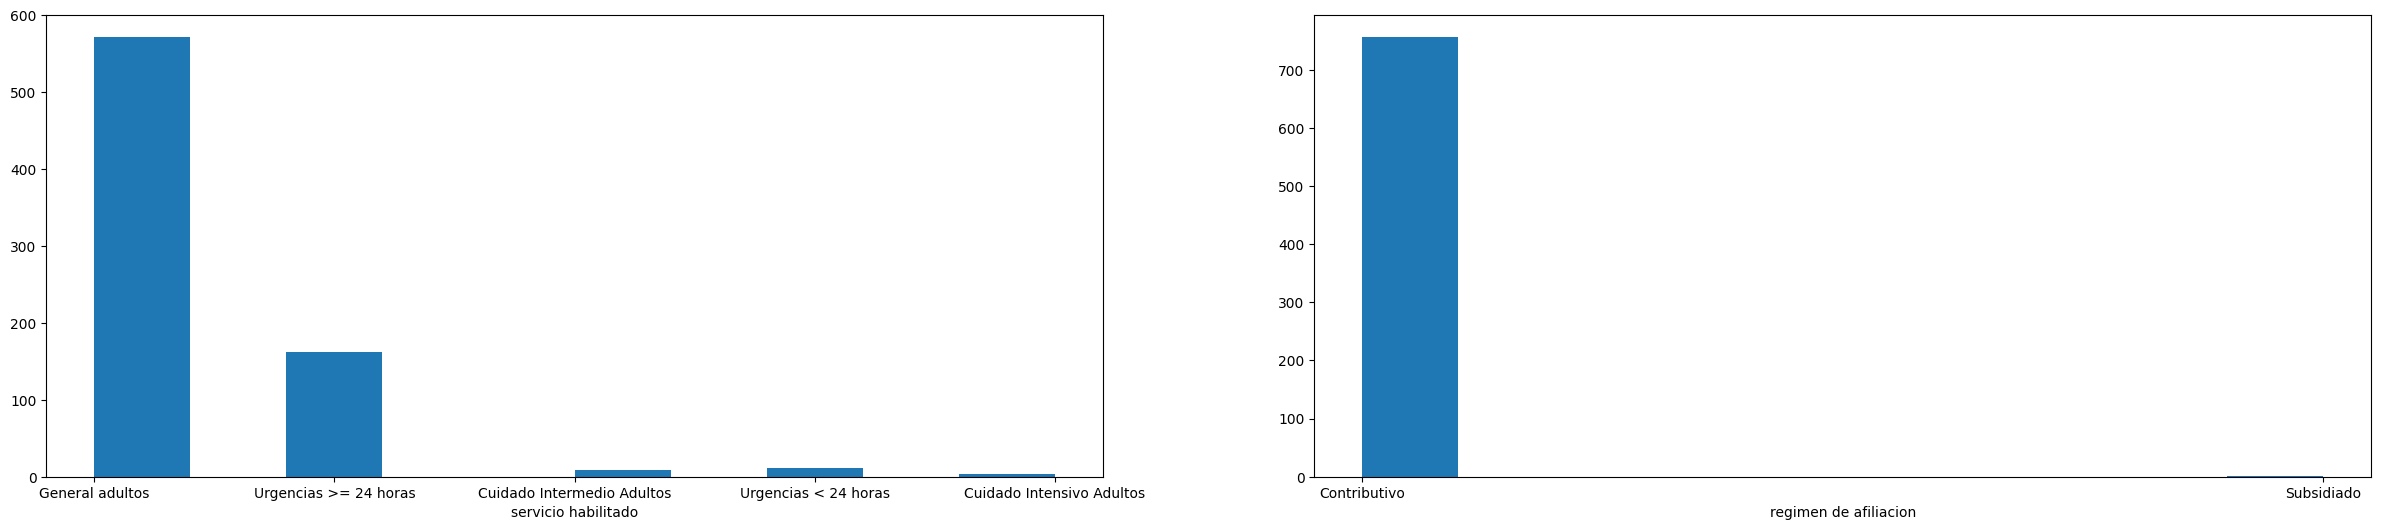

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['servicio habilitado'], 10)
plt.xlabel('servicio habilitado')

plt.subplot(1,2,2)
plt.hist(dfcat['regimen afiliacion'],10)
plt.xlabel('regimen de afiliacion')

plt.show()

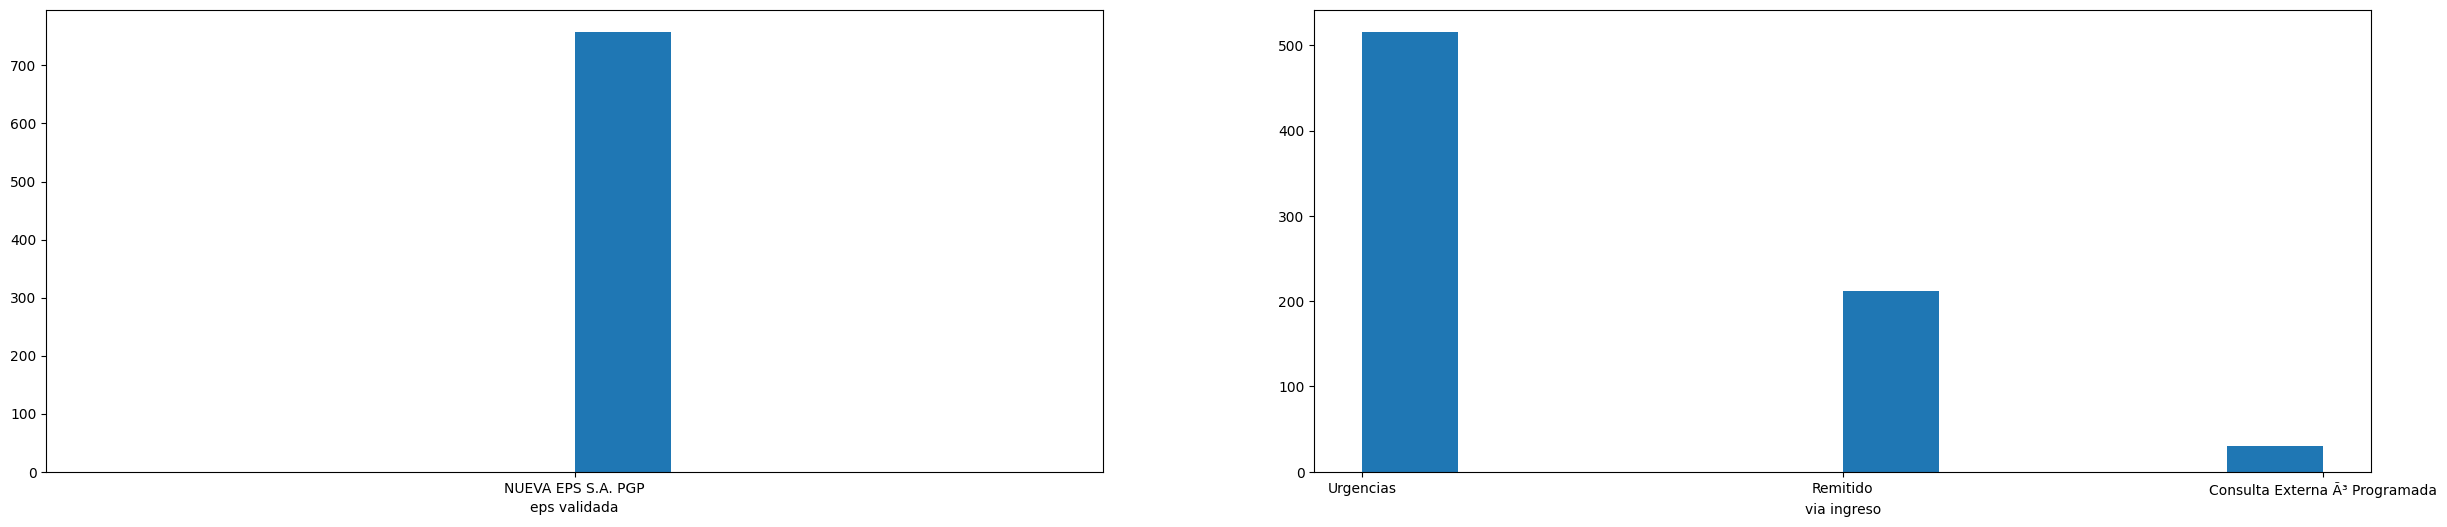

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['eps validada'], 10)
plt.xlabel('eps validada')

plt.subplot(1,2,2)
plt.hist(dfcat['via ingreso'],10)
plt.xlabel('via ingreso')

plt.show()

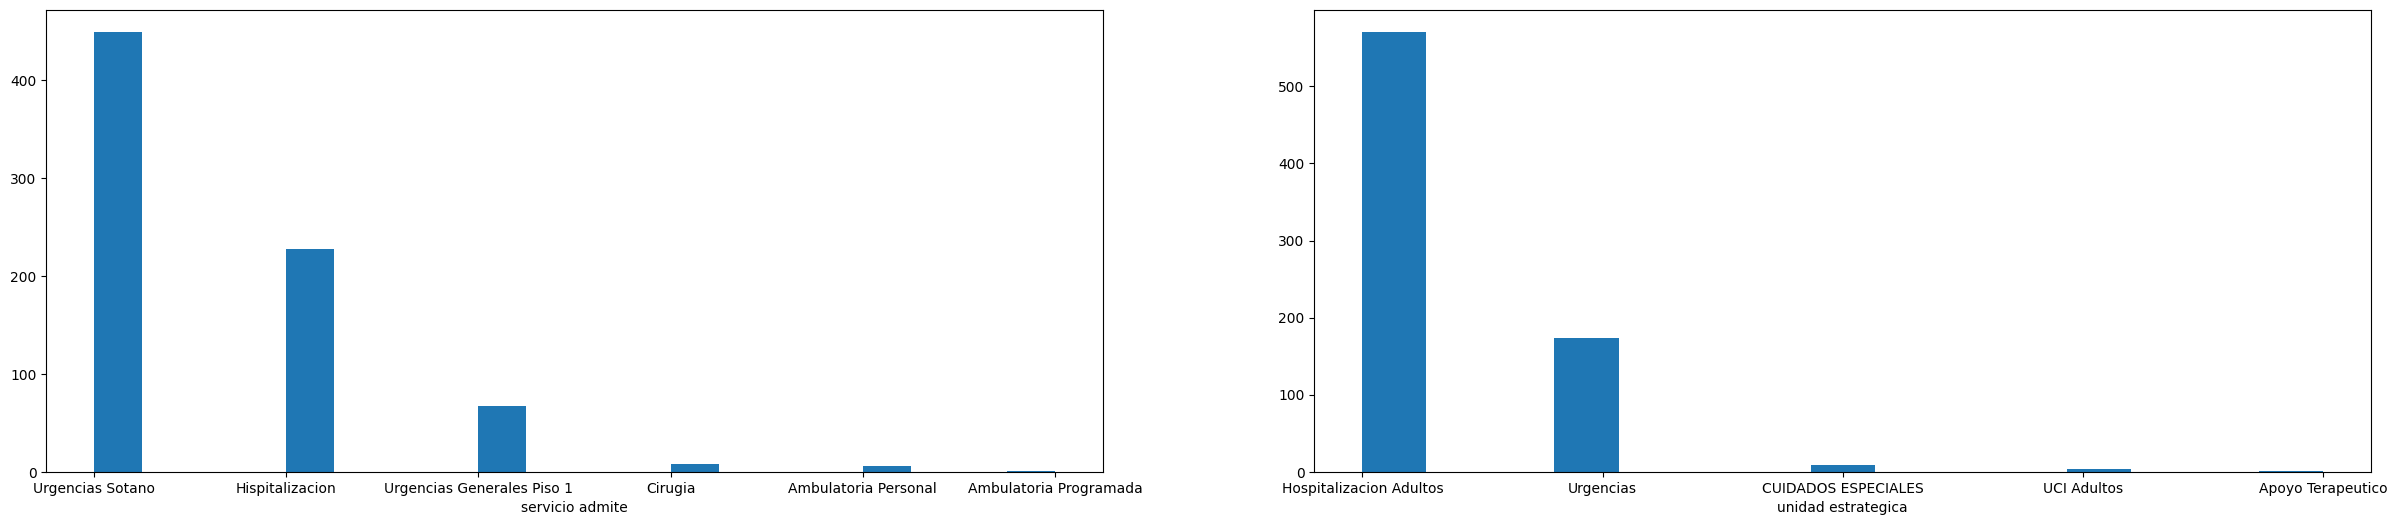

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['servicio admite'], 20)
plt.xlabel('servicio admite')

plt.subplot(1,2,2)
plt.hist(dfcat['unidad estrategica'],15)
plt.xlabel('unidad estrategica')

plt.show()

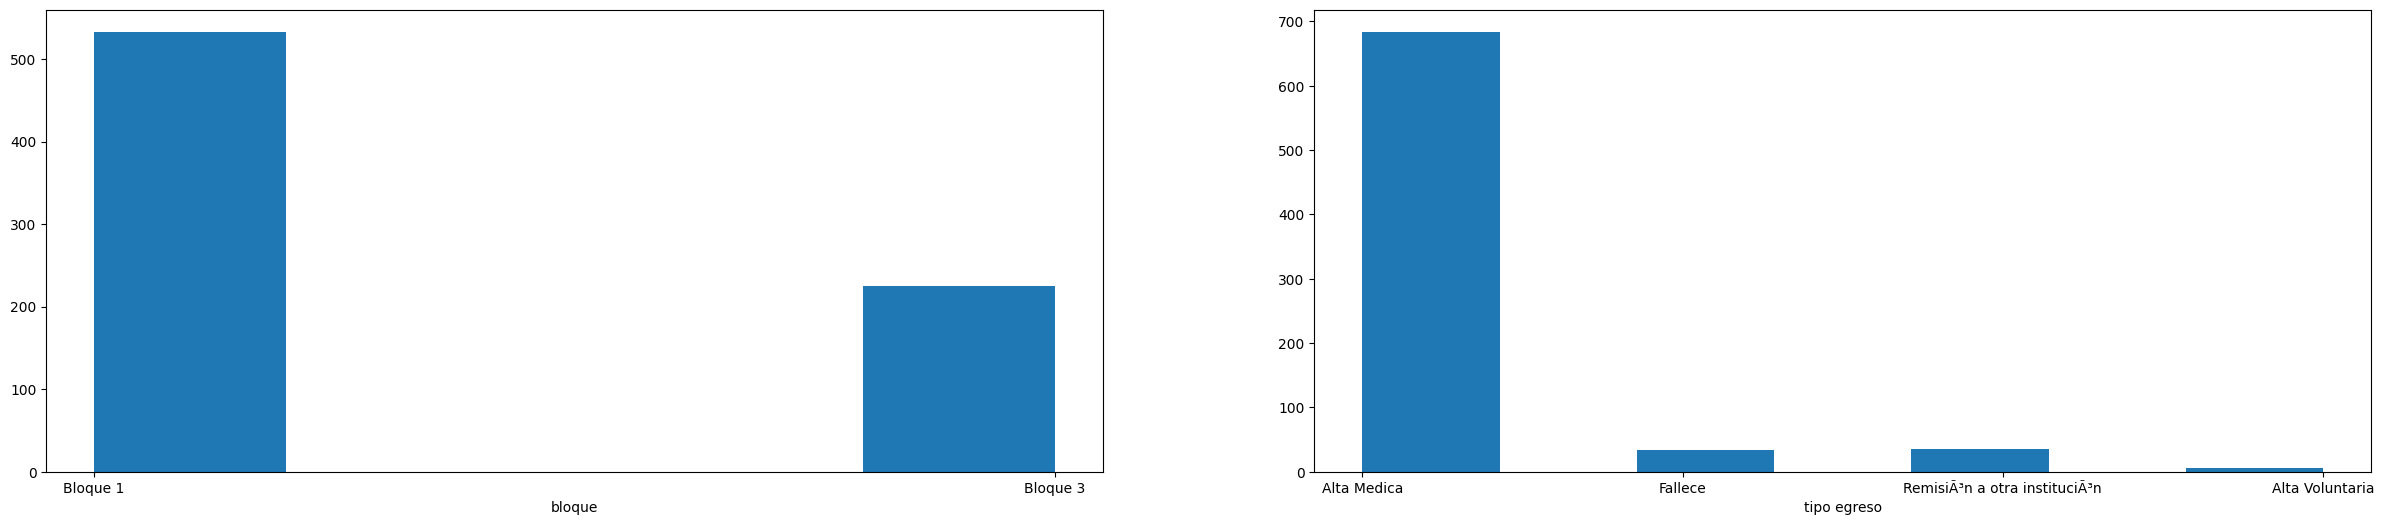

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['bloque'], 5)
plt.xlabel('bloque')

plt.subplot(1,2,2)
plt.hist(dfcat['tipo egreso'],7)
plt.xlabel('tipo egreso')


plt.show()

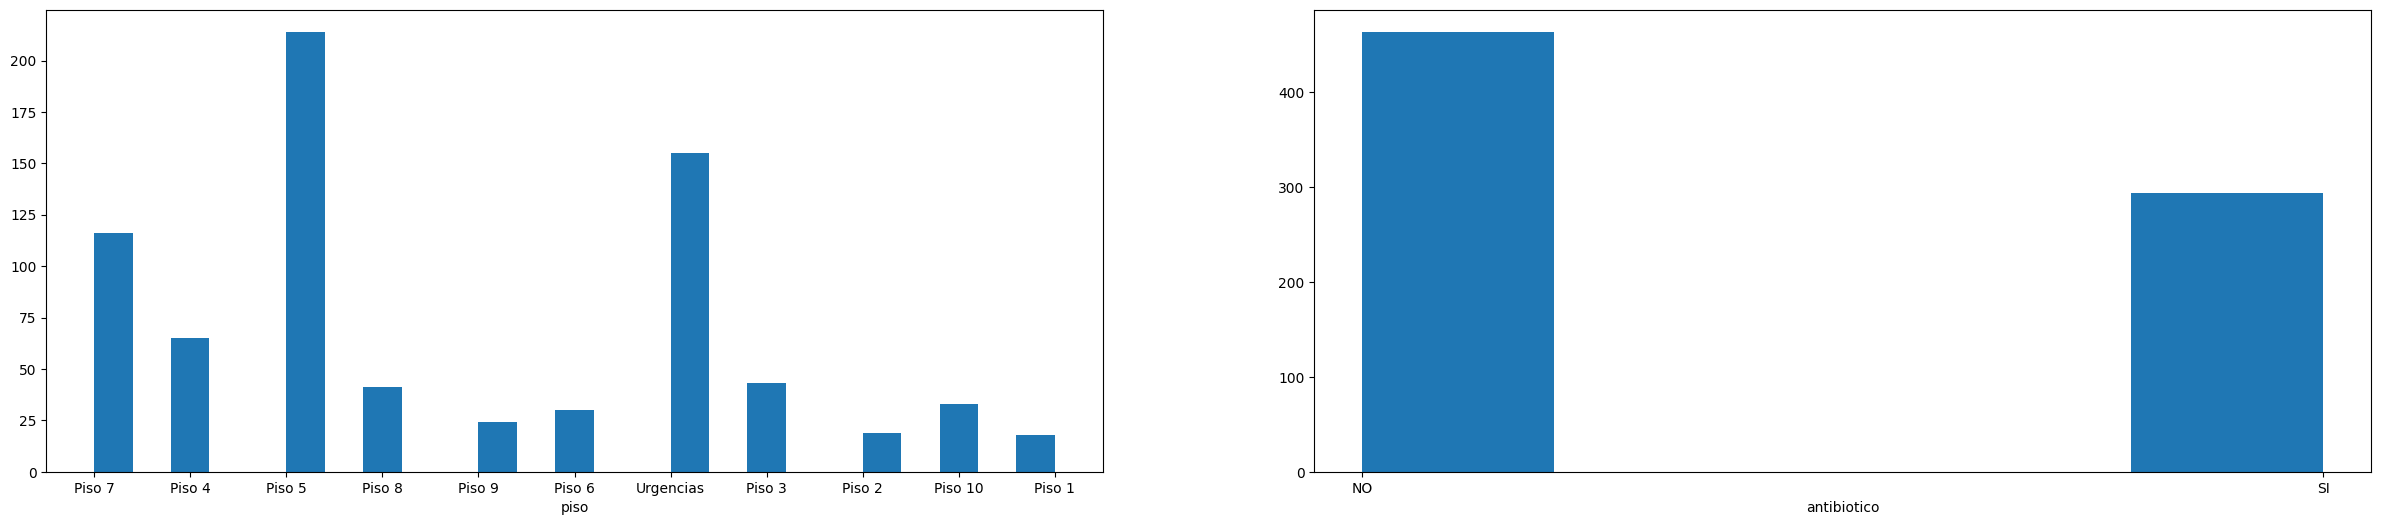

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['piso'], 25)
plt.xlabel('piso')

plt.subplot(1,2,2)
plt.hist(dfcat['antibiotico'], 5)
plt.xlabel('antibiotico')

plt.show()

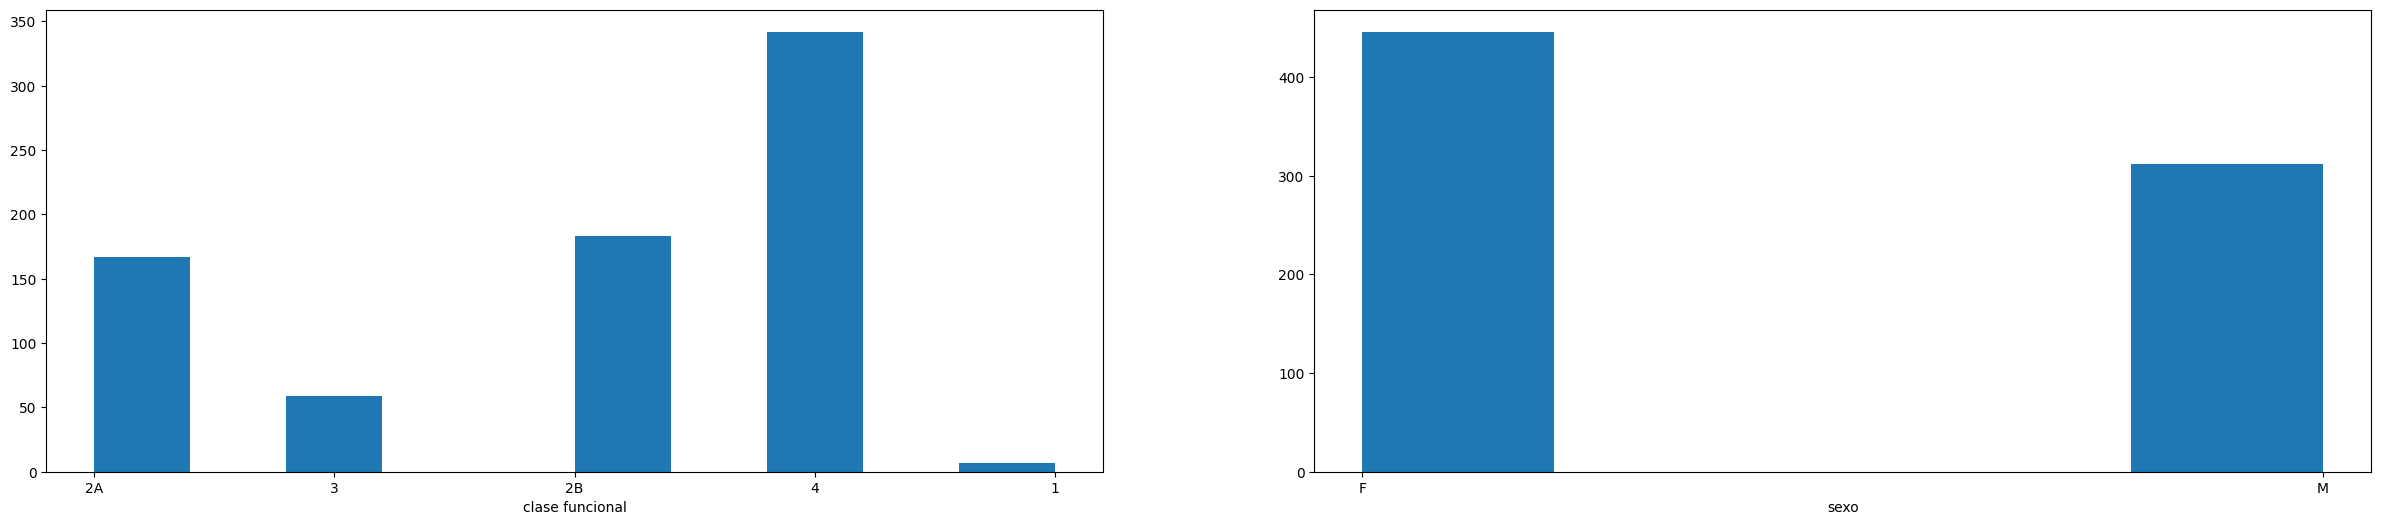

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(30, 6))

plt.subplot(1,2,1)
plt.hist(dfcat['clase_funcional'],10)
plt.xlabel('clase funcional')

plt.subplot(1,2,2)
plt.hist(dfcat['sexo'],5)
plt.xlabel('sexo')

plt.show()

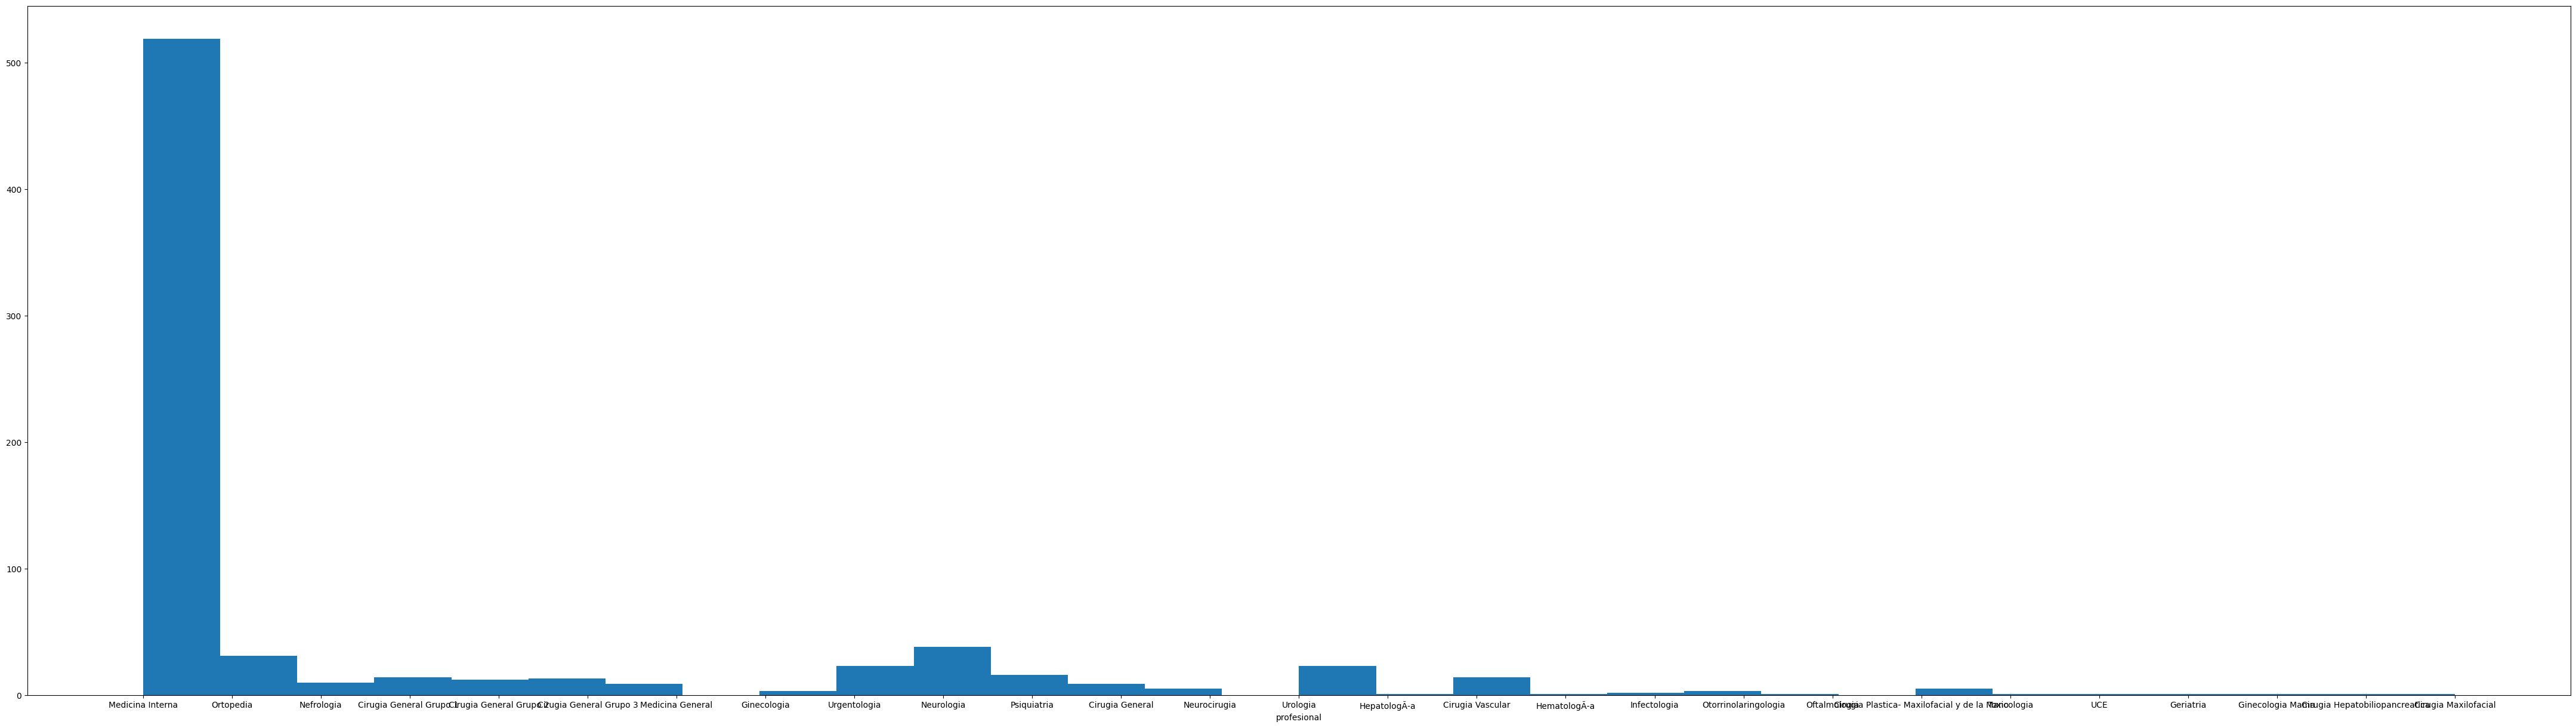

In [ ]:
#visualización de variables categoricas
plt.figure(figsize=(55, 15))
plt.subplot(1,1,1)
plt.hist(dfcat['profesional especialidad'], 30)
plt.xlabel('profesional')
plt.show()

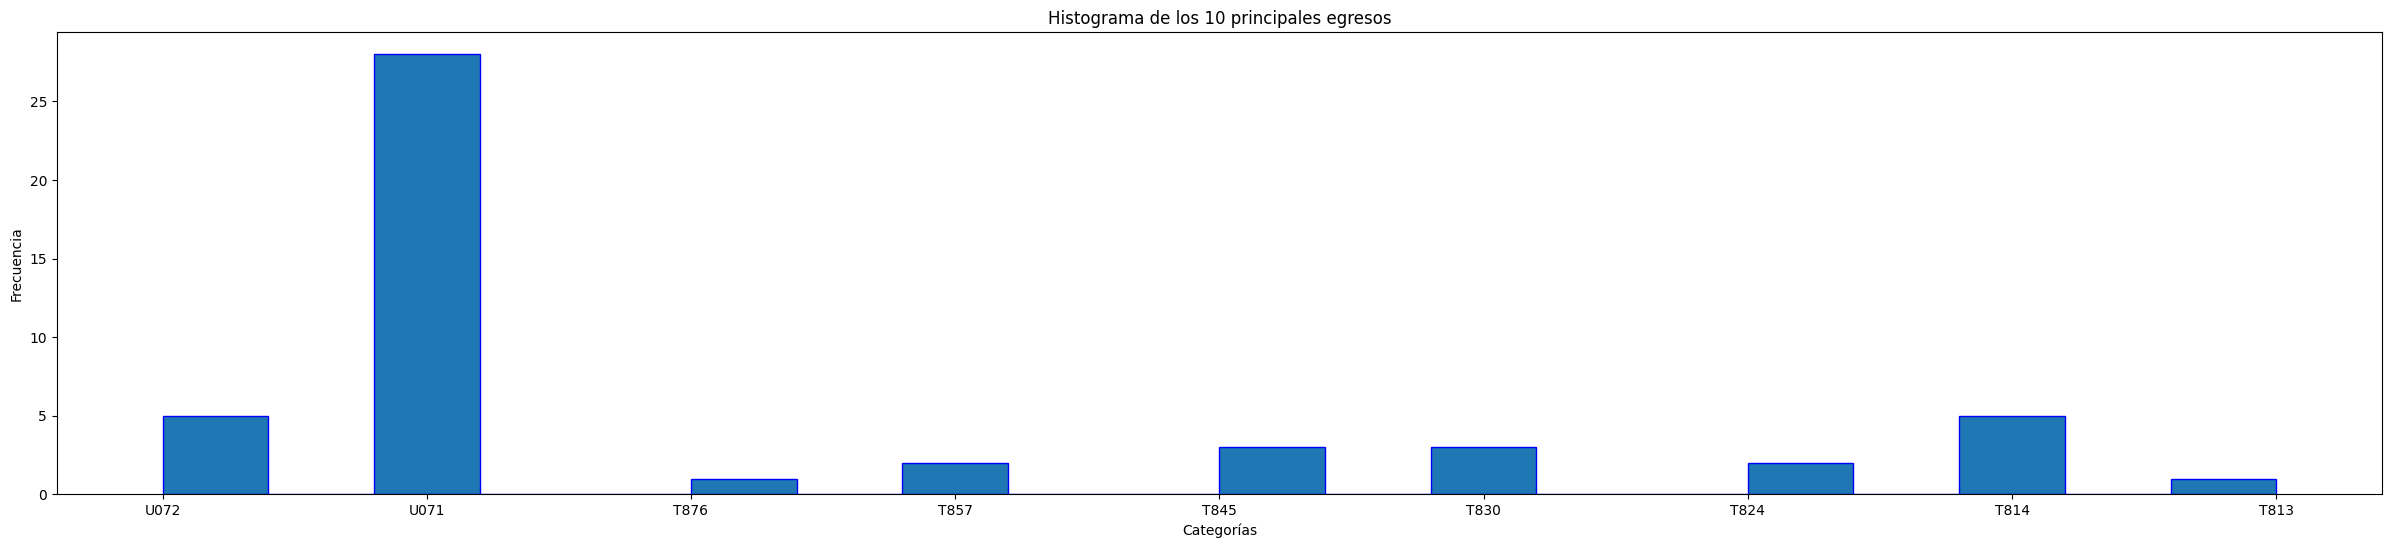

In [ ]:
#y selecciona las 9 primeras filas
plt.figure(figsize=(30, 6))

plt.subplot(1,1,1)
categorias_top_9 = dfcat.sort_values(by='dxprincipal egreso cod', ascending=False)['dxprincipal egreso cod'].head(50)

# Dibuja el histograma para las 9 primeras categorías más altas
plt.hist(categorias_top_9, bins=20, edgecolor='blue')  # Puedes ajustar el número de bins según tus preferencias

# Etiqueta del eje x
plt.xlabel('Categorías')

# Etiqueta del eje y
plt.ylabel('Frecuencia')

# Título del gráfico
plt.title('Histograma de los 10 principales egresos')

# Muestra el histograma
plt.show()

In [ ]:
# Eliminar variables que no presentan gran variabilidad o se encuentran correlacionadas
df.drop(['demora salida clinica', 'max cant oxigeno', 'indice metabolico', 'colesterol total', 'creatinina 1 consulta',
         'eps validada', 'bloque'], axis=1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 0 to 776
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      758 non-null    object 
 1   mes                                       758 non-null    object 
 2   servicio habilitado                       758 non-null    object 
 3   nrodoc                                    758 non-null    object 
 4   regimen afiliacion                        758 non-null    object 
 5   servicio admite                           758 non-null    object 
 6   via ingreso                               758 non-null    object 
 7   unidad estrategica                        758 non-null    object 
 8   piso                                      758 non-null    object 
 9   nro cama                                  758 non-null    object 
 10  tipo egreso                           

In [ ]:
# Se filtran los datos para predecir la estancia solo de aquellos que son atendidos por Medicina Interna
df = df.loc[df['profesional especialidad']=='Medicina Interna']
df.drop(['profesional especialidad'], axis=1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 776
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      519 non-null    object 
 1   mes                                       519 non-null    object 
 2   servicio habilitado                       519 non-null    object 
 3   nrodoc                                    519 non-null    object 
 4   regimen afiliacion                        519 non-null    object 
 5   servicio admite                           519 non-null    object 
 6   via ingreso                               519 non-null    object 
 7   unidad estrategica                        519 non-null    object 
 8   piso                                      519 non-null    object 
 9   nro cama                                  519 non-null    object 
 10  tipo egreso                           

In [ ]:
# Definición de función que utiliza RIC para la detección de valores atípicos
def outlier_IQR(df, column, thr):
    Q1 = np.quantile(df[column], 0.25) # first quartile
    Q3 = np.quantile(df[column], 0.75) # third quartile
    IQR = Q3 - Q1 # inter - quartile range
    threshold = thr * IQR # defining the threshold
    lower = Q1 - threshold
    upper = Q3 + threshold
    lower_bound = df[df[column] < lower]
    upper_bound = df[df[column] > upper]

    #Imprimir IQR, threshold, lower bound, upper bound and total number of outlier
    print('IQR is:', IQR)
    print('Threshold is:', threshold)
    print('Lower bound is:', lower)
    print('Upper bound is:', upper)
    print('total number of outliers are:', lower_bound.shape[0] + upper_bound.shape[0])
    return upper, lower

In [ ]:
#Obtener el IQR, el umbral, el límite inferior, el límite superior, el total de valores atípicos extremos
c = 8
print('---------------------Demora Cama----------------------------')
upper_1, lower_1 = outlier_IQR(df, 'demora asignacion cama', c)
print('---------------------Demora Medicamento----------------------------')
upper_2, lower_2 = outlier_IQR(df, 'demora aplicacion medicamento', c)
print('---------------------Edad----------------------------')
upper_3, lower_3 = outlier_IQR(df, 'edad', c)
print('---------------------IMC----------------------------')
upper_4, lower_4 = outlier_IQR(df, 'imc', c)
print('---------------------Saturación Oxigeno----------------------------')
upper_5, lower_5 = outlier_IQR(df, 'saturacion oxigeno', c)
print('---------------------Presión Sistólica----------------------------')
upper_6, lower_6 = outlier_IQR(df, 'presion art sistolica', c)
print('---------------------Presión Diastólica----------------------------')
upper_7, lower_7 = outlier_IQR(df, 'presion art diastolica', c)
print('---------------------Frecuencia Cardíaca----------------------------')
upper_9, lower_9 = outlier_IQR(df, 'frec cardiaca reposo', c)
print('---------------------Indice Groigen----------------------------')
upper_10, lower_10 = outlier_IQR(df, 'indice de fragilidad groingen', c)
print('---------------------Glicemia----------------------------')
upper_11, lower_11 = outlier_IQR(df, 'glicemia', c)
print('---------------------Hemoglobina----------------------------')
upper_12, lower_12 = outlier_IQR(df, 'hemoglobina glicada', c)
print('---------------------Lipoproteina----------------------------')
upper_13, lower_13 = outlier_IQR(df, 'lipoproteina', c)
print('---------------------HDL----------------------------')
upper_14, lower_14 = outlier_IQR(df, 'hdl', c)
print('---------------------Trigliceridos----------------------------')
upper_15, lower_15 = outlier_IQR(df, 'trigliceridos', c)
print('---------------------Tasa Glomerular----------------------------')
upper_16, lower_16 = outlier_IQR(df, 'tasa filtracion glomerular tfg', c)
print('---------------------Microalbuminuria----------------------------')
upper_17, lower_17 = outlier_IQR(df, 'microalbuminuria', c)
print('---------------------TSH----------------------------')
upper_18, lower_18 = outlier_IQR(df, 'hormona estimulante de la tiroides (tsh)', c)
print('---------------------Creatinina----------------------------')
upper_19, lower_19 = outlier_IQR(df, 'creatinina 2 consulta', c)

---------------------Demora Cama----------------------------
IQR is: 0.0773611111111111
Threshold is: 0.6188888888888888
Lower bound is: -0.6188888888888888
Upper bound is: 0.6962499999999999
total number of outliers are: 26
---------------------Demora Medicamento----------------------------
IQR is: 2.9672222222222224
Threshold is: 23.73777777777778
Lower bound is: -23.73777777777778
Upper bound is: 26.705000000000002
total number of outliers are: 0
---------------------Edad----------------------------
IQR is: 15.0
Threshold is: 120.0
Lower bound is: -52.0
Upper bound is: 203.0
total number of outliers are: 0
---------------------IMC----------------------------
IQR is: 7.364999999999998
Threshold is: 58.91999999999999
Lower bound is: -35.17499999999998
Upper bound is: 90.02999999999999
total number of outliers are: 1
---------------------Saturación Oxigeno----------------------------
IQR is: 4.0
Threshold is: 32.0
Lower bound is: 60.0
Upper bound is: 128.0
total number of outliers are:

In [ ]:
# Imputación de valores atípicos extremos
from scipy import stats
#Impute Outliers
df1 = df.copy()

# Filtre los outliers y reemplace valores por el valor máximo de los registros sin incluir el valor extremo
print('Antes de imputación de Outliers:', df.shape)

df1['demora asignacion cama'] = np.where(df1['demora asignacion cama'] > upper_1, stats.scoreatpercentile(df1['demora asignacion cama'],100 - 26/519*100),
               np.where(df1['demora asignacion cama'] < lower_1, stats.scoreatpercentile(df1['demora asignacion cama'],26/519*100), df1['demora asignacion cama']))

df1['imc'] = np.where(df1['imc'] > upper_4, stats.scoreatpercentile(df1['imc'],100 - 1/519*100),
               np.where(df1['imc'] < lower_4, stats.scoreatpercentile(df1['imc'], 1/519*100), df1['imc']))

df1['saturacion oxigeno'] = np.where(df1['saturacion oxigeno'] > upper_5, stats.scoreatpercentile(df1['saturacion oxigeno'],100 - 1/519*100),
               np.where(df1['saturacion oxigeno'] < lower_5, stats.scoreatpercentile(df1['saturacion oxigeno'], 1/519*100), df1['saturacion oxigeno']))

df1['lipoproteina'] = np.where(df1['lipoproteina'] > upper_13, stats.scoreatpercentile(df1['lipoproteina'],100 - 1/519*100),
               np.where(df1['lipoproteina'] < lower_13, stats.scoreatpercentile(df1['lipoproteina'],1/519*100), df1['lipoproteina']))

df1['microalbuminuria'] = np.where(df1['microalbuminuria'] > upper_17, stats.scoreatpercentile(df1['microalbuminuria'],100 - 41/519*100),
               np.where(df1['microalbuminuria'] < lower_17, stats.scoreatpercentile(df1['microalbuminuria'], 41/519*100), df1['microalbuminuria']))

df1['hormona estimulante de la tiroides (tsh)'] = np.where(df1['hormona estimulante de la tiroides (tsh)'] > upper_18, stats.scoreatpercentile(df1['hormona estimulante de la tiroides (tsh)'],100 - 4/519*100),
               np.where(df1['hormona estimulante de la tiroides (tsh)'] < lower_18 ,stats.scoreatpercentile(df1['hormona estimulante de la tiroides (tsh)'],4/519*100), df1['hormona estimulante de la tiroides (tsh)']))

print('Después de imputación de Outliers:', df1.shape)

Antes de imputación de Outliers: (519, 34)
Después de imputación de Outliers: (519, 34)


In [ ]:
# Separación de variables numéricas y categóricas
df1num = df1.select_dtypes(include=['float64','int64'])
df1cat = df1.select_dtypes(include=['object'])

In [ ]:
df1num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 776
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   demora asignacion cama                    519 non-null    float64
 1   demora aplicacion medicamento             519 non-null    float64
 2   est_hosp                                  519 non-null    float64
 3   edad                                      519 non-null    int64  
 4   imc                                       519 non-null    float64
 5   saturacion oxigeno                        519 non-null    float64
 6   presion art sistolica                     519 non-null    int64  
 7   presion art diastolica                    519 non-null    int64  
 8   frec cardiaca reposo                      519 non-null    int64  
 9   indice de fragilidad groingen             519 non-null    float64
 10  glicemia                              

In [ ]:
df1cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 776
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    519 non-null    object
 1   mes                     519 non-null    object
 2   servicio habilitado     519 non-null    object
 3   nrodoc                  519 non-null    object
 4   regimen afiliacion      519 non-null    object
 5   servicio admite         519 non-null    object
 6   via ingreso             519 non-null    object
 7   unidad estrategica      519 non-null    object
 8   piso                    519 non-null    object
 9   nro cama                519 non-null    object
 10  tipo egreso             519 non-null    object
 11  antibiotico             519 non-null    object
 12  dxprincipal egreso cod  519 non-null    object
 13  sexo                    519 non-null    object
 14  clase_funcional         519 non-null    object
dtypes: obj

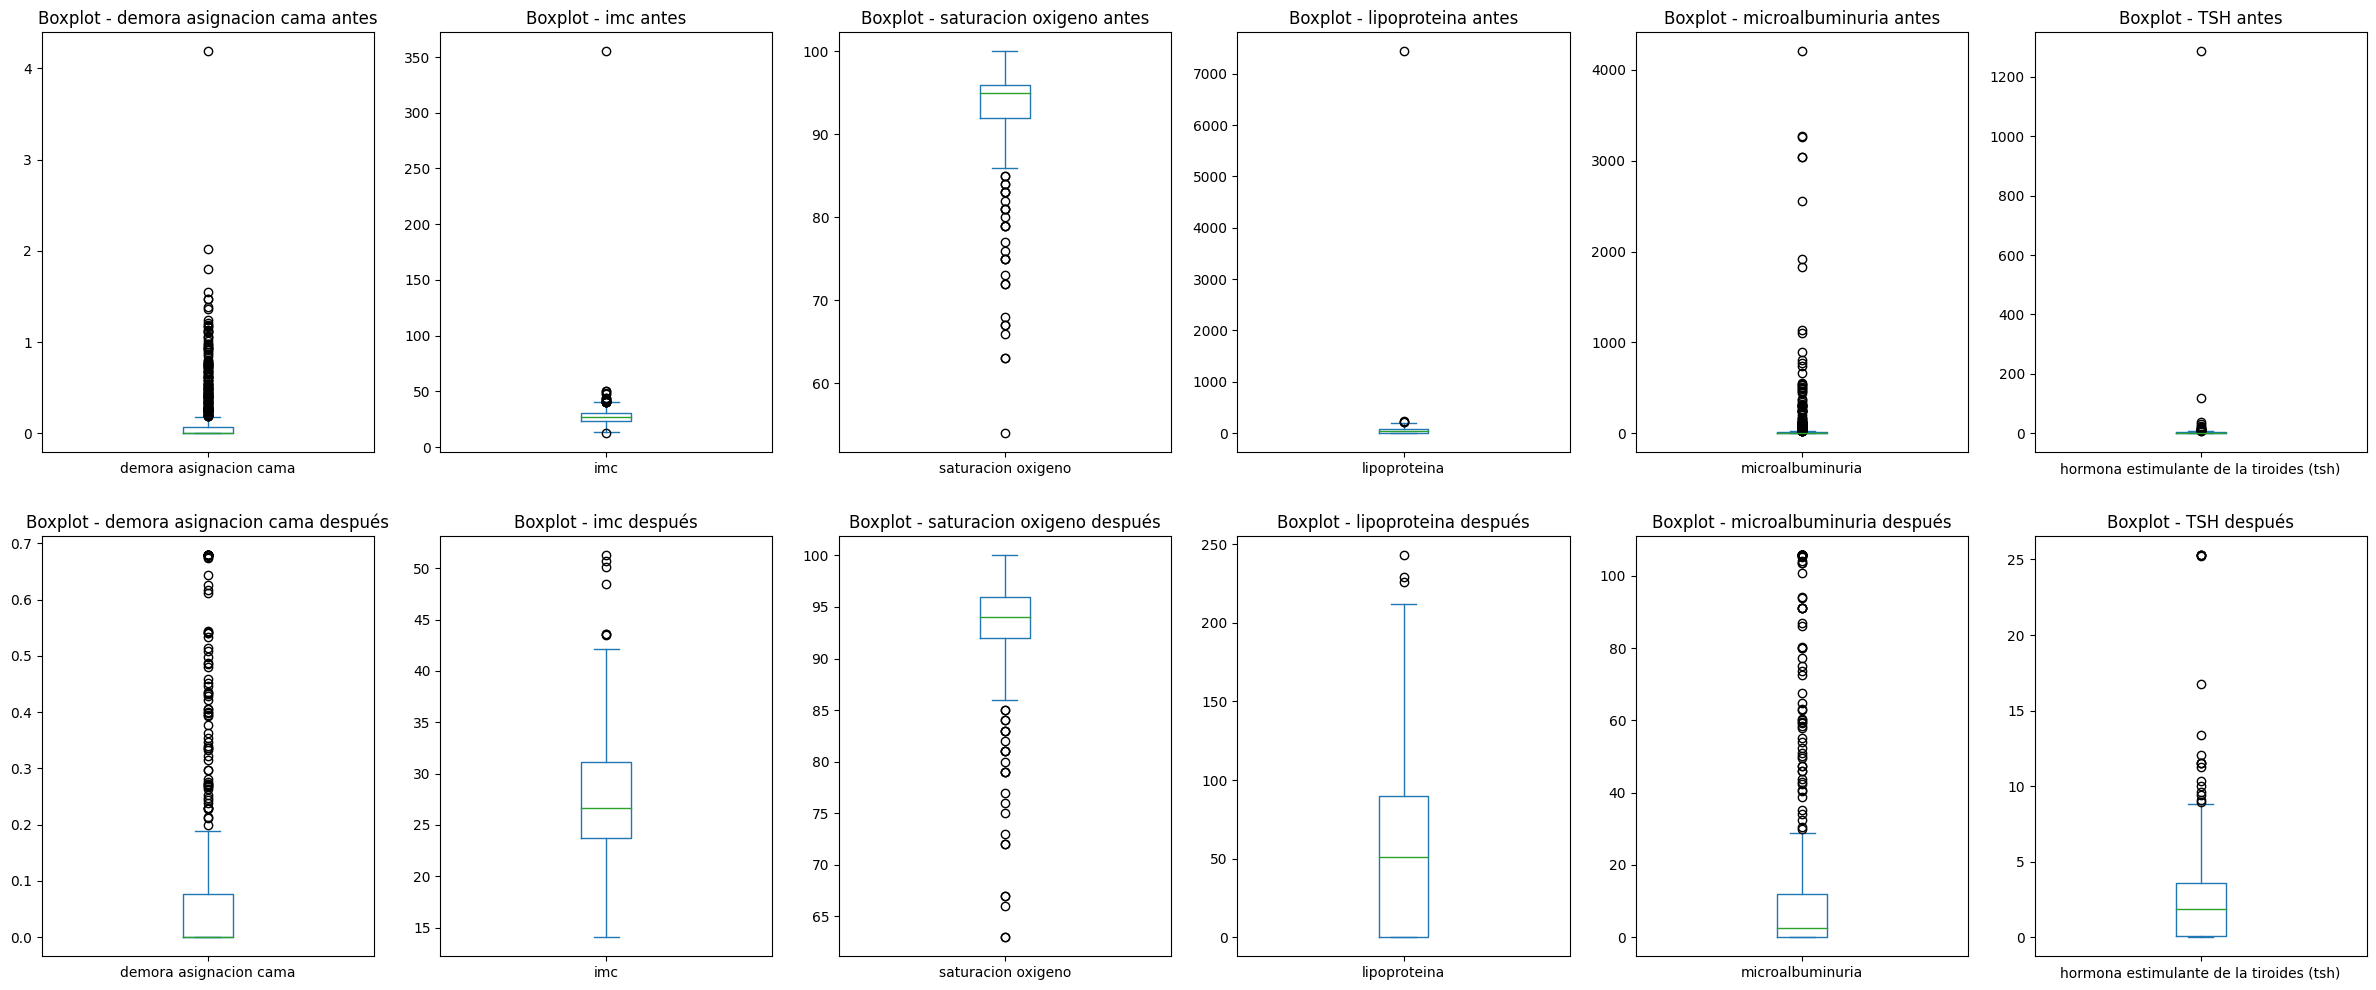

In [ ]:
# Boxplots
plt.figure(figsize=(30, 12))

plt.subplot(2,6,1)
dfnum['demora asignacion cama'].plot(kind='box')
plt.title('Boxplot - demora asignacion cama antes')

plt.subplot(2,6,2)
dfnum['imc'].plot(kind='box')
plt.title('Boxplot - imc antes')

plt.subplot(2,6,3)
dfnum['saturacion oxigeno'].plot(kind='box')
plt.title('Boxplot - saturacion oxigeno antes')

plt.subplot(2,6,4)
dfnum['lipoproteina'].plot(kind='box')
plt.title('Boxplot - lipoproteina antes')

plt.subplot(2,6,5)
dfnum['microalbuminuria'].plot(kind='box')
plt.title('Boxplot - microalbuminuria antes')

plt.subplot(2,6,6)
dfnum['hormona estimulante de la tiroides (tsh)'].plot(kind='box')
plt.title('Boxplot - TSH antes')

plt.subplot(2,6,7)
df1num['demora asignacion cama'].plot(kind='box')
plt.title('Boxplot - demora asignacion cama después')

plt.subplot(2,6,8)
df1num['imc'].plot(kind='box')
plt.title('Boxplot - imc después')

plt.subplot(2,6,9)
df1num['saturacion oxigeno'].plot(kind='box')
plt.title('Boxplot - saturacion oxigeno después')

plt.subplot(2,6,10)
df1num['lipoproteina'].plot(kind='box')
plt.title('Boxplot - lipoproteina después')

plt.subplot(2,6,11)
df1num['microalbuminuria'].plot(kind='box')
plt.title('Boxplot - microalbuminuria después')

plt.subplot(2,6,12)
df1num['hormona estimulante de la tiroides (tsh)'].plot(kind='box')
plt.title('Boxplot - TSH después')
plt.show()

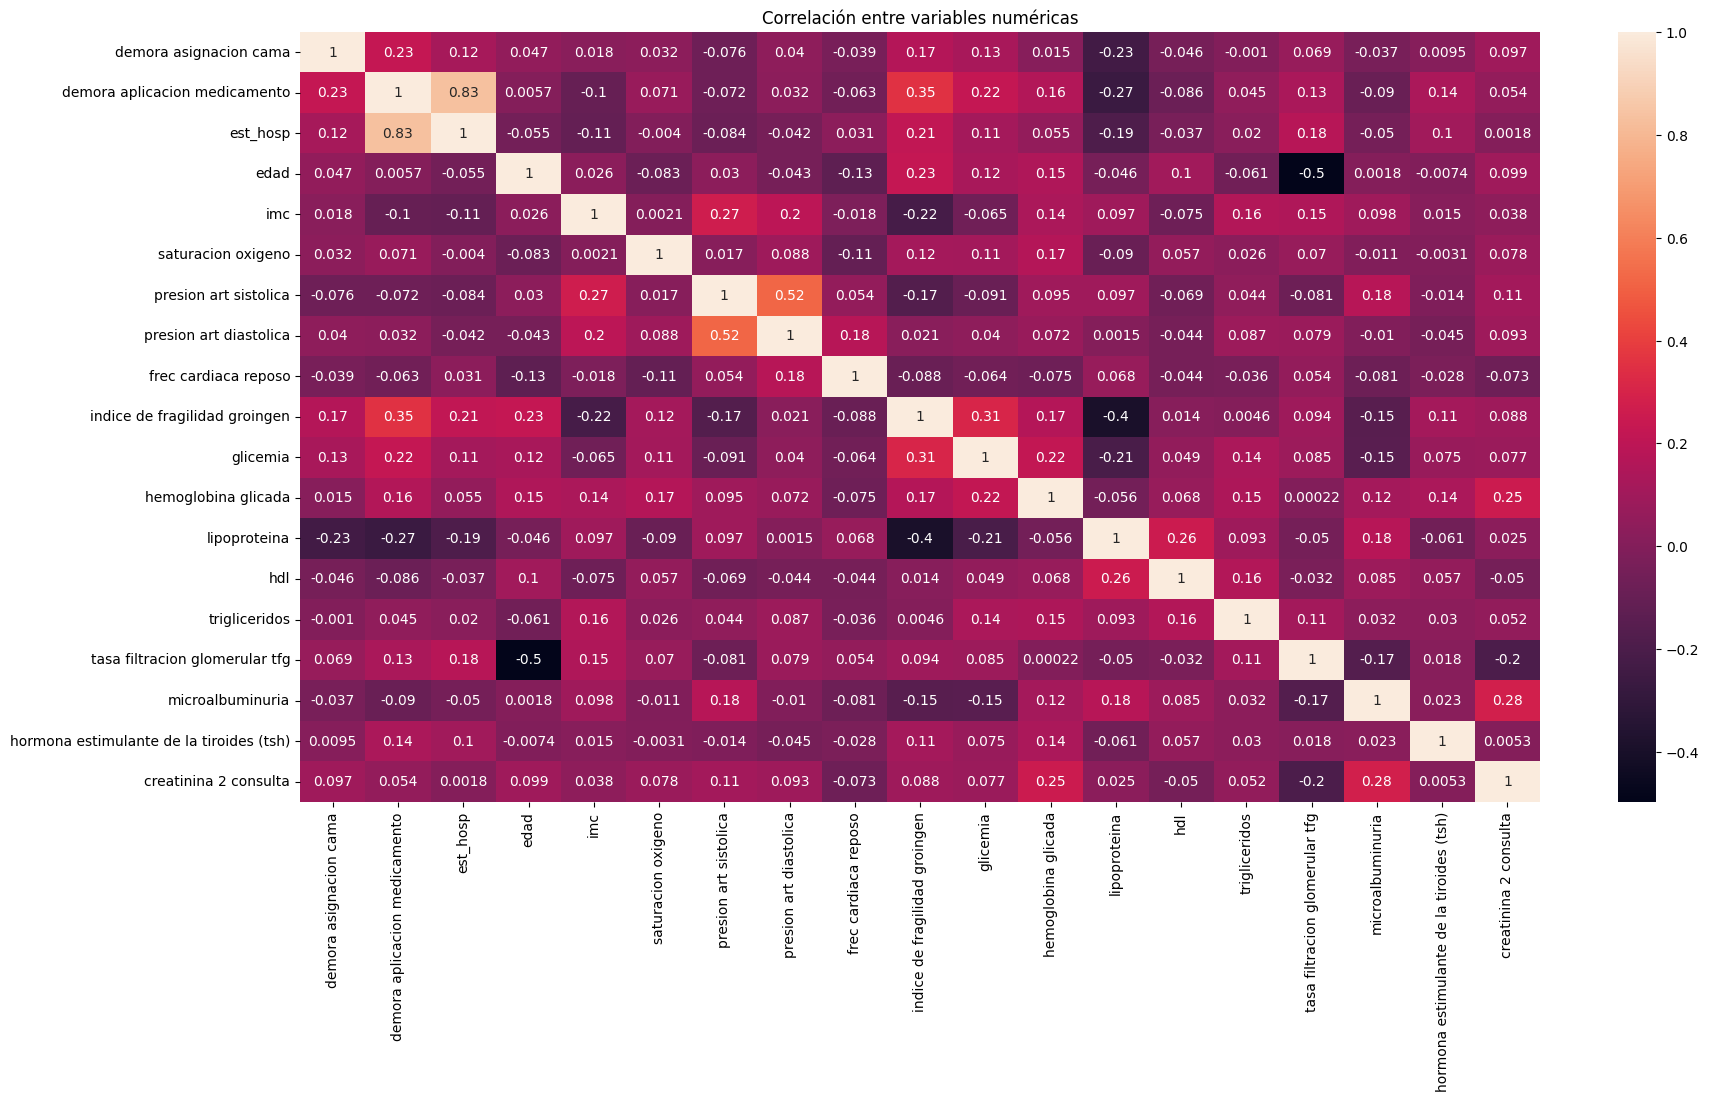

In [ ]:
# Análisis de colinealidad - Correlación entre variables numéricas
# Obtener matriz de correlación (coeficiente de correlación de pearson) para las variables numéricas
corr_df = df1num.corr(method='pearson')

plt.figure(figsize=(20, 10))
sns.heatmap(corr_df, annot=True)
plt.title("Correlación entre variables numéricas")
plt.show()

## **Selección de variables y algoritmos**

In [ ]:
est_hosp = df1["est_hosp"]

In [ ]:
# Copiar el datframe anterior
df2 = df1.copy()

# Eliminar la variable de estancia hospitalaria, para volver las variables dummies
df2.drop("est_hosp", axis = 1, inplace = True)

# Eliminar variable que son de referenciación como nrodoc, year y mes las cuales no aportan en el modelo
df2.drop("year", axis = 1, inplace = True)
df2.drop("mes", axis = 1, inplace = True)
df2.drop("nrodoc", axis = 1, inplace = True)

# Eliminar variable de diagnóstico y nro cama, ya que tienen muchas categorias y se volvera díficil de procesar al ser variable dummies
df2.drop("dxprincipal egreso cod", axis=1, inplace =True)
df2.drop("nro cama", axis=1, inplace =True)

# Se convierten las variables a tipo dummies
df2 = pd.get_dummies(df2)
df2.head(3)

,demora asignacion cama,demora aplicacion medicamento,edad,imc,saturacion oxigeno,presion art sistolica,presion art diastolica,frec cardiaca reposo,indice de fragilidad groingen,glicemia,...,tipo egreso_RemisiÃ³n a otra instituciÃ³n,antibiotico_NO,antibiotico_SI,sexo_F,sexo_M,clase_funcional_1,clase_funcional_2A,clase_funcional_2B,clase_funcional_3,clase_funcional_4
0,0.0,-0.0,79,25.78,63.0,110,63,101,3.0,74.0,...,0,1,0,1,0,0,1,0,0,0
1,0.0,-0.0,79,24.89,67.0,134,52,80,2.0,74.0,...,0,1,0,1,0,0,1,0,0,0
2,0.0,-0.0,73,24.44,86.0,140,80,98,12.0,0.0,...,0,1,0,1,0,0,1,0,0,0


In [ ]:
# Se vuelve a poner la estancia hospitalaria
df_real =pd.concat([est_hosp, df2], axis=1)
df_real.est_hosp = df_real['est_hosp'].astype(float)
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 776
Data columns (total 61 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   est_hosp                                        519 non-null    float64
 1   demora asignacion cama                          519 non-null    float64
 2   demora aplicacion medicamento                   519 non-null    float64
 3   edad                                            519 non-null    int64  
 4   imc                                             519 non-null    float64
 5   saturacion oxigeno                              519 non-null    float64
 6   presion art sistolica                           519 non-null    int64  
 7   presion art diastolica                          519 non-null    int64  
 8   frec cardiaca reposo                            519 non-null    int64  
 9   indice de fragilidad groingen              

In [ ]:
# Separacion de variables
y = df_real.est_hosp
X = df_real.drop(["est_hosp"], axis = 1)

# Separación de caracteristicas númericas y categóricas
numeric_columns=list(X.select_dtypes(include=['int', 'float']).columns)

# Estandarización de variables númericas para evitar sesgos debido a escalas
pipeline=ColumnTransformer([('num',StandardScaler(),numeric_columns)], remainder='passthrough')
X1 = pipeline.fit_transform(X)
Xe = pd.DataFrame(X1, index = X.index, columns=X.columns)

### **Modelos sin selección de variables**

#### **Árbol de decisión**

In [ ]:
# Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(Xe, y, test_size=0.2, random_state=27) #27

# Creación del arbol
clf0 = tree.DecisionTreeRegressor(random_state=60)

clf0.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, clf0.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, clf0.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, clf0.predict(X_train), squared=False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, clf0.predict(X_train)),6)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, clf0.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, clf0.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, clf0.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, clf0.predict(X_test)),6)*100,"%")

Train - MAE : 0.263
Train - MSE : 7.736
Train - RMSE : 2.781
Train - MAPE : 0.25370000000000004 %
-----------------------------------------------------------------------
Test - MAE : 34.129
Test - MSE : 4243.852
Test - RMSE : 65.145
Test - MAPE : 29.127599999999997 %


#### **Bosque Aleatorio**

In [ ]:
# Creacion del bosque
ranfor0 = RandomForestRegressor(random_state = 60)

ranfor0.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, ranfor0.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, ranfor0.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, ranfor0.predict(X_train), squared = False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, ranfor0.predict(X_train)),6)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, ranfor0.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, ranfor0.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, ranfor0.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, ranfor0.predict(X_test)),6)*100,"%")

Train - MAE : 11.067
Train - MSE : 1037.416
Train - RMSE : 32.209
Train - MAPE : 10.499 %
-----------------------------------------------------------------------
Test - MAE : 22.81
Test - MSE : 1431.249
Test - RMSE : 37.832
Test - MAPE : 24.0342 %


#### **Extreme Gradient Boosting - XGB**

In [ ]:
#Definición del modelo
GBRmodel0 = GradientBoostingRegressor(random_state = 60)

GBRmodel0.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, GBRmodel0.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, GBRmodel0.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, GBRmodel0.predict(X_train), squared=False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, GBRmodel0.predict(X_train)),6)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, GBRmodel0.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, GBRmodel0.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, GBRmodel0.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, GBRmodel0.predict(X_test)),6)*100,"%")

Train - MAE : 15.701
Train - MSE : 631.778
Train - RMSE : 25.135
Train - MAPE : 18.4117 %
-----------------------------------------------------------------------
Test - MAE : 26.727
Test - MSE : 1631.543
Test - RMSE : 40.392
Test - MAPE : 29.646299999999997 %


### **Modelos con selección de variables**

**Selección de variables por medio del método SelectFromModel**

In [ ]:
# Función para obtener las variables importantes de cada modelo
from sklearn.feature_selection import SelectFromModel
def sel_variables(modelos,X,y,threshold):

    var_names_ac=np.array([])
    for modelo in modelos:
        #modelo=modelos[i]
        modelo.fit(X,y)
        sel = SelectFromModel(modelo, prefit=True,threshold=threshold)
        var_names= modelo.feature_names_in_[sel.get_support()]
        var_names_ac=np.append(var_names_ac, var_names)
        var_names_ac=np.unique(var_names_ac)

    return var_names_ac

In [ ]:
# Definición de variables
modelos = list([clf0, ranfor0, GBRmodel0])
var_names = sel_variables(modelos,Xe,y,threshold="0.3*mean")
Xenew=Xe[var_names] ### Matriz con variables seleccionadas
Xenew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 776
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   demora aplicacion medicamento               519 non-null    float64
 1   edad                                        519 non-null    float64
 2   hemoglobina glicada                         519 non-null    float64
 3   hormona estimulante de la tiroides (tsh)    519 non-null    float64
 4   imc                                         519 non-null    float64
 5   lipoproteina                                519 non-null    float64
 6   microalbuminuria                            519 non-null    float64
 7   piso_Urgencias                              519 non-null    float64
 8   presion art diastolica                      519 non-null    float64
 9   presion art sistolica                       519 non-null    float64
 10  servicio admit

In [ ]:
# Separación en conjuntos de entrenamiento y validación con 20% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(Xenew, y, test_size=0.2, random_state=27)

#### **Árbol de decisión**

In [ ]:
# Creación del arbol
clf1 = tree.DecisionTreeRegressor(random_state=60)

clf1.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, clf1.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, clf1.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, clf1.predict(X_train), squared = False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, clf1.predict(X_train)),5)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, clf1.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, clf1.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, clf1.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, clf1.predict(X_test)),6)*100,"%")

Train - MAE : 0.263
Train - MSE : 7.736
Train - RMSE : 2.781
Train - MAPE : 0.254 %
-----------------------------------------------------------------------
Test - MAE : 32.674
Test - MSE : 4073.595
Test - RMSE : 63.825
Test - MAPE : 29.530299999999997 %


#### **Bosque aleatorio**

In [ ]:
#creacion del bosque
ranfor1 = RandomForestRegressor(random_state = 60)

ranfor1.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, ranfor1.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, ranfor1.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, ranfor1.predict(X_train), squared = False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, ranfor1.predict(X_train)),5)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, ranfor1.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, ranfor1.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, ranfor1.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, ranfor1.predict(X_test)),5)*100,"%")

Train - MAE : 10.891
Train - MSE : 1017.099
Train - RMSE : 31.892
Train - MAPE : 10.274999999999999 %
-----------------------------------------------------------------------
Test - MAE : 23.644
Test - MSE : 1617.742
Test - RMSE : 40.221
Test - MAPE : 24.065 %


#### **Extreme Gradient Boosting - XGB**

In [ ]:
#gradient boosting
GBRmodel1 = GradientBoostingRegressor(random_state = 60)

GBRmodel1.fit(X_train, y_train)

# Métricas de desempeño
print ("Train - MAE :", round(metrics.mean_absolute_error(y_train, GBRmodel1.predict(X_train)),3))
print ("Train - MSE :", round(metrics.mean_squared_error(y_train, GBRmodel1.predict(X_train)),3))
print ("Train - RMSE :", round(metrics.mean_squared_error(y_train, GBRmodel1.predict(X_train), squared = False),3))
print ("Train - MAPE :", round(metrics.mean_absolute_percentage_error(y_train, GBRmodel1.predict(X_train)),6)*100,"%")
print('-----------------------------------------------------------------------')
print ("Test - MAE :", round(metrics.mean_absolute_error(y_test, GBRmodel1.predict(X_test)),3))
print ("Test - MSE :", round(metrics.mean_squared_error(y_test, GBRmodel1.predict(X_test)),3))
print ("Test - RMSE :", round(metrics.mean_squared_error(y_test, GBRmodel1.predict(X_test), squared = False),3))
print ("Test - MAPE :", round(metrics.mean_absolute_percentage_error(y_test, GBRmodel1.predict(X_test)),5)*100,"%")

Train - MAE : 15.24
Train - MSE : 595.806
Train - RMSE : 24.409
Train - MAPE : 18.121000000000002 %
-----------------------------------------------------------------------
Test - MAE : 27.907
Test - MSE : 1936.313
Test - RMSE : 44.004
Test - MAPE : 30.506 %


### **Evaluación de modelos**

In [ ]:
# Función de realizar validación cruzada
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

      return {"Training MAE scores": results['train_neg_mean_absolute_error'],
              "Mean Training MAE": results['train_neg_mean_absolute_error'].mean(),
              "Training MSE scores": results['train_neg_mean_squared_error'],
              "Mean Training MSE": results['train_neg_mean_squared_error'].mean(),
              "Training RMSE scores": results['train_neg_root_mean_squared_error'],
              "Mean Training RMSE": results['train_neg_root_mean_squared_error'].mean(),
              "Training MAPE scores": results['train_neg_mean_absolute_percentage_error'],
              "Mean Training MAPE": results['train_neg_mean_absolute_percentage_error'].mean()*100,
              "Validation MAE scores": results['test_neg_mean_absolute_error'],
              "Mean Validation MAE": results['test_neg_mean_absolute_error'].mean(),
              "Validation MSE scores": results['test_neg_mean_squared_error'],
              "Mean Validation MSE": results['test_neg_mean_squared_error'].mean(),
              "Validation RMSE scores": results['test_neg_root_mean_squared_error'],
              "Mean Validation RMSE": results['test_neg_root_mean_squared_error'].mean(),
              "Validation MAPE scores": results['test_neg_mean_absolute_percentage_error'],
              "Mean Validation MAPE": results['test_neg_mean_absolute_percentage_error'].mean()*100
              }

In [ ]:
# Evaluación árbol de decisión 0
cv = 20
model_clf0 = cross_validation(clf0, Xe, y, cv)
print("Mean Training MAE Árbol 0: ", -1*round(model_clf0['Mean Training MAE'],4),
      "\nMean Validation MAE Árbol 0: ", -1*round(model_clf0['Mean Validation MAE'],4),
      "\nMean Training MSE Árbol 0: ", -1*round(model_clf0['Mean Training MSE'],4),
      "\nMean Validation MSE Árbol 0: ",-1*round(model_clf0['Mean Validation MSE'],4),
      "\nMean Training RMSE Árbol 0: ", -1*round(model_clf0['Mean Training RMSE'],4),
      "\nMean Validation RMSE Árbol 0: ", -1*round(model_clf0['Mean Validation RMSE'],4),
      "\nMean Training MAPE Árbol 0: ", -1*round(model_clf0['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE Árbol 0: ", -1*round(model_clf0['Mean Validation MAPE'],4), "%")
print("----------------------------------")

model_ranfor0 = cross_validation(ranfor0, Xe, y, cv)
print("Mean Training MAE Bosque 0: ", -1*round(model_ranfor0['Mean Training MAE'],4),
      "\nMean Validation MAE Bosque 0: ", -1*round(model_ranfor0['Mean Validation MAE'],4),
      "\nMean Training MSE Bosque 0: ", -1*round(model_ranfor0['Mean Training MSE'],4),
      "\nMean Validation MSE Bosque 0: ",-1*round(model_ranfor0['Mean Validation MSE'],4),
      "\nMean Training RMSE Bosque 0: ", -1*round(model_ranfor0['Mean Training RMSE'],4),
      "\nMean Validation RMSE Bosque 0: ", -1*round(model_ranfor0['Mean Validation RMSE'],4),
      "\nMean Training MAPE Bosque 0: ", -1*round(model_ranfor0['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE Bosque 0: ", -1*round(model_ranfor0['Mean Validation MAPE'],4), "%")
print("----------------------------------")

model_GBRmodel0 = cross_validation(GBRmodel0, Xe, y, cv)
print("Mean Training MAE XGB 0: ", -1*round(model_GBRmodel0['Mean Training MAE'],4),
      "\nMean Validation MAE XGB 0: ", -1*round(model_GBRmodel0['Mean Validation MAE'],4),
      "\nMean Training MSE XGB 0: ", -1*round(model_GBRmodel0['Mean Training MSE'],4),
      "\nMean Validation MSE XGB 0: ",-1*round(model_GBRmodel0['Mean Validation MSE'],4),
      "\nMean Training RMSE XGB 0: ", -1*round(model_GBRmodel0['Mean Training RMSE'],4),
      "\nMean Validation RMSE XGB 0: ", -1*round(model_GBRmodel0['Mean Validation RMSE'],4),
      "\nMean Training MAPE XGB 0: ", -1*round(model_GBRmodel0['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE XGB 0: ", -1*round(model_GBRmodel0['Mean Validation MAPE'],4), "%")
print("----------------------------------")

model_clf1 = cross_validation(clf1, Xenew, y, cv)
print("Mean Training MAE Árbol 1: ", -1*round(model_clf1['Mean Training MAE'],4),
      "\nMean Validation MAE Árbol 1: ", -1*round(model_clf1['Mean Validation MAE'],4),
      "\nMean Training MSE Árbol 1: ", -1*round(model_clf1['Mean Training MSE'],4),
      "\nMean Validation MSE Árbol 1: ",-1*round(model_clf1['Mean Validation MSE'],4),
      "\nMean Training RMSE Árbol 1: ", -1*round(model_clf1['Mean Training RMSE'],4),
      "\nMean Validation RMSE Árbol 1: ", -1*round(model_clf1['Mean Validation RMSE'],4),
      "\nMean Training MAPE Árbol 1: ", -1*round(model_clf1['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE Árbol 1: ", -1*round(model_clf1['Mean Validation MAPE'],4), "%")
print("----------------------------------")

model_ranfor1 = cross_validation(ranfor1, Xenew, y, cv)
print("Mean Training MAE Bosque 1: ", -1*round(model_ranfor1['Mean Training MAE'],4),
      "\nMean Validation MAE Bosque 1: ", -1*round(model_ranfor1['Mean Validation MAE'],4),
      "\nMean Training MSE Bosque 1: ", -1*round(model_ranfor1['Mean Training MSE'],4),
      "\nMean Validation MSE Bosque 1: ",-1*round(model_ranfor1['Mean Validation MSE'],4),
      "\nMean Training RMSE Bosque 1: ", -1*round(model_ranfor1['Mean Training RMSE'],4),
      "\nMean Validation RMSE Bosque 1: ", -1*round(model_ranfor1['Mean Validation RMSE'],4),
      "\nMean Training MAPE Bosque 1: ", -1*round(model_ranfor1['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE Bosque 1: ", -1*round(model_ranfor1['Mean Validation MAPE'],4), "%")
print("----------------------------------")

model_GBRmodel1 = cross_validation(GBRmodel1, Xenew, y, cv)
print("Mean Training MAE XGB 1: ", -1*round(model_GBRmodel1['Mean Training MAE'],4),
      "\nMean Validation MAE XGB 1: ", -1*round(model_GBRmodel1['Mean Validation MAE'],4),
      "\nMean Training MSE XGB 1: ", -1*round(model_GBRmodel1['Mean Training MSE'],4),
      "\nMean Validation MSE XGB 1: ",-1*round(model_GBRmodel1['Mean Validation MSE'],4),
      "\nMean Training RMSE XGB 1: ", -1*round(model_GBRmodel1['Mean Training RMSE'],4),
      "\nMean Validation RMSE XGB 1: ", -1*round(model_GBRmodel1['Mean Validation RMSE'],4),
      "\nMean Training MAPE XGB 1: ", -1*round(model_GBRmodel1['Mean Training MAPE'],4), "%"
      "\nMean Validation MAPE XGB 1: ", -1*round(model_GBRmodel1['Mean Validation MAPE'],4), "%")

Mean Training MAE Árbol 0:  0.21 
Mean Validation MAE Árbol 0:  39.0982 
Mean Training MSE Árbol 0:  6.1857 
Mean Validation MSE Árbol 0:  8589.7133 
Mean Training RMSE Árbol 0:  2.4701 
Mean Validation RMSE Árbol 0:  81.0573 
Mean Training MAPE Árbol 0:  0.2028 %
Mean Validation MAPE Árbol 0:  30.8566 %
----------------------------------
Mean Training MAE Bosque 0:  10.3204 
Mean Validation MAE Bosque 0:  28.2086 
Mean Training MSE Bosque 0:  802.4456 
Mean Validation MSE Bosque 0:  5314.8567 
Mean Training RMSE Bosque 0:  28.175 
Mean Validation RMSE Bosque 0:  55.1971 
Mean Training MAPE Bosque 0:  9.474 %
Mean Validation MAPE Bosque 0:  26.2119 %
----------------------------------
Mean Training MAE XGB 0:  15.9043 
Mean Validation MAE XGB 0:  31.2855 
Mean Training MSE XGB 0:  648.0052 
Mean Validation MSE XGB 0:  5517.6659 
Mean Training RMSE XGB 0:  25.4438 
Mean Validation RMSE XGB 0:  57.7003 
Mean Training MAPE XGB 0:  18.247 %
Mean Validation MAPE XGB 0:  30.5122 %
----------

In [ ]:
metricas = pd.DataFrame()
metricas.insert(0,'MAE A0', -1*model_clf0['Validation MAE scores'])
metricas.insert(1, 'MSE A0', -1*model_clf0['Validation MSE scores'])
metricas.insert(2, 'RMSE A0', -1*model_clf0['Validation RMSE scores'])
metricas.insert(3, 'MAPE A0', -1*model_clf0['Validation MAPE scores'])
metricas.insert(4,'MAE B0', -1*model_ranfor0['Validation MAE scores'])
metricas.insert(5, 'MSE B0', -1*model_ranfor0['Validation MSE scores'])
metricas.insert(6, 'RMSE B0', -1*model_ranfor0['Validation RMSE scores'])
metricas.insert(7, 'MAPE B0', -1*model_ranfor0['Validation MAPE scores'])
metricas.insert(8,'MAE XGB0', -1*model_GBRmodel0['Validation MAE scores'])
metricas.insert(9, 'MSE XGB0', -1*model_GBRmodel0['Validation MSE scores'])
metricas.insert(10, 'RMSE XGB0', -1*model_GBRmodel0['Validation RMSE scores'])
metricas.insert(11, 'MAPE XGB0', -1*model_GBRmodel0['Validation MAPE scores'])
metricas.insert(12,'MAE A1', -1*model_clf1['Validation MAE scores'])
metricas.insert(13, 'MSE A1', -1*model_clf1['Validation MSE scores'])
metricas.insert(14, 'RMSE A1', -1*model_clf1['Validation RMSE scores'])
metricas.insert(15, 'MAPE A1', -1*model_clf1['Validation MAPE scores'])
metricas.insert(16,'MAE B1', -1*model_ranfor1['Validation MAE scores'])
metricas.insert(17, 'MSE B1', -1*model_ranfor1['Validation MSE scores'])
metricas.insert(18, 'RMSE B1', -1*model_ranfor1['Validation RMSE scores'])
metricas.insert(19, 'MAPE B1', -1*model_ranfor1['Validation MAPE scores'])
metricas.insert(20,'MAE XGB1', -1*model_GBRmodel1['Validation MAE scores'])
metricas.insert(21, 'MSE XGB1', -1*model_GBRmodel1['Validation MSE scores'])
metricas.insert(22, 'RMSE XGB1', -1*model_GBRmodel1['Validation RMSE scores'])
metricas.insert(23, 'MAPE XGB1', -1*model_GBRmodel1['Validation MAPE scores'])

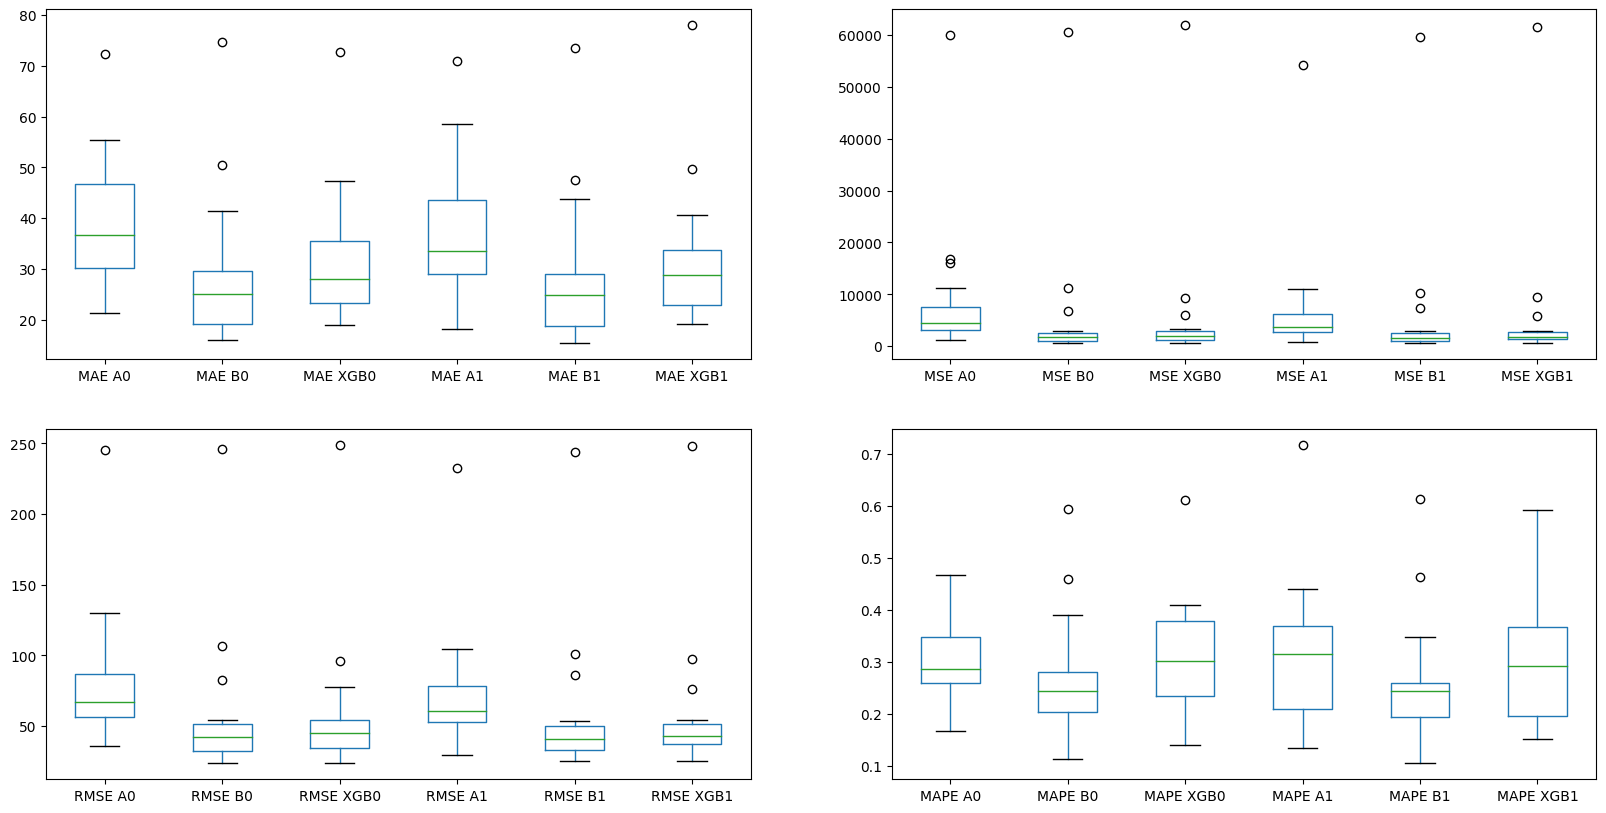

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
metricas.boxplot(column=["MAE A0", "MAE B0", "MAE XGB0", "MAE A1", "MAE B1","MAE XGB1"], grid=False)

plt.subplot(2,2,2)
metricas.boxplot(column=["MSE A0", "MSE B0", "MSE XGB0", "MSE A1", "MSE B1","MSE XGB1"], grid=False)

plt.subplot(2,2,3)
metricas.boxplot(column=["RMSE A0", "RMSE B0", "RMSE XGB0", "RMSE A1", "RMSE B1","RMSE XGB1"], grid=False)

plt.subplot(2,2,4)
metricas.boxplot(column=["MAPE A0", "MAPE B0", "MAPE XGB0", "MAPE A1", "MAPE B1","MAPE XGB1"], grid=False)
plt.show()